# Importing relevant libraries

In [49]:
!pip install numpy pandas scikit-learn matplotlib seaborn tqdm imblearn tsaug plotly nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.37.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.28.0-cp313-cp313-win_amd64.whl.metadata (4.2 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.2-py3-none-any.whl (24 kB)
Using cached jsonschema-4.25.1-py3-none-any.whl (90 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl (18 kB)
Using cached referencing-0.37.0-py3-none-any.whl (26 kB)
Using cached rpds_py-0.28.0-cp313-cp313-win_amd64.whl (227 kB)

   ---------------------- ----------------- 4/7 [jsonschema-specifications]
   ----------

In [2]:
# install cu129 torch
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

# Importing relevant libraries

In [3]:
from datetime import datetime
import copy
import os
import random

from imblearn.over_sampling import SMOTE
from optuna.exceptions import TrialPruned
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from tsaug import TimeWarp, Drift, AddNoise
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

c:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

GLOBAL_SEED = 0

def set_global_seed(seed=GLOBAL_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'
incart_path = 'INCART 2-lead Arrhythmia Database.csv'

mitbih_train = pd.read_csv(mitbih_train_path, header=None) # 80%
mitbih_test = pd.read_csv(mitbih_test_path, header=None)   # 20%

# Preprocessing Data

In [5]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test



In [6]:
# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [7]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()


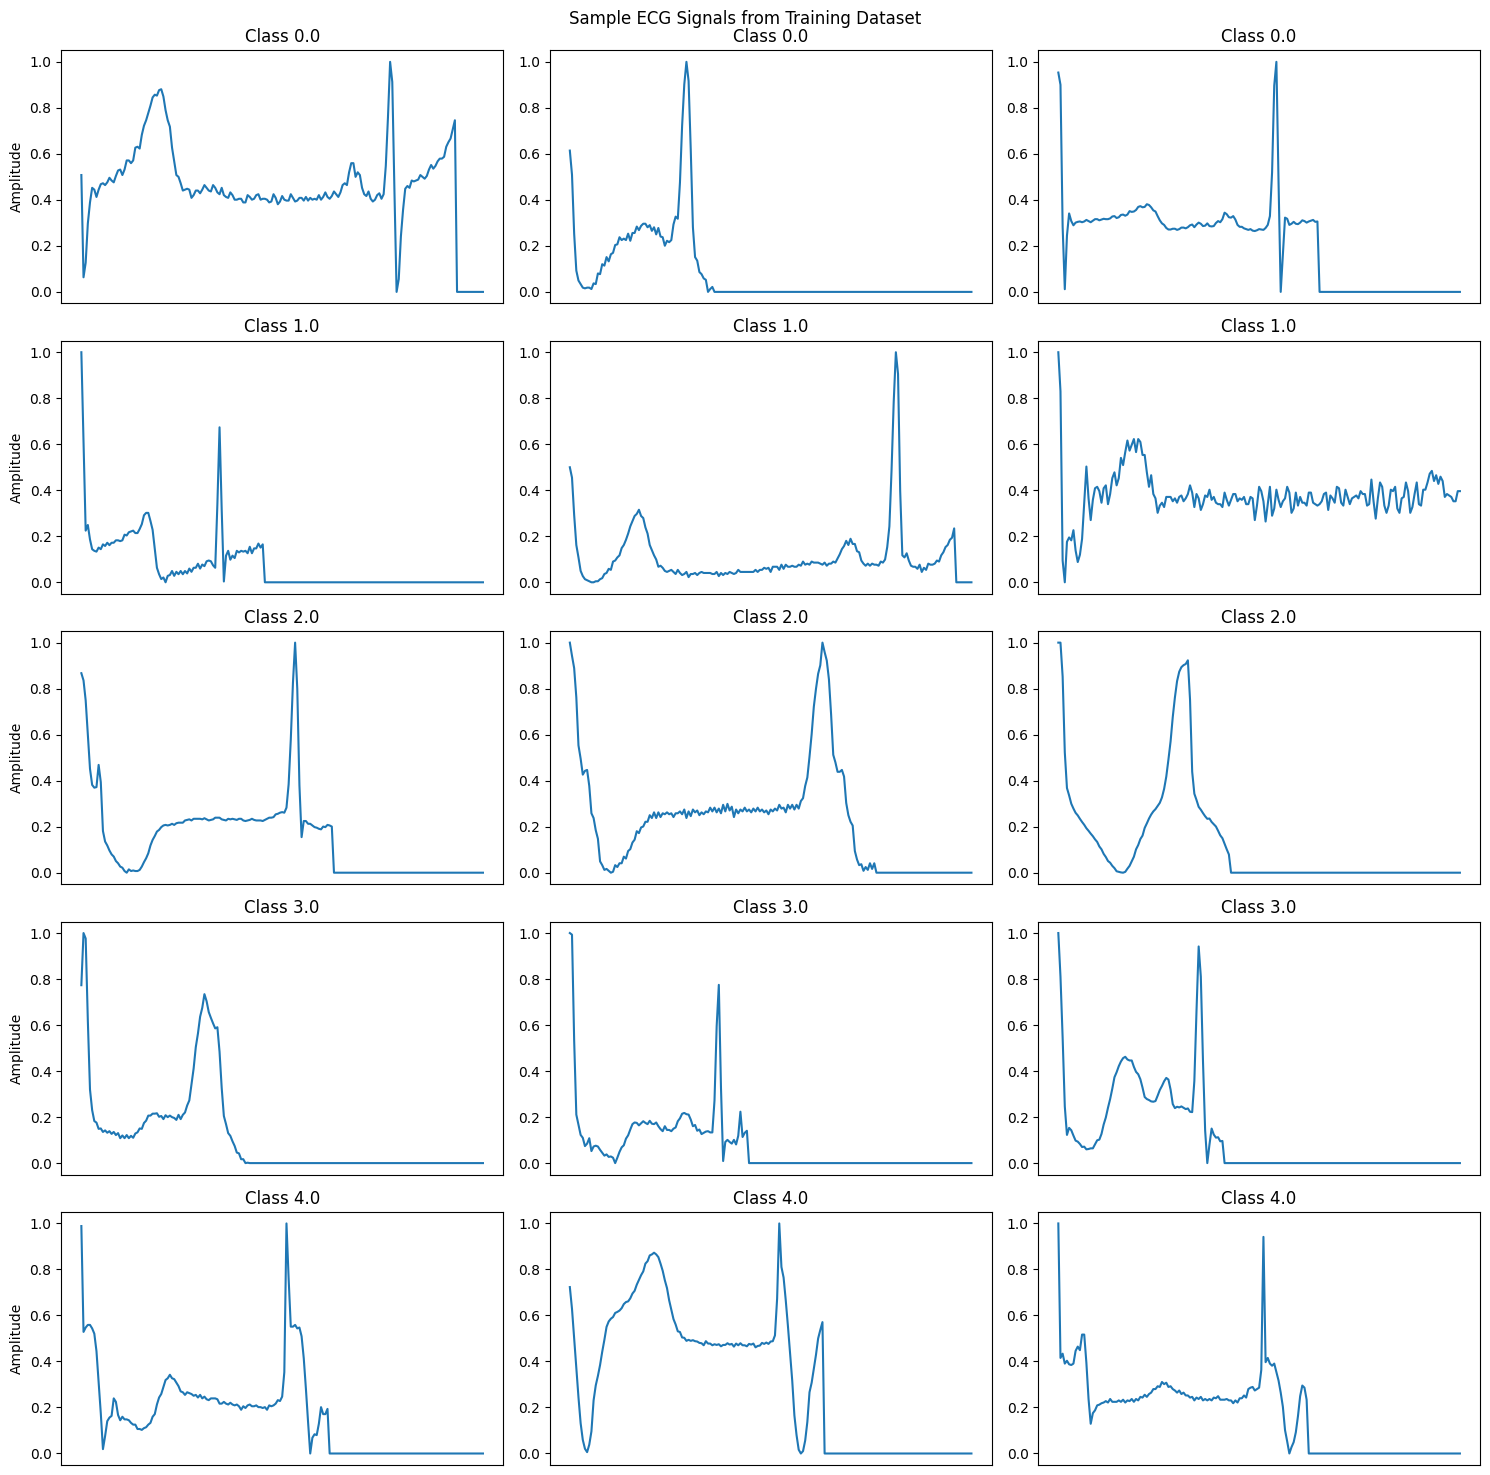


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [8]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# ECG Dataset on RNN Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ECG_RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_heads=4, num_classes=5, dropout=0.3):
        """
        Hierarchical Attention-Gated RNN for ECG classification.

        Args:
            input_size (int): Number of input features per timestep
            hidden_size (int): Hidden state size of RNNs
            num_layers (int): Number of RNN layers
            num_heads (int): Number of attention heads
            num_classes (int): Number of output classes
            dropout (float): Dropout rate
        """
        super(ECG_RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # --- 1. Short-term RNN ---
        self.short_rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 2. Long-term RNN ---
        self.long_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 3. Gated Residual Fusion ---
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.Sigmoid()
        )

        # --- 4. Multi-Head Attention ---
        self.attn_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            )
            for _ in range(num_heads)
        ])

        # --- 5. Context Refinement RNN ---
        self.context_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 6. Classification Head ---
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_size * 2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # --- Short-term encoding ---
        short_out, _ = self.short_rnn(x)  # (b, t, 2H)

        # --- Long-term encoding ---
        long_out, _ = self.long_rnn(short_out)  # (b, t, 2H)

        # --- Gated fusion of short- and long-term features ---
        combined = torch.cat([short_out, long_out], dim=-1)
        gate = self.gate(combined)  # (b, t, 2H)
        fused = gate * short_out + (1 - gate) * long_out  # Adaptive residual fusion

        # --- Multi-head attention ---
        attn_outputs = []
        for head in self.attn_heads:
            weights = head(fused)                # (b, t, 1)
            weights = F.softmax(weights, dim=1)  # normalize
            context = torch.sum(weights * fused, dim=1)  # (b, 2H)
            attn_outputs.append(context)

        # Concatenate multiple attention heads
        multihead_context = torch.stack(attn_outputs, dim=1)  # (b, heads, 2H)

        # --- Context refinement RNN ---
        refined, _ = self.context_rnn(multihead_context)  # (b, heads, 2H)
        refined = torch.mean(refined, dim=1)              # global fusion

        # --- Classification ---
        out = self.fc(refined)
        return out



In [10]:
# New: SE block and Conv+BiGRU+Attention model
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        hidden = max(1, channels // reduction)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x: (B, C, T)
        w = x.mean(dim=-1)             # (B, C)
        w = self.fc(w)                 # (B, C)
        w = w.unsqueeze(-1)            # (B, C, 1)
        return x * w                   # scale

class ECG_ConvBiGRU_Attn(nn.Module):
    def __init__(self, input_size=1, num_classes=5, conv_channels=64, gru_hidden=128, num_gru_layers=2, dropout=0.3):
        super().__init__()
        C = conv_channels
        # 1D Conv frontend with multi-dilation to capture morphology
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, C, kernel_size=7, padding=3, dilation=1),
            nn.BatchNorm1d(C),
            nn.ReLU(inplace=True),
        )
        self.se1 = SEBlock(C)

        self.conv2 = nn.Sequential(
            nn.Conv1d(C, 2*C, kernel_size=5, padding=4, dilation=2),
            nn.BatchNorm1d(2*C),
            nn.ReLU(inplace=True),
        )
        self.se2 = SEBlock(2*C)

        # BiGRU backbone
        self.bigru = nn.GRU(
            input_size=2*C,
            hidden_size=gru_hidden,
            num_layers=num_gru_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Attention pooling over time
        self.attn = nn.Sequential(
            nn.Linear(2*gru_hidden, gru_hidden),
            nn.Tanh(),
            nn.Linear(gru_hidden, 1)
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.LayerNorm(2*gru_hidden),
            nn.Linear(2*gru_hidden, gru_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(gru_hidden, num_classes),
        )

    def forward(self, x):
        # x: (B, T, 1)
        x = x.transpose(1, 2)          # (B, 1, T)
        x = self.conv1(x)              # (B, C, T)
        x = self.se1(x)
        x = self.conv2(x)              # (B, 2C, T)
        x = self.se2(x)
        x = x.transpose(1, 2)          # (B, T, 2C)

        # BiGRU
        h, _ = self.bigru(x)           # (B, T, 2H)

        # Attention pooling
        w = self.attn(h)               # (B, T, 1)
        w = F.softmax(w, dim=1)        # (B, T, 1)
        ctx = (w * h).sum(dim=1)       # (B, 2H)

        # Classifier
        out = self.fc(ctx)             # (B, num_classes)
        return out

## Alternative RNN: Conv + BiGRU + Attention

 Motivation:
 - Local morphological features (QRS complexes, ST segments) benefit from 1D convolutions capturing short-term patterns at multiple receptive fields.
 - GRUs often match LSTMs with fewer parameters on physiological time-series (useful for efficiency and regularization on MIT-BIH).
 - Squeeze-and-Excitation (SE) channel attention (Hu et al., 2018) improves representational power by recalibrating feature maps.
 - Attention pooling highlights salient timesteps for classification (commonly adopted in ECG literature: attention BiRNNs for arrhythmia detection).

 Architecture:
   Conv1D(1->C, k=7, dilations) + SE -> Conv1D(C->2C, k=5, dilations) + SE -> BiGRU(hidden=H, layers=L) -> Attn Pool -> FC.

 References:
 - Hu et al., "Squeeze-and-Excitation Networks", CVPR 2018.
 - Yildirim (2018)/and subsequent works: attention with BiRNNs for ECG arrhythmia classification.
 - Empirical results across time-series show CNN+RNN hybrids outperform single-stage models by combining local+long-range dependencies.

In [11]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing
        # weight: tensor/array of shape (C,) or None
        self.register_buffer('weight', None)
        if weight is not None:
            self.register_buffer('weight', torch.as_tensor(weight, dtype=torch.float))

    def forward(self, pred, target):
        """
        pred: (B, C), target: (B,) class indices
        Applies label smoothing and optional class weights (like nn.CrossEntropyLoss).
        """
        log_probs = F.log_softmax(pred, dim=1)
        n_classes = pred.size(1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.scatter_(1, target.unsqueeze(1), 1)
            true_dist = true_dist * (1 - self.smoothing) + self.smoothing / n_classes
        per_sample = -(true_dist * log_probs).sum(dim=1)  # (B,)
        if self.weight is not None:
            sample_w = self.weight[target]
            loss = (per_sample * sample_w).sum() / sample_w.sum()
        else:
            loss = per_sample.mean()
        return loss

In [59]:
def get_training_config():
    """
    Returns improved training configuration for RNN and ConvBiGRU models
    """
    config = {
        'RNN': {
            'model_params': {
                'input_size': 1,
                'hidden_size': 128,
                'num_layers': 2,
                'num_classes': 5,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-5,
                'max_lr': 1e-4,
                'batch_size': 128,
                'num_epochs': 50,
                'warmup_epochs': 3,
                'label_smoothing': 0.1,
                'weight_decay': 1e-5,
                'gradient_clip_val': 0.5,
                'early_stopping': {  # new
                    'patience': 10,
                    'min_delta': 1e-3,
                    'restore_best': True
                }
            },
        },
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 2e-4,
                'batch_size': 64,
                'num_epochs': 50,
                'warmup_epochs': 3,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 1.5,
                'early_stopping': {  # new
                    'patience': 10,
                    'min_delta': 1e-3,
                    'restore_best': True
                }
            },
        },
        'ConvBiGRU': {  # new model
            'model_params': {
                'input_size': 1,
                'num_classes': 5,
                'conv_channels': 64,
                'gru_hidden': 128,
                'num_gru_layers': 2,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 1e-4,
                'batch_size': 128,
                'num_epochs': 50,
                'warmup_epochs': 3,
                'label_smoothing': 0.1,
                'weight_decay': 1e-5,
                'gradient_clip_val': 0.5,
                'early_stopping': {
                    'patience': 10,
                    'min_delta': 1e-4,
                    'restore_best': True
                }
            }
        }
    }
    return config

In [60]:
# Initialize RNN model
rnn_model = ECG_RNN(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=5,
    dropout=0.3
)

# Get recommended training configurations
config = get_training_config()

In [34]:
class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config):
        from copy import deepcopy
        from torch.optim.swa_utils import AveragedModel
        self._deepcopy = deepcopy  # store reference for later use without re-import

        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Scheduler config (created in train when train_loader is known)
        self.scheduler = None
        self.scheduler_type = config.get('scheduler', 'custom')

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')

        # Early stopping setup
        es_cfg = config.get('early_stopping', {})
        self.es_patience = int(es_cfg.get('patience', 10))
        self.es_min_delta = float(es_cfg.get('min_delta', 0.0))
        self.es_restore_best = bool(es_cfg.get('restore_best', True))
        self.es_no_improve = 0
        self.best_state_dict = None

        # Fine-tuning additions
        self.grad_accum_steps = int(config.get('grad_accum_steps', 1))
        self.mixed_precision = bool(config.get('mixed_precision', False)) and torch.cuda.is_available()
        self.mixup_alpha = float(config.get('mixup_alpha', 0.0))
        self.use_swa = bool(config.get('use_swa', False))
        self.swa_start_fraction = float(config.get('swa_start', 0.8))
        self.swa_eval = bool(config.get('swa_eval', True))
        self.swa_model = None  # AveragedModel when enabled

        # AMP scaler
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def _build_scheduler(self, train_loader_len):
            total_steps = len(train_loader) * self.config['num_epochs']
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
                self.optimizer,
                max_lr=self.config['max_lr'],        # e.g., 1e-3
                total_steps=total_steps,
                pct_start=0.1,                        # 10% warmup
                div_factor=10,                         # initial_lr = max_lr / div_factor
                final_div_factor=100.0,                # final_lr = max_lr / final_div_factor
                anneal_strategy='cos',                 # cosine annealing
            )

    def _mixup(self, x, y):
        if self.mixup_alpha <= 0:
            return x, y, None, None, 1.0
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        index = torch.randperm(x.size(0), device=x.device)
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, index, lam

    def train_epoch(self, train_loader, epoch, total_epochs):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        steps = 0

        for step, (batch_X, batch_y) in enumerate(tqdm(train_loader, desc='Training')):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            # Mixup (if enabled)
            inputs, targets_a, targets_b, index, lam = self._mixup(batch_X, batch_y)

            with torch.cuda.amp.autocast(enabled=self.mixed_precision):
                result = self.model(inputs)
                outputs = result[0] if isinstance(result, (tuple, list)) else result
                if targets_b is None:
                    loss = self.criterion(outputs, batch_y)
                else:
                    loss = lam * self.criterion(outputs, targets_a) + (1 - lam) * self.criterion(outputs, targets_b)

            # Gradient scaling/accumulation
            self.scaler.scale(loss / self.grad_accum_steps).backward()

            if (step + 1) % self.grad_accum_steps == 0:
                # Gradient clipping
                if self.config.get('gradient_clip_val', None) is not None:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.config['gradient_clip_val'])
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                # Scheduler per-step for OneCycle
                if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    try:
                        self.scheduler.step()
                    except Exception:
                        pass

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            steps += 1

        epoch_loss = total_loss / max(1, steps)
        epoch_acc = 100 * correct / max(1, total)
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        steps = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                steps += 1

        epoch_loss = total_loss / max(1, steps)
        epoch_acc = 100 * correct / max(1, total)
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs, epoch_callback=None):
        """Complete training process with early stopping + HPO callback support"""
        print(f"\nStarting training for {self.model_name}...")
        if self.scheduler is None:
            self._build_scheduler(len(train_loader))

        swa_begin_epoch = int(np.floor(self.swa_start_fraction * num_epochs)) if self.use_swa else None

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader, epoch, num_epochs)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            if isinstance(self.scheduler, torch.optim.lr_scheduler._LRScheduler):
                current_lr = self.scheduler.step()
            else:
                current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Optional epoch callback (for Optuna pruning)
            if epoch_callback is not None:
                epoch_callback(epoch, train_loss, val_loss, train_acc, val_acc, current_lr)

            # Early stopping check with best model saving
            if val_loss < self.best_val_loss - self.es_min_delta:
                self.best_val_loss = val_loss
                self.es_no_improve = 0
                self.best_state_dict = self._deepcopy(self.model.state_dict())
                self.save_model('best_model.pth')
                print(f'New best model saved! (Val Loss: {val_loss:.4f})')
            else:
                self.es_no_improve += 1
                print(f'No improvement: {self.es_no_improve}/{self.es_patience}')

            # SWA update
            if self.use_swa and epoch + 1 >= (swa_begin_epoch or num_epochs+1):
                if self.swa_model is None:
                    from torch.optim.swa_utils import AveragedModel
                    self.swa_model = AveragedModel(self.model)
                    print('Initialized SWA model averaging.')
                else:
                    self.swa_model.update_parameters(self.model)

            if self.es_no_improve >= self.es_patience:
                print(f'Early stopping triggered at epoch {epoch+1}. Best val loss: {self.best_val_loss:.4f}')
                if self.es_restore_best and self.best_state_dict is not None:
                    self.model.load_state_dict(self.best_state_dict)
                    print('Restored best model weights.')
                break

        # Finalize SWA (compute BN updates if available) and swap for eval/save
        if self.swa_model is not None and self.swa_eval:
            try:
                from torch.optim.swa_utils import update_bn
                update_bn(train_loader, self.swa_model, device=self.device)
                self.model = self.swa_model
                print('SWA model swapped in for evaluation and saving.')
            except Exception as e:
                print('SWA BN update failed or not applicable:', e)

        # Save final model
        self.save_model(f'{self.model_name.lower()}_final_model.pth')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config
        }, path)

    def plot_training_history(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'))
        plt.show()

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Compute accuracy
        acc = accuracy_score(true_labels, predictions)
        print(f"\nTest Accuracy ({self.model_name}): {acc*100:.2f}%")

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if hasattr(self, 'save_dir'):
            os.makedirs(self.save_dir, exist_ok=True)
            plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'))
        plt.show()
        return acc


In [35]:
def train_rnn_model(model_name, train_loader, val_loader, test_loader, config_override=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base = get_training_config()
    cfg = config_override or base   # use config_override if provided

    tr_cfg = cfg['RNN']['training_params']

    rnn_model = ECG_RNN(**cfg['RNN']['model_params'])

    rnn_criterion = SmoothCrossEntropyLoss(smoothing=tr_cfg['label_smoothing'])

    rnn_trainer = ModelTrainer(
        model=rnn_model,
        model_name=model_name,
        device=device,
        criterion=rnn_criterion,
        config=tr_cfg
    )
    rnn_trainer.train(train_loader, val_loader, tr_cfg['num_epochs'])
    rnn_trainer.plot_training_history()
    test_acc = rnn_trainer.evaluate(test_loader)

    return rnn_trainer, test_acc

In [36]:
def train_conv_bigru_model(model_name, train_loader, val_loader, test_loader, config_override=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base = get_training_config()
    cfg = config_override or base   # use config_override if provided

    tr_cfg = cfg['ConvBiGRU']['training_params']

    conv_bigru_model = ECG_ConvBiGRU_Attn(**cfg['ConvBiGRU']['model_params'])

    criterion = SmoothCrossEntropyLoss(smoothing=tr_cfg['label_smoothing'])

    trainer = ModelTrainer(
        model=conv_bigru_model,
        model_name=model_name,
        device=device,
        criterion=criterion,
        config=tr_cfg
    )
    trainer.train(train_loader, val_loader, tr_cfg['num_epochs'])
    trainer.plot_training_history()
    test_acc = trainer.evaluate(test_loader)

    return trainer, test_acc

In [37]:
config = get_training_config()
num_classes = len(np.unique(y_train))
sequence_length = X_train.shape[1]

config['RNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['sequence_length'] = sequence_length
config['ConvBiGRU']['model_params']['num_classes'] = num_classes

print("\nUpdated configuration:")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {sequence_length}")



Updated configuration:
Number of classes: 5
Sequence length: 187


C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:49: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



Using device: cuda

Starting training for Vanilla_RNN...


Training:   0%|          | 0/2463 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:90: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.82it/s]



Epoch [1/50]
Train Loss: 0.8536, Train Acc: 82.67%
Val   Loss: 0.7963, Val   Acc: 83.35%
Learning Rate: 0.000019
New best model saved! (Val Loss: 0.7963)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.18it/s]



Epoch [2/50]
Train Loss: 0.7819, Train Acc: 83.33%
Val   Loss: 0.7065, Val   Acc: 86.73%
Learning Rate: 0.000041
New best model saved! (Val Loss: 0.7065)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.00it/s]



Epoch [3/50]
Train Loss: 0.6252, Train Acc: 91.19%
Val   Loss: 0.5742, Val   Acc: 92.80%
Learning Rate: 0.000069
New best model saved! (Val Loss: 0.5742)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.15it/s]



Epoch [4/50]
Train Loss: 0.5682, Train Acc: 93.36%
Val   Loss: 0.5427, Val   Acc: 93.81%
Learning Rate: 0.000091
New best model saved! (Val Loss: 0.5427)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.84it/s]



Epoch [5/50]
Train Loss: 0.5378, Train Acc: 94.48%
Val   Loss: 0.5254, Val   Acc: 94.74%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.5254)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.91it/s]



Epoch [6/50]
Train Loss: 0.5182, Train Acc: 95.22%
Val   Loss: 0.5141, Val   Acc: 95.04%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.5141)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.72it/s]



Epoch [7/50]
Train Loss: 0.5022, Train Acc: 95.82%
Val   Loss: 0.4986, Val   Acc: 95.65%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.4986)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.79it/s]



Epoch [8/50]
Train Loss: 0.4917, Train Acc: 96.20%
Val   Loss: 0.4877, Val   Acc: 96.00%
Learning Rate: 0.000099
New best model saved! (Val Loss: 0.4877)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.26it/s]



Epoch [9/50]
Train Loss: 0.4836, Train Acc: 96.48%
Val   Loss: 0.4816, Val   Acc: 96.32%
Learning Rate: 0.000098
New best model saved! (Val Loss: 0.4816)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.65it/s]



Epoch [10/50]
Train Loss: 0.4764, Train Acc: 96.68%
Val   Loss: 0.4733, Val   Acc: 96.65%
Learning Rate: 0.000097
New best model saved! (Val Loss: 0.4733)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.50it/s]



Epoch [11/50]
Train Loss: 0.4692, Train Acc: 97.01%
Val   Loss: 0.4649, Val   Acc: 97.10%
Learning Rate: 0.000096
New best model saved! (Val Loss: 0.4649)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.16it/s]



Epoch [12/50]
Train Loss: 0.4644, Train Acc: 97.22%
Val   Loss: 0.4729, Val   Acc: 96.67%
Learning Rate: 0.000094
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.84it/s]



Epoch [13/50]
Train Loss: 0.4600, Train Acc: 97.39%
Val   Loss: 0.4539, Val   Acc: 97.43%
Learning Rate: 0.000092
New best model saved! (Val Loss: 0.4539)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.71it/s]



Epoch [14/50]
Train Loss: 0.4567, Train Acc: 97.50%
Val   Loss: 0.4584, Val   Acc: 97.30%
Learning Rate: 0.000090
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.24it/s]



Epoch [15/50]
Train Loss: 0.4548, Train Acc: 97.54%
Val   Loss: 0.4547, Val   Acc: 97.46%
Learning Rate: 0.000088
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.50it/s]



Epoch [16/50]
Train Loss: 0.4503, Train Acc: 97.70%
Val   Loss: 0.4582, Val   Acc: 97.33%
Learning Rate: 0.000086
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.31it/s]



Epoch [17/50]
Train Loss: 0.4492, Train Acc: 97.74%
Val   Loss: 0.4508, Val   Acc: 97.61%
Learning Rate: 0.000083
New best model saved! (Val Loss: 0.4508)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.40it/s]



Epoch [18/50]
Train Loss: 0.4457, Train Acc: 97.92%
Val   Loss: 0.4468, Val   Acc: 97.78%
Learning Rate: 0.000081
New best model saved! (Val Loss: 0.4468)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.71it/s]



Epoch [19/50]
Train Loss: 0.4434, Train Acc: 97.98%
Val   Loss: 0.4449, Val   Acc: 97.86%
Learning Rate: 0.000078
New best model saved! (Val Loss: 0.4449)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.59it/s]



Epoch [20/50]
Train Loss: 0.4400, Train Acc: 98.14%
Val   Loss: 0.4446, Val   Acc: 97.83%
Learning Rate: 0.000075
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.71it/s]



Epoch [21/50]
Train Loss: 0.4386, Train Acc: 98.21%
Val   Loss: 0.4441, Val   Acc: 97.91%
Learning Rate: 0.000072
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.22it/s]



Epoch [22/50]
Train Loss: 0.4368, Train Acc: 98.26%
Val   Loss: 0.4425, Val   Acc: 98.04%
Learning Rate: 0.000069
New best model saved! (Val Loss: 0.4425)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.98it/s]



Epoch [23/50]
Train Loss: 0.4350, Train Acc: 98.32%
Val   Loss: 0.4379, Val   Acc: 98.09%
Learning Rate: 0.000065
New best model saved! (Val Loss: 0.4379)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.50it/s]



Epoch [24/50]
Train Loss: 0.4338, Train Acc: 98.42%
Val   Loss: 0.4375, Val   Acc: 98.17%
Learning Rate: 0.000062
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.24it/s]



Epoch [25/50]
Train Loss: 0.4309, Train Acc: 98.50%
Val   Loss: 0.4389, Val   Acc: 98.06%
Learning Rate: 0.000059
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.67it/s]



Epoch [26/50]
Train Loss: 0.4301, Train Acc: 98.49%
Val   Loss: 0.4395, Val   Acc: 98.10%
Learning Rate: 0.000055
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.84it/s]



Epoch [27/50]
Train Loss: 0.4289, Train Acc: 98.59%
Val   Loss: 0.4368, Val   Acc: 98.25%
Learning Rate: 0.000052
New best model saved! (Val Loss: 0.4368)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.08it/s]



Epoch [28/50]
Train Loss: 0.4265, Train Acc: 98.68%
Val   Loss: 0.4359, Val   Acc: 98.15%
Learning Rate: 0.000048
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.68it/s]



Epoch [29/50]
Train Loss: 0.4252, Train Acc: 98.70%
Val   Loss: 0.4347, Val   Acc: 98.28%
Learning Rate: 0.000045
New best model saved! (Val Loss: 0.4347)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.86it/s]



Epoch [30/50]
Train Loss: 0.4241, Train Acc: 98.77%
Val   Loss: 0.4346, Val   Acc: 98.38%
Learning Rate: 0.000041
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.73it/s]



Epoch [31/50]
Train Loss: 0.4220, Train Acc: 98.85%
Val   Loss: 0.4338, Val   Acc: 98.34%
Learning Rate: 0.000038
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.73it/s]



Epoch [32/50]
Train Loss: 0.4219, Train Acc: 98.88%
Val   Loss: 0.4319, Val   Acc: 98.42%
Learning Rate: 0.000035
New best model saved! (Val Loss: 0.4319)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.33it/s]



Epoch [33/50]
Train Loss: 0.4201, Train Acc: 98.93%
Val   Loss: 0.4338, Val   Acc: 98.38%
Learning Rate: 0.000031
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.76it/s]



Epoch [34/50]
Train Loss: 0.4192, Train Acc: 98.96%
Val   Loss: 0.4340, Val   Acc: 98.33%
Learning Rate: 0.000028
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.38it/s]



Epoch [35/50]
Train Loss: 0.4180, Train Acc: 99.03%
Val   Loss: 0.4328, Val   Acc: 98.42%
Learning Rate: 0.000025
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.08it/s]



Epoch [36/50]
Train Loss: 0.4169, Train Acc: 99.05%
Val   Loss: 0.4349, Val   Acc: 98.34%
Learning Rate: 0.000022
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.96it/s]



Epoch [37/50]
Train Loss: 0.4156, Train Acc: 99.12%
Val   Loss: 0.4328, Val   Acc: 98.42%
Learning Rate: 0.000019
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.95it/s]



Epoch [38/50]
Train Loss: 0.4149, Train Acc: 99.14%
Val   Loss: 0.4318, Val   Acc: 98.47%
Learning Rate: 0.000017
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.20it/s]



Epoch [39/50]
Train Loss: 0.4141, Train Acc: 99.17%
Val   Loss: 0.4307, Val   Acc: 98.49%
Learning Rate: 0.000014
New best model saved! (Val Loss: 0.4307)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.68it/s]



Epoch [40/50]
Train Loss: 0.4135, Train Acc: 99.20%
Val   Loss: 0.4325, Val   Acc: 98.40%
Learning Rate: 0.000012
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.07it/s]



Epoch [41/50]
Train Loss: 0.4127, Train Acc: 99.22%
Val   Loss: 0.4320, Val   Acc: 98.36%
Learning Rate: 0.000010
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.83it/s]



Epoch [42/50]
Train Loss: 0.4124, Train Acc: 99.25%
Val   Loss: 0.4307, Val   Acc: 98.49%
Learning Rate: 0.000008
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.33it/s]



Epoch [43/50]
Train Loss: 0.4116, Train Acc: 99.27%
Val   Loss: 0.4309, Val   Acc: 98.48%
Learning Rate: 0.000006
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.96it/s]



Epoch [44/50]
Train Loss: 0.4111, Train Acc: 99.29%
Val   Loss: 0.4325, Val   Acc: 98.33%
Learning Rate: 0.000004
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.71it/s]



Epoch [45/50]
Train Loss: 0.4106, Train Acc: 99.32%
Val   Loss: 0.4316, Val   Acc: 98.49%
Learning Rate: 0.000003
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.42it/s]



Epoch [46/50]
Train Loss: 0.4106, Train Acc: 99.32%
Val   Loss: 0.4309, Val   Acc: 98.48%
Learning Rate: 0.000002
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.38it/s]



Epoch [47/50]
Train Loss: 0.4103, Train Acc: 99.34%
Val   Loss: 0.4312, Val   Acc: 98.46%
Learning Rate: 0.000001
No improvement: 8/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.89it/s]



Epoch [48/50]
Train Loss: 0.4098, Train Acc: 99.35%
Val   Loss: 0.4314, Val   Acc: 98.42%
Learning Rate: 0.000001
No improvement: 9/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.17it/s]



Epoch [49/50]
Train Loss: 0.4098, Train Acc: 99.34%
Val   Loss: 0.4313, Val   Acc: 98.46%
Learning Rate: 0.000000
No improvement: 10/10
Early stopping triggered at epoch 49. Best val loss: 0.4307
Restored best model weights.


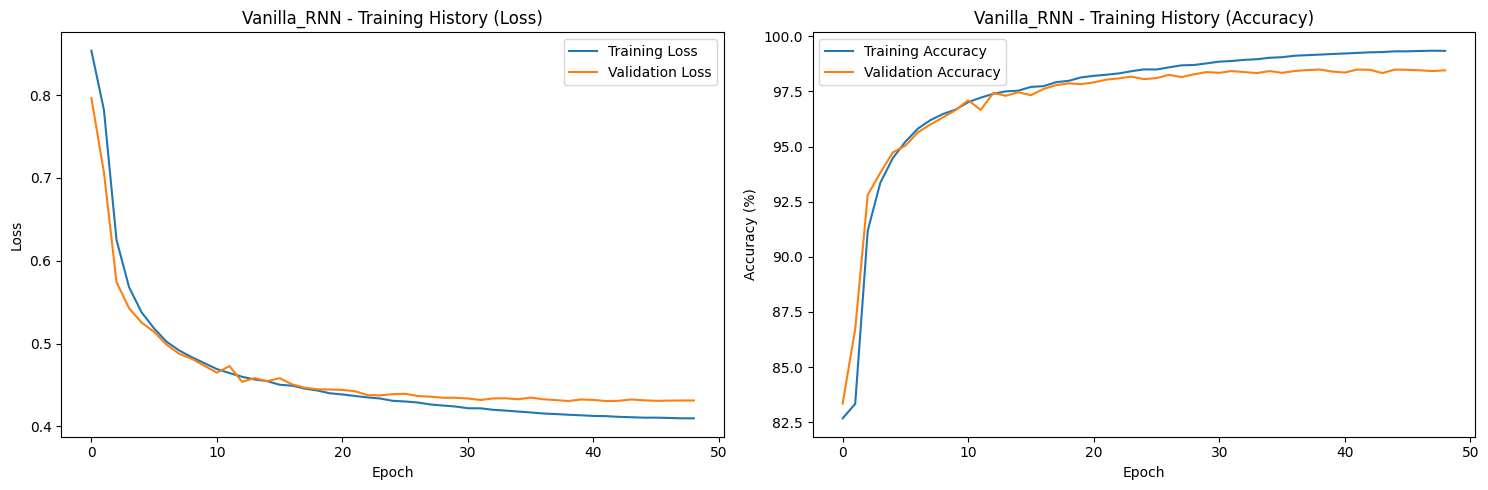

Testing: 100%|██████████| 685/685 [00:01<00:00, 374.97it/s]



Test Accuracy (Vanilla_RNN): 98.20%

Classification Report (Vanilla_RNN):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.89      0.75      0.81       556
           2       0.95      0.95      0.95      1448
           3       0.82      0.68      0.74       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.93      0.87      0.90     21892
weighted avg       0.98      0.98      0.98     21892



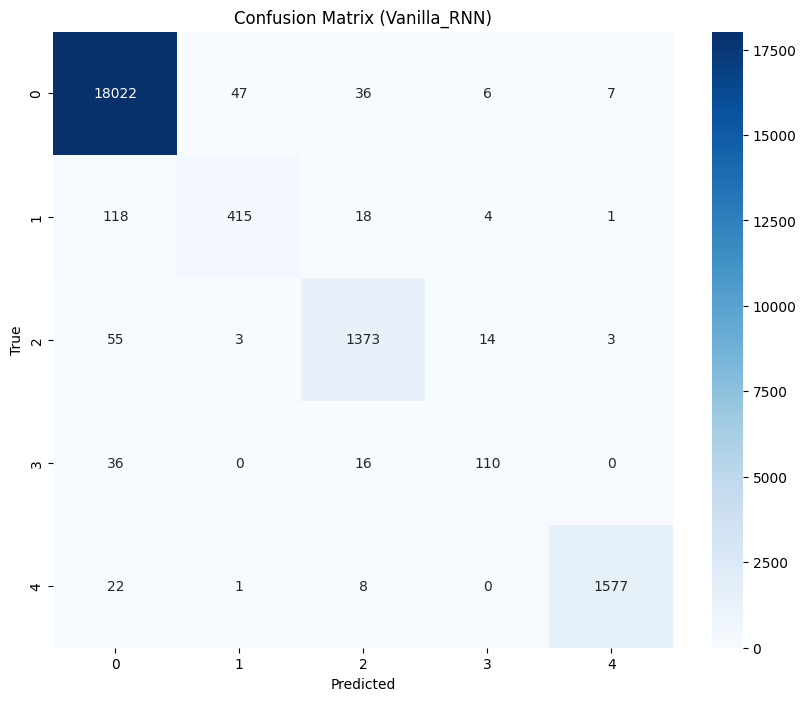

In [61]:
rnn_trainer, rnn_accuracy = train_rnn_model('Vanilla_RNN', train_loader, val_loader, test_loader)

C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:49: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



Using device: cuda

Starting training for Vanilla_ConvBiGRU...


Training:   0%|          | 0/2463 [00:00<?, ?it/s]

C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:90: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Training: 100%|██████████| 2463/2463 [00:13<00:00, 178.13it/s]



Epoch [1/50]
Train Loss: 0.7110, Train Acc: 86.98%
Val   Loss: 0.5405, Val   Acc: 93.70%
Learning Rate: 0.000019
New best model saved! (Val Loss: 0.5405)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.37it/s]



Epoch [2/50]
Train Loss: 0.5257, Train Acc: 94.64%
Val   Loss: 0.4851, Val   Acc: 95.98%
Learning Rate: 0.000041
New best model saved! (Val Loss: 0.4851)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.34it/s]



Epoch [3/50]
Train Loss: 0.4958, Train Acc: 95.94%
Val   Loss: 0.4647, Val   Acc: 96.85%
Learning Rate: 0.000069
New best model saved! (Val Loss: 0.4647)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.84it/s]



Epoch [4/50]
Train Loss: 0.4824, Train Acc: 96.46%
Val   Loss: 0.4674, Val   Acc: 96.87%
Learning Rate: 0.000091
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.03it/s]



Epoch [5/50]
Train Loss: 0.4759, Train Acc: 96.74%
Val   Loss: 0.4562, Val   Acc: 97.22%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.4562)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.04it/s]



Epoch [6/50]
Train Loss: 0.4676, Train Acc: 97.08%
Val   Loss: 0.4531, Val   Acc: 97.34%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.4531)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 180.09it/s]



Epoch [7/50]
Train Loss: 0.4623, Train Acc: 97.30%
Val   Loss: 0.4453, Val   Acc: 97.73%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.4453)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.55it/s]



Epoch [8/50]
Train Loss: 0.4565, Train Acc: 97.56%
Val   Loss: 0.4497, Val   Acc: 97.62%
Learning Rate: 0.000099
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.46it/s]



Epoch [9/50]
Train Loss: 0.4537, Train Acc: 97.64%
Val   Loss: 0.4406, Val   Acc: 97.93%
Learning Rate: 0.000098
New best model saved! (Val Loss: 0.4406)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.92it/s]



Epoch [10/50]
Train Loss: 0.4507, Train Acc: 97.74%
Val   Loss: 0.4400, Val   Acc: 97.85%
Learning Rate: 0.000097
New best model saved! (Val Loss: 0.4400)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 181.92it/s]



Epoch [11/50]
Train Loss: 0.4467, Train Acc: 97.91%
Val   Loss: 0.4370, Val   Acc: 97.98%
Learning Rate: 0.000096
New best model saved! (Val Loss: 0.4370)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.88it/s]



Epoch [12/50]
Train Loss: 0.4442, Train Acc: 98.02%
Val   Loss: 0.4418, Val   Acc: 97.86%
Learning Rate: 0.000094
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.38it/s]



Epoch [13/50]
Train Loss: 0.4423, Train Acc: 98.07%
Val   Loss: 0.4352, Val   Acc: 98.12%
Learning Rate: 0.000092
New best model saved! (Val Loss: 0.4352)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.15it/s]



Epoch [14/50]
Train Loss: 0.4401, Train Acc: 98.18%
Val   Loss: 0.4394, Val   Acc: 98.06%
Learning Rate: 0.000090
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.52it/s]



Epoch [15/50]
Train Loss: 0.4385, Train Acc: 98.22%
Val   Loss: 0.4327, Val   Acc: 98.29%
Learning Rate: 0.000088
New best model saved! (Val Loss: 0.4327)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 183.34it/s]



Epoch [16/50]
Train Loss: 0.4370, Train Acc: 98.29%
Val   Loss: 0.4323, Val   Acc: 98.23%
Learning Rate: 0.000086
New best model saved! (Val Loss: 0.4323)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 180.27it/s]



Epoch [17/50]
Train Loss: 0.4342, Train Acc: 98.40%
Val   Loss: 0.4365, Val   Acc: 98.15%
Learning Rate: 0.000083
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.58it/s]



Epoch [18/50]
Train Loss: 0.4329, Train Acc: 98.43%
Val   Loss: 0.4294, Val   Acc: 98.39%
Learning Rate: 0.000081
New best model saved! (Val Loss: 0.4294)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 178.29it/s]



Epoch [19/50]
Train Loss: 0.4306, Train Acc: 98.54%
Val   Loss: 0.4315, Val   Acc: 98.33%
Learning Rate: 0.000078
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.12it/s]



Epoch [20/50]
Train Loss: 0.4300, Train Acc: 98.54%
Val   Loss: 0.4302, Val   Acc: 98.39%
Learning Rate: 0.000075
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 178.43it/s]



Epoch [21/50]
Train Loss: 0.4284, Train Acc: 98.60%
Val   Loss: 0.4280, Val   Acc: 98.46%
Learning Rate: 0.000072
New best model saved! (Val Loss: 0.4280)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.61it/s]



Epoch [22/50]
Train Loss: 0.4268, Train Acc: 98.65%
Val   Loss: 0.4246, Val   Acc: 98.53%
Learning Rate: 0.000069
New best model saved! (Val Loss: 0.4246)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.07it/s]



Epoch [23/50]
Train Loss: 0.4251, Train Acc: 98.71%
Val   Loss: 0.4258, Val   Acc: 98.46%
Learning Rate: 0.000065
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.17it/s]



Epoch [24/50]
Train Loss: 0.4233, Train Acc: 98.81%
Val   Loss: 0.4305, Val   Acc: 98.31%
Learning Rate: 0.000062
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.53it/s]



Epoch [25/50]
Train Loss: 0.4223, Train Acc: 98.81%
Val   Loss: 0.4267, Val   Acc: 98.52%
Learning Rate: 0.000059
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.06it/s]



Epoch [26/50]
Train Loss: 0.4214, Train Acc: 98.85%
Val   Loss: 0.4239, Val   Acc: 98.69%
Learning Rate: 0.000055
New best model saved! (Val Loss: 0.4239)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.70it/s]



Epoch [27/50]
Train Loss: 0.4195, Train Acc: 98.93%
Val   Loss: 0.4268, Val   Acc: 98.53%
Learning Rate: 0.000052
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.48it/s]



Epoch [28/50]
Train Loss: 0.4184, Train Acc: 98.97%
Val   Loss: 0.4265, Val   Acc: 98.54%
Learning Rate: 0.000048
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.41it/s]



Epoch [29/50]
Train Loss: 0.4175, Train Acc: 98.99%
Val   Loss: 0.4242, Val   Acc: 98.68%
Learning Rate: 0.000045
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.75it/s]



Epoch [30/50]
Train Loss: 0.4161, Train Acc: 99.05%
Val   Loss: 0.4237, Val   Acc: 98.65%
Learning Rate: 0.000041
New best model saved! (Val Loss: 0.4237)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.43it/s]



Epoch [31/50]
Train Loss: 0.4153, Train Acc: 99.07%
Val   Loss: 0.4236, Val   Acc: 98.70%
Learning Rate: 0.000038
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 178.64it/s]



Epoch [32/50]
Train Loss: 0.4142, Train Acc: 99.14%
Val   Loss: 0.4264, Val   Acc: 98.54%
Learning Rate: 0.000035
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 179.76it/s]



Epoch [33/50]
Train Loss: 0.4130, Train Acc: 99.18%
Val   Loss: 0.4236, Val   Acc: 98.70%
Learning Rate: 0.000031
New best model saved! (Val Loss: 0.4236)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.81it/s]



Epoch [34/50]
Train Loss: 0.4124, Train Acc: 99.21%
Val   Loss: 0.4240, Val   Acc: 98.61%
Learning Rate: 0.000028
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.61it/s]



Epoch [35/50]
Train Loss: 0.4114, Train Acc: 99.26%
Val   Loss: 0.4231, Val   Acc: 98.78%
Learning Rate: 0.000025
New best model saved! (Val Loss: 0.4231)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.38it/s]



Epoch [36/50]
Train Loss: 0.4106, Train Acc: 99.29%
Val   Loss: 0.4225, Val   Acc: 98.71%
Learning Rate: 0.000022
New best model saved! (Val Loss: 0.4225)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.88it/s]



Epoch [37/50]
Train Loss: 0.4102, Train Acc: 99.29%
Val   Loss: 0.4237, Val   Acc: 98.70%
Learning Rate: 0.000019
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.74it/s]



Epoch [38/50]
Train Loss: 0.4091, Train Acc: 99.35%
Val   Loss: 0.4208, Val   Acc: 98.76%
Learning Rate: 0.000017
New best model saved! (Val Loss: 0.4208)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.15it/s]



Epoch [39/50]
Train Loss: 0.4090, Train Acc: 99.37%
Val   Loss: 0.4217, Val   Acc: 98.71%
Learning Rate: 0.000014
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 164.61it/s]



Epoch [40/50]
Train Loss: 0.4085, Train Acc: 99.37%
Val   Loss: 0.4222, Val   Acc: 98.80%
Learning Rate: 0.000012
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 163.67it/s]



Epoch [41/50]
Train Loss: 0.4078, Train Acc: 99.42%
Val   Loss: 0.4215, Val   Acc: 98.81%
Learning Rate: 0.000010
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 163.76it/s]



Epoch [42/50]
Train Loss: 0.4074, Train Acc: 99.44%
Val   Loss: 0.4208, Val   Acc: 98.77%
Learning Rate: 0.000008
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 164.39it/s]



Epoch [43/50]
Train Loss: 0.4069, Train Acc: 99.45%
Val   Loss: 0.4214, Val   Acc: 98.74%
Learning Rate: 0.000006
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 164.51it/s]



Epoch [44/50]
Train Loss: 0.4065, Train Acc: 99.47%
Val   Loss: 0.4217, Val   Acc: 98.70%
Learning Rate: 0.000004
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 164.90it/s]



Epoch [45/50]
Train Loss: 0.4065, Train Acc: 99.46%
Val   Loss: 0.4219, Val   Acc: 98.73%
Learning Rate: 0.000003
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 164.08it/s]



Epoch [46/50]
Train Loss: 0.4064, Train Acc: 99.48%
Val   Loss: 0.4220, Val   Acc: 98.74%
Learning Rate: 0.000002
No improvement: 8/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.29it/s]



Epoch [47/50]
Train Loss: 0.4062, Train Acc: 99.46%
Val   Loss: 0.4216, Val   Acc: 98.74%
Learning Rate: 0.000001
No improvement: 9/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.20it/s]



Epoch [48/50]
Train Loss: 0.4060, Train Acc: 99.48%
Val   Loss: 0.4223, Val   Acc: 98.71%
Learning Rate: 0.000001
No improvement: 10/10
Early stopping triggered at epoch 48. Best val loss: 0.4208
Restored best model weights.


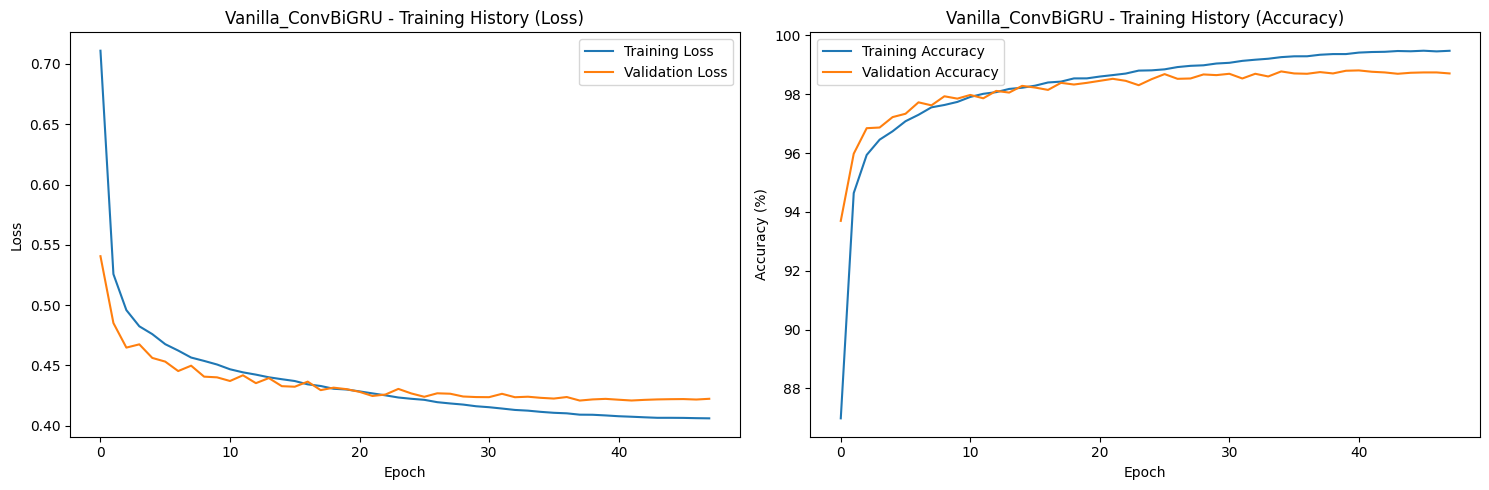

Testing: 100%|██████████| 685/685 [00:01<00:00, 536.41it/s]



Test Accuracy (Vanilla_ConvBiGRU): 98.65%

Classification Report (Vanilla_ConvBiGRU):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.92      0.79      0.85       556
           2       0.98      0.95      0.96      1448
           3       0.81      0.76      0.78       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.90      0.92     21892
weighted avg       0.99      0.99      0.99     21892



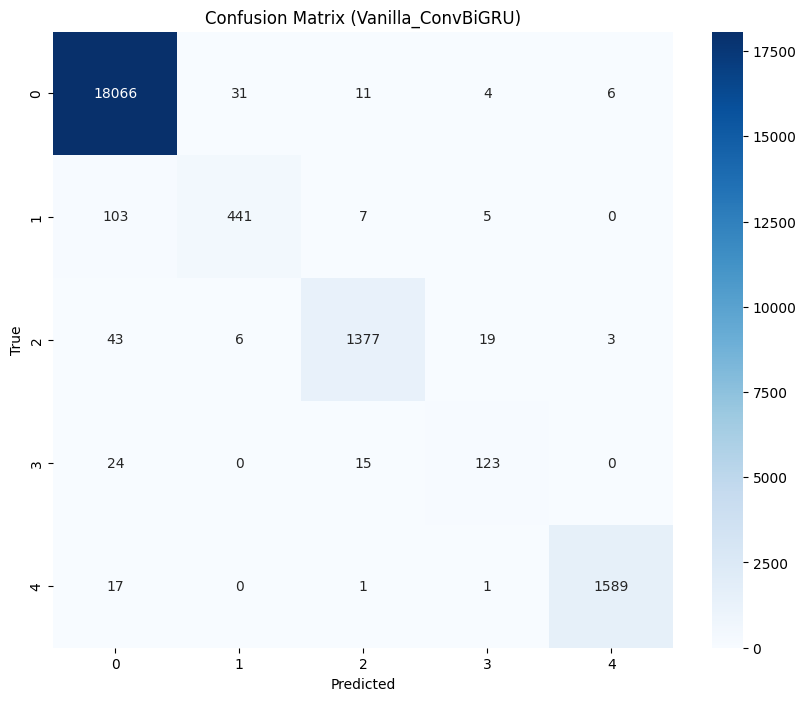

In [62]:
convbigru_trainer, convbigru_accuracy = train_conv_bigru_model('Vanilla_ConvBiGRU',train_loader, val_loader, test_loader)

In [63]:
print("Test Accuracies:")
print(f"RNN Model Test Accuracy: {rnn_accuracy*100:.2f}%")
print(f"ConvBiGRU Model Test Accuracy: {convbigru_accuracy*100:.2f}%")

Test Accuracies:
RNN Model Test Accuracy: 98.20%
ConvBiGRU Model Test Accuracy: 98.65%


In [21]:
import copy
import optuna
import torch
import numpy as np

def optuna_objective(trial, train_loader, val_loader, model_key='RNN', device=None):
    """
    Optuna objective integrated with your config structure.
    model_key: 'RNN' | 'ConvBiGRU' | 'CNN'
    """

    # --- Setup ---
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_config = get_training_config()
    config = copy.deepcopy(base_config[model_key])  # isolate one model's config

    # --- Sample hyperparameters ---
    tp = config['training_params']
    mp = config['model_params']

    if model_key == 'RNN':
        mp['hidden_size'] = trial.suggest_categorical("hidden_size", [64, 128])
        mp['num_layers'] = trial.suggest_int("num_layers", 1, 3)
        mp['dropout'] = trial.suggest_float("dropout", 0.1, 0.5)

    elif model_key == 'ConvBiGRU':
        mp['conv_channels'] = trial.suggest_categorical("conv_channels", [32, 64, 128])
        mp['gru_hidden'] = trial.suggest_categorical("gru_hidden", [64, 128])
        mp['num_gru_layers'] = trial.suggest_int("num_gru_layers", 1, 3)
        mp['dropout'] = trial.suggest_float("dropout", 0.1, 0.5)

    # --- Training hyperparams ---
    tp['initial_lr'] = trial.suggest_loguniform("initial_lr", 1e-5, 1e-3)
    tp['max_lr'] = tp['initial_lr'] * 10
    tp['weight_decay'] = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    tp['batch_size'] = trial.suggest_categorical("batch_size", [64, 128])
    tp['num_epochs'] = 20  # shorter during tuning for speed

    # --- Initialize model ---
    if model_key == 'RNN':
        model_cls = ECG_RNN
    elif model_key == 'ConvBiGRU':
        model_cls = ECG_ConvBiGRU_Attn
    else:
        raise ValueError(f"Unsupported model type: {model_key}")

    model = model_cls(**mp).to(device)
    criterion = SmoothCrossEntropyLoss(smoothing=tp.get('label_smoothing', 0.0))

    # --- Initialize trainer ---
    trainer = ModelTrainer(
        model=model,
        model_name=f"{model_key}_OptunaTrial",
        device=device,
        criterion=criterion,
        config=tp
    )

    # --- Define pruning callback ---
    def optuna_pruning_callback(epoch, train_loss, val_loss, train_acc, val_acc, lr):
        trial.report(val_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # --- Train ---
    trainer.train(train_loader, val_loader, tp['num_epochs'], epoch_callback=optuna_pruning_callback)

    return trainer.best_val_loss


In [22]:
pruner = optuna.pruners.PatientPruner(
    optuna.pruners.MedianPruner(n_warmup_steps=3),
    patience=1
)

study_rnn = optuna.create_study(direction="minimize", pruner=pruner)

# Tune RNN
study_rnn.optimize(lambda trial: optuna_objective(trial, train_loader, val_loader,'RNN'),
               n_trials=30)

print("Best RNN trial params:")
print(study_rnn.best_trial.params)

C:\Users\leona\AppData\Local\Temp\ipykernel_15540\33114566.py:1: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = optuna.pruners.PatientPruner(
[I 2025-11-12 10:16:47,911] A new study created in memory with name: no-name-9d69f557-93fb-474e-826f-dd1461939482
C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2743215315.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tp['initial_lr'] = trial.suggest_loguniform("initial_lr", 1e-5, 1e-3)
C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2743215315.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tp['weight_decay'] = trial.suggest_logunifor


Starting training for RNN_OptunaTrial...


Training:   0%|          | 0/2463 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.32it/s]



Epoch [1/20]
Train Loss: 0.7162, Train Acc: 87.43%
Val   Loss: 0.6262, Val   Acc: 90.49%
Learning Rate: 0.000757
New best model saved! (Val Loss: 0.6262)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.49it/s]



Epoch [2/20]
Train Loss: 0.5602, Train Acc: 93.83%
Val   Loss: 0.5059, Val   Acc: 95.48%
Learning Rate: 0.001375
New best model saved! (Val Loss: 0.5059)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.73it/s]



Epoch [3/20]
Train Loss: 0.5069, Train Acc: 95.56%
Val   Loss: 0.4778, Val   Acc: 96.30%
Learning Rate: 0.001365
New best model saved! (Val Loss: 0.4778)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.68it/s]



Epoch [4/20]
Train Loss: 0.4787, Train Acc: 96.63%
Val   Loss: 0.4528, Val   Acc: 97.40%
Learning Rate: 0.001334
New best model saved! (Val Loss: 0.4528)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.14it/s]



Epoch [5/20]
Train Loss: 0.4662, Train Acc: 97.13%
Val   Loss: 0.4480, Val   Acc: 97.59%
Learning Rate: 0.001283
New best model saved! (Val Loss: 0.4480)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.83it/s]



Epoch [6/20]
Train Loss: 0.4553, Train Acc: 97.55%
Val   Loss: 0.4480, Val   Acc: 97.51%
Learning Rate: 0.001215
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.35it/s]



Epoch [7/20]
Train Loss: 0.4464, Train Acc: 97.87%
Val   Loss: 0.4360, Val   Acc: 98.22%
Learning Rate: 0.001130
New best model saved! (Val Loss: 0.4360)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.10it/s]



Epoch [8/20]
Train Loss: 0.4410, Train Acc: 98.10%
Val   Loss: 0.4380, Val   Acc: 98.00%
Learning Rate: 0.001032
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.50it/s]



Epoch [9/20]
Train Loss: 0.4348, Train Acc: 98.39%
Val   Loss: 0.4343, Val   Acc: 98.07%
Learning Rate: 0.000923
New best model saved! (Val Loss: 0.4343)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 153.99it/s]



Epoch [10/20]
Train Loss: 0.4307, Train Acc: 98.49%
Val   Loss: 0.4312, Val   Acc: 98.25%
Learning Rate: 0.000808
New best model saved! (Val Loss: 0.4312)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.11it/s]



Epoch [11/20]
Train Loss: 0.4260, Train Acc: 98.65%
Val   Loss: 0.4282, Val   Acc: 98.39%
Learning Rate: 0.000688
New best model saved! (Val Loss: 0.4282)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.63it/s]



Epoch [12/20]
Train Loss: 0.4222, Train Acc: 98.83%
Val   Loss: 0.4217, Val   Acc: 98.65%
Learning Rate: 0.000569
New best model saved! (Val Loss: 0.4217)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.12it/s]



Epoch [13/20]
Train Loss: 0.4183, Train Acc: 98.95%
Val   Loss: 0.4227, Val   Acc: 98.56%
Learning Rate: 0.000453
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.55it/s]



Epoch [14/20]
Train Loss: 0.4143, Train Acc: 99.11%
Val   Loss: 0.4204, Val   Acc: 98.58%
Learning Rate: 0.000345
New best model saved! (Val Loss: 0.4204)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.87it/s]



Epoch [15/20]
Train Loss: 0.4113, Train Acc: 99.22%
Val   Loss: 0.4195, Val   Acc: 98.74%
Learning Rate: 0.000247
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.41it/s]



Epoch [16/20]
Train Loss: 0.4086, Train Acc: 99.33%
Val   Loss: 0.4198, Val   Acc: 98.74%
Learning Rate: 0.000162
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.58it/s]



Epoch [17/20]
Train Loss: 0.4064, Train Acc: 99.44%
Val   Loss: 0.4193, Val   Acc: 98.80%
Learning Rate: 0.000093
New best model saved! (Val Loss: 0.4193)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.23it/s]



Epoch [18/20]
Train Loss: 0.4048, Train Acc: 99.53%
Val   Loss: 0.4190, Val   Acc: 98.80%
Learning Rate: 0.000043
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.72it/s]



Epoch [19/20]
Train Loss: 0.4040, Train Acc: 99.55%
Val   Loss: 0.4187, Val   Acc: 98.82%
Learning Rate: 0.000012
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.65it/s]
[I 2025-11-12 10:22:22,430] Trial 0 finished with value: 0.41933039766158503 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4200480672273669, 'initial_lr': 0.0001375294162337581, 'weight_decay': 1.12616380532263e-05, 'batch_size': 128}. Best is trial 0 with value: 0.41933039766158503.



Epoch [20/20]
Train Loss: 0.4037, Train Acc: 99.57%
Val   Loss: 0.4187, Val   Acc: 98.81%
Learning Rate: 0.000001
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.61it/s]



Epoch [1/20]
Train Loss: 0.7512, Train Acc: 86.23%
Val   Loss: 0.5686, Val   Acc: 92.88%
Learning Rate: 0.001006
New best model saved! (Val Loss: 0.5686)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.55it/s]



Epoch [2/20]
Train Loss: 0.5677, Train Acc: 93.74%
Val   Loss: 0.5150, Val   Acc: 95.23%
Learning Rate: 0.001829
New best model saved! (Val Loss: 0.5150)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.51it/s]



Epoch [3/20]
Train Loss: 0.5216, Train Acc: 95.21%
Val   Loss: 0.4884, Val   Acc: 95.91%
Learning Rate: 0.001815
New best model saved! (Val Loss: 0.4884)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.90it/s]



Epoch [4/20]
Train Loss: 0.4952, Train Acc: 95.97%
Val   Loss: 0.4724, Val   Acc: 96.62%
Learning Rate: 0.001774
New best model saved! (Val Loss: 0.4724)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.36it/s]



Epoch [5/20]
Train Loss: 0.4789, Train Acc: 96.63%
Val   Loss: 0.4654, Val   Acc: 96.77%
Learning Rate: 0.001706
New best model saved! (Val Loss: 0.4654)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.45it/s]



Epoch [6/20]
Train Loss: 0.4640, Train Acc: 97.24%
Val   Loss: 0.4475, Val   Acc: 97.53%
Learning Rate: 0.001615
New best model saved! (Val Loss: 0.4475)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 158.29it/s]



Epoch [7/20]
Train Loss: 0.4529, Train Acc: 97.68%
Val   Loss: 0.4533, Val   Acc: 97.54%
Learning Rate: 0.001502
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.76it/s]



Epoch [8/20]
Train Loss: 0.4449, Train Acc: 98.03%
Val   Loss: 0.4354, Val   Acc: 98.09%
Learning Rate: 0.001372
New best model saved! (Val Loss: 0.4354)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.35it/s]



Epoch [9/20]
Train Loss: 0.4391, Train Acc: 98.20%
Val   Loss: 0.4343, Val   Acc: 98.22%
Learning Rate: 0.001228
New best model saved! (Val Loss: 0.4343)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.28it/s]



Epoch [10/20]
Train Loss: 0.4343, Train Acc: 98.41%
Val   Loss: 0.4297, Val   Acc: 98.36%
Learning Rate: 0.001074
New best model saved! (Val Loss: 0.4297)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.49it/s]



Epoch [11/20]
Train Loss: 0.4285, Train Acc: 98.63%
Val   Loss: 0.4285, Val   Acc: 98.46%
Learning Rate: 0.000915
New best model saved! (Val Loss: 0.4285)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.26it/s]



Epoch [12/20]
Train Loss: 0.4250, Train Acc: 98.77%
Val   Loss: 0.4264, Val   Acc: 98.48%
Learning Rate: 0.000757
New best model saved! (Val Loss: 0.4264)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.16it/s]



Epoch [13/20]
Train Loss: 0.4211, Train Acc: 98.94%
Val   Loss: 0.4238, Val   Acc: 98.50%
Learning Rate: 0.000603
New best model saved! (Val Loss: 0.4238)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.36it/s]



Epoch [14/20]
Train Loss: 0.4181, Train Acc: 99.04%
Val   Loss: 0.4204, Val   Acc: 98.74%
Learning Rate: 0.000458
New best model saved! (Val Loss: 0.4204)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.70it/s]



Epoch [15/20]
Train Loss: 0.4149, Train Acc: 99.18%
Val   Loss: 0.4204, Val   Acc: 98.68%
Learning Rate: 0.000328
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.98it/s]



Epoch [16/20]
Train Loss: 0.4125, Train Acc: 99.32%
Val   Loss: 0.4189, Val   Acc: 98.81%
Learning Rate: 0.000215
New best model saved! (Val Loss: 0.4189)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.71it/s]



Epoch [17/20]
Train Loss: 0.4100, Train Acc: 99.39%
Val   Loss: 0.4190, Val   Acc: 98.77%
Learning Rate: 0.000124
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 162.27it/s]



Epoch [18/20]
Train Loss: 0.4087, Train Acc: 99.48%
Val   Loss: 0.4191, Val   Acc: 98.73%
Learning Rate: 0.000057
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.49it/s]



Epoch [19/20]
Train Loss: 0.4081, Train Acc: 99.52%
Val   Loss: 0.4191, Val   Acc: 98.76%
Learning Rate: 0.000016
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.69it/s]
[I 2025-11-12 10:27:39,281] Trial 1 finished with value: 0.4188902632598459 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.43751602404411105, 'initial_lr': 0.00018286251016086733, 'weight_decay': 0.000537526796740984, 'batch_size': 64}. Best is trial 1 with value: 0.4188902632598459.



Epoch [20/20]
Train Loss: 0.4075, Train Acc: 99.55%
Val   Loss: 0.4190, Val   Acc: 98.76%
Learning Rate: 0.000002
No improvement: 4/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.99it/s]



Epoch [1/20]
Train Loss: 0.7309, Train Acc: 86.50%
Val   Loss: 0.5697, Val   Acc: 92.76%
Learning Rate: 0.000748
New best model saved! (Val Loss: 0.5697)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.71it/s]



Epoch [2/20]
Train Loss: 0.5647, Train Acc: 93.40%
Val   Loss: 0.5270, Val   Acc: 94.52%
Learning Rate: 0.001360
New best model saved! (Val Loss: 0.5270)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.42it/s]



Epoch [3/20]
Train Loss: 0.5233, Train Acc: 94.91%
Val   Loss: 0.4868, Val   Acc: 96.04%
Learning Rate: 0.001349
New best model saved! (Val Loss: 0.4868)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.61it/s]



Epoch [4/20]
Train Loss: 0.4913, Train Acc: 96.03%
Val   Loss: 0.4671, Val   Acc: 96.86%
Learning Rate: 0.001319
New best model saved! (Val Loss: 0.4671)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.10it/s]



Epoch [5/20]
Train Loss: 0.4693, Train Acc: 96.89%
Val   Loss: 0.4619, Val   Acc: 97.00%
Learning Rate: 0.001269
New best model saved! (Val Loss: 0.4619)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.01it/s]



Epoch [6/20]
Train Loss: 0.4560, Train Acc: 97.37%
Val   Loss: 0.4475, Val   Acc: 97.57%
Learning Rate: 0.001201
New best model saved! (Val Loss: 0.4475)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.94it/s]



Epoch [7/20]
Train Loss: 0.4461, Train Acc: 97.81%
Val   Loss: 0.4414, Val   Acc: 97.73%
Learning Rate: 0.001117
New best model saved! (Val Loss: 0.4414)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.39it/s]



Epoch [8/20]
Train Loss: 0.4395, Train Acc: 98.06%
Val   Loss: 0.4378, Val   Acc: 97.90%
Learning Rate: 0.001020
New best model saved! (Val Loss: 0.4378)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.15it/s]



Epoch [9/20]
Train Loss: 0.4340, Train Acc: 98.27%
Val   Loss: 0.4318, Val   Acc: 98.21%
Learning Rate: 0.000913
New best model saved! (Val Loss: 0.4318)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.20it/s]



Epoch [10/20]
Train Loss: 0.4282, Train Acc: 98.49%
Val   Loss: 0.4288, Val   Acc: 98.22%
Learning Rate: 0.000798
New best model saved! (Val Loss: 0.4288)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.91it/s]



Epoch [11/20]
Train Loss: 0.4229, Train Acc: 98.69%
Val   Loss: 0.4285, Val   Acc: 98.39%
Learning Rate: 0.000681
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.21it/s]



Epoch [12/20]
Train Loss: 0.4198, Train Acc: 98.84%
Val   Loss: 0.4252, Val   Acc: 98.58%
Learning Rate: 0.000563
New best model saved! (Val Loss: 0.4252)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.45it/s]



Epoch [13/20]
Train Loss: 0.4159, Train Acc: 99.00%
Val   Loss: 0.4262, Val   Acc: 98.48%
Learning Rate: 0.000448
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.05it/s]



Epoch [14/20]
Train Loss: 0.4126, Train Acc: 99.13%
Val   Loss: 0.4243, Val   Acc: 98.62%
Learning Rate: 0.000341
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.07it/s]



Epoch [15/20]
Train Loss: 0.4099, Train Acc: 99.26%
Val   Loss: 0.4235, Val   Acc: 98.52%
Learning Rate: 0.000244
New best model saved! (Val Loss: 0.4235)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.77it/s]



Epoch [16/20]
Train Loss: 0.4076, Train Acc: 99.34%
Val   Loss: 0.4233, Val   Acc: 98.55%
Learning Rate: 0.000160
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.58it/s]



Epoch [17/20]
Train Loss: 0.4059, Train Acc: 99.45%
Val   Loss: 0.4218, Val   Acc: 98.68%
Learning Rate: 0.000092
New best model saved! (Val Loss: 0.4218)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.20it/s]



Epoch [18/20]
Train Loss: 0.4045, Train Acc: 99.49%
Val   Loss: 0.4213, Val   Acc: 98.71%
Learning Rate: 0.000042
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.98it/s]



Epoch [19/20]
Train Loss: 0.4035, Train Acc: 99.55%
Val   Loss: 0.4214, Val   Acc: 98.68%
Learning Rate: 0.000012
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.02it/s]
[I 2025-11-12 10:32:58,815] Trial 2 finished with value: 0.4217841788365023 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.16333744794256821, 'initial_lr': 0.00013598014543151442, 'weight_decay': 0.0007065654042213797, 'batch_size': 64}. Best is trial 1 with value: 0.4188902632598459.



Epoch [20/20]
Train Loss: 0.4031, Train Acc: 99.57%
Val   Loss: 0.4213, Val   Acc: 98.71%
Learning Rate: 0.000001
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.51it/s]



Epoch [1/20]
Train Loss: 0.7505, Train Acc: 85.74%
Val   Loss: 0.5893, Val   Acc: 92.43%
Learning Rate: 0.000247
New best model saved! (Val Loss: 0.5893)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.37it/s]



Epoch [2/20]
Train Loss: 0.5709, Train Acc: 93.19%
Val   Loss: 0.5367, Val   Acc: 94.46%
Learning Rate: 0.000449
New best model saved! (Val Loss: 0.5367)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.52it/s]



Epoch [3/20]
Train Loss: 0.5367, Train Acc: 94.49%
Val   Loss: 0.4863, Val   Acc: 96.07%
Learning Rate: 0.000445
New best model saved! (Val Loss: 0.4863)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.89it/s]



Epoch [4/20]
Train Loss: 0.4874, Train Acc: 96.29%
Val   Loss: 0.4880, Val   Acc: 95.95%
Learning Rate: 0.000435
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.71it/s]



Epoch [5/20]
Train Loss: 0.4680, Train Acc: 97.07%
Val   Loss: 0.4570, Val   Acc: 97.20%
Learning Rate: 0.000419
New best model saved! (Val Loss: 0.4570)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.53it/s]



Epoch [6/20]
Train Loss: 0.4586, Train Acc: 97.44%
Val   Loss: 0.4497, Val   Acc: 97.48%
Learning Rate: 0.000396
New best model saved! (Val Loss: 0.4497)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.63it/s]



Epoch [7/20]
Train Loss: 0.4500, Train Acc: 97.74%
Val   Loss: 0.4471, Val   Acc: 97.59%
Learning Rate: 0.000369
New best model saved! (Val Loss: 0.4471)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.01it/s]



Epoch [8/20]
Train Loss: 0.4437, Train Acc: 98.00%
Val   Loss: 0.4367, Val   Acc: 98.00%
Learning Rate: 0.000337
New best model saved! (Val Loss: 0.4367)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.30it/s]



Epoch [9/20]
Train Loss: 0.4378, Train Acc: 98.18%
Val   Loss: 0.4362, Val   Acc: 97.96%
Learning Rate: 0.000301
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.92it/s]



Epoch [10/20]
Train Loss: 0.4326, Train Acc: 98.38%
Val   Loss: 0.4337, Val   Acc: 98.04%
Learning Rate: 0.000263
New best model saved! (Val Loss: 0.4337)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.58it/s]



Epoch [11/20]
Train Loss: 0.4275, Train Acc: 98.58%
Val   Loss: 0.4300, Val   Acc: 98.22%
Learning Rate: 0.000225
New best model saved! (Val Loss: 0.4300)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.89it/s]



Epoch [12/20]
Train Loss: 0.4240, Train Acc: 98.74%
Val   Loss: 0.4272, Val   Acc: 98.37%
Learning Rate: 0.000186
New best model saved! (Val Loss: 0.4272)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.97it/s]



Epoch [13/20]
Train Loss: 0.4200, Train Acc: 98.89%
Val   Loss: 0.4270, Val   Acc: 98.48%
Learning Rate: 0.000148
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.63it/s]



Epoch [14/20]
Train Loss: 0.4174, Train Acc: 99.02%
Val   Loss: 0.4224, Val   Acc: 98.62%
Learning Rate: 0.000112
New best model saved! (Val Loss: 0.4224)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.57it/s]



Epoch [15/20]
Train Loss: 0.4139, Train Acc: 99.13%
Val   Loss: 0.4236, Val   Acc: 98.56%
Learning Rate: 0.000080
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.45it/s]



Epoch [16/20]
Train Loss: 0.4119, Train Acc: 99.26%
Val   Loss: 0.4231, Val   Acc: 98.49%
Learning Rate: 0.000053
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.52it/s]



Epoch [17/20]
Train Loss: 0.4101, Train Acc: 99.31%
Val   Loss: 0.4217, Val   Acc: 98.56%
Learning Rate: 0.000030
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.85it/s]



Epoch [18/20]
Train Loss: 0.4090, Train Acc: 99.36%
Val   Loss: 0.4226, Val   Acc: 98.55%
Learning Rate: 0.000014
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.77it/s]



Epoch [19/20]
Train Loss: 0.4080, Train Acc: 99.41%
Val   Loss: 0.4221, Val   Acc: 98.56%
Learning Rate: 0.000004
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.84it/s]
[I 2025-11-12 10:39:00,912] Trial 3 finished with value: 0.42244090955622876 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.25701558208715525, 'initial_lr': 4.486316868143938e-05, 'weight_decay': 5.242648589891231e-06, 'batch_size': 64}. Best is trial 1 with value: 0.4188902632598459.



Epoch [20/20]
Train Loss: 0.4074, Train Acc: 99.43%
Val   Loss: 0.4222, Val   Acc: 98.55%
Learning Rate: 0.000000
No improvement: 6/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.81it/s]



Epoch [1/20]
Train Loss: 0.6975, Train Acc: 88.46%
Val   Loss: 0.6030, Val   Acc: 91.77%
Learning Rate: 0.004460
New best model saved! (Val Loss: 0.6030)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.64it/s]



Epoch [2/20]
Train Loss: 0.8257, Train Acc: 83.59%
Val   Loss: 0.8382, Val   Acc: 83.35%
Learning Rate: 0.008107
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.49it/s]



Epoch [3/20]
Train Loss: 0.8505, Train Acc: 82.71%
Val   Loss: 0.8383, Val   Acc: 83.35%
Learning Rate: 0.008046
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.32it/s]



Epoch [4/20]
Train Loss: 0.8504, Train Acc: 82.71%
Val   Loss: 0.8384, Val   Acc: 83.35%
Learning Rate: 0.007863
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.66it/s]



Epoch [5/20]
Train Loss: 0.8503, Train Acc: 82.71%
Val   Loss: 0.8382, Val   Acc: 83.35%
Learning Rate: 0.007565
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.92it/s]



Epoch [6/20]
Train Loss: 0.8503, Train Acc: 82.71%
Val   Loss: 0.8385, Val   Acc: 83.35%
Learning Rate: 0.007160
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.01it/s]



Epoch [7/20]
Train Loss: 0.8504, Train Acc: 82.71%
Val   Loss: 0.8382, Val   Acc: 83.35%
Learning Rate: 0.006661
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.63it/s]



Epoch [8/20]
Train Loss: 0.8502, Train Acc: 82.71%
Val   Loss: 0.8384, Val   Acc: 83.35%
Learning Rate: 0.006082
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.23it/s]



Epoch [9/20]
Train Loss: 0.8502, Train Acc: 82.71%
Val   Loss: 0.8383, Val   Acc: 83.35%
Learning Rate: 0.005443
No improvement: 8/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.31it/s]



Epoch [10/20]
Train Loss: 0.8502, Train Acc: 82.71%
Val   Loss: 0.8381, Val   Acc: 83.35%
Learning Rate: 0.004761
No improvement: 9/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.03it/s]
[I 2025-11-12 10:42:06,703] Trial 4 finished with value: 0.6030402399980239 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.345938736443796, 'initial_lr': 0.0008107342263499041, 'weight_decay': 1.4547894840802718e-06, 'batch_size': 64}. Best is trial 1 with value: 0.4188902632598459.



Epoch [11/20]
Train Loss: 0.8502, Train Acc: 82.71%
Val   Loss: 0.8386, Val   Acc: 83.35%
Learning Rate: 0.004057
No improvement: 10/10
Early stopping triggered at epoch 11. Best val loss: 0.6030
Restored best model weights.

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.87it/s]



Epoch [1/20]
Train Loss: 0.8022, Train Acc: 83.69%
Val   Loss: 0.6203, Val   Acc: 91.62%
Learning Rate: 0.000111
New best model saved! (Val Loss: 0.6203)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.25it/s]



Epoch [2/20]
Train Loss: 0.5704, Train Acc: 93.10%
Val   Loss: 0.5349, Val   Acc: 94.32%
Learning Rate: 0.000201
New best model saved! (Val Loss: 0.5349)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.03it/s]



Epoch [3/20]
Train Loss: 0.5276, Train Acc: 94.72%
Val   Loss: 0.5021, Val   Acc: 95.53%
Learning Rate: 0.000200
New best model saved! (Val Loss: 0.5021)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.93it/s]



Epoch [4/20]
Train Loss: 0.5071, Train Acc: 95.50%
Val   Loss: 0.4917, Val   Acc: 95.79%
Learning Rate: 0.000195
New best model saved! (Val Loss: 0.4917)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.07it/s]



Epoch [5/20]
Train Loss: 0.4880, Train Acc: 96.16%
Val   Loss: 0.4749, Val   Acc: 96.83%
Learning Rate: 0.000188
New best model saved! (Val Loss: 0.4749)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.91it/s]



Epoch [6/20]
Train Loss: 0.4724, Train Acc: 96.76%
Val   Loss: 0.4625, Val   Acc: 97.12%
Learning Rate: 0.000178
New best model saved! (Val Loss: 0.4625)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.02it/s]



Epoch [7/20]
Train Loss: 0.4642, Train Acc: 97.14%
Val   Loss: 0.4554, Val   Acc: 97.38%
Learning Rate: 0.000165
New best model saved! (Val Loss: 0.4554)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.16it/s]



Epoch [8/20]
Train Loss: 0.4577, Train Acc: 97.39%
Val   Loss: 0.4621, Val   Acc: 96.98%
Learning Rate: 0.000151
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.21it/s]



Epoch [9/20]
Train Loss: 0.4514, Train Acc: 97.60%
Val   Loss: 0.4531, Val   Acc: 97.44%
Learning Rate: 0.000135
New best model saved! (Val Loss: 0.4531)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.26it/s]



Epoch [10/20]
Train Loss: 0.4457, Train Acc: 97.78%
Val   Loss: 0.4472, Val   Acc: 97.75%
Learning Rate: 0.000118
New best model saved! (Val Loss: 0.4472)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.29it/s]



Epoch [11/20]
Train Loss: 0.4414, Train Acc: 97.95%
Val   Loss: 0.4423, Val   Acc: 97.90%
Learning Rate: 0.000101
New best model saved! (Val Loss: 0.4423)


Training: 100%|██████████| 2463/2463 [00:19<00:00, 125.90it/s]



Epoch [12/20]
Train Loss: 0.4375, Train Acc: 98.10%
Val   Loss: 0.4430, Val   Acc: 97.90%
Learning Rate: 0.000083
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:18<00:00, 131.36it/s]



Epoch [13/20]
Train Loss: 0.4338, Train Acc: 98.26%
Val   Loss: 0.4392, Val   Acc: 97.97%
Learning Rate: 0.000066
New best model saved! (Val Loss: 0.4392)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.03it/s]



Epoch [14/20]
Train Loss: 0.4303, Train Acc: 98.43%
Val   Loss: 0.4367, Val   Acc: 98.07%
Learning Rate: 0.000050
New best model saved! (Val Loss: 0.4367)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.78it/s]



Epoch [15/20]
Train Loss: 0.4276, Train Acc: 98.55%
Val   Loss: 0.4355, Val   Acc: 98.12%
Learning Rate: 0.000036
New best model saved! (Val Loss: 0.4355)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.17it/s]



Epoch [16/20]
Train Loss: 0.4253, Train Acc: 98.63%
Val   Loss: 0.4350, Val   Acc: 98.21%
Learning Rate: 0.000024
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.71it/s]



Epoch [17/20]
Train Loss: 0.4231, Train Acc: 98.74%
Val   Loss: 0.4338, Val   Acc: 98.14%
Learning Rate: 0.000014
New best model saved! (Val Loss: 0.4338)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.96it/s]



Epoch [18/20]
Train Loss: 0.4218, Train Acc: 98.79%
Val   Loss: 0.4335, Val   Acc: 98.17%
Learning Rate: 0.000006
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.59it/s]



Epoch [19/20]
Train Loss: 0.4208, Train Acc: 98.86%
Val   Loss: 0.4336, Val   Acc: 98.21%
Learning Rate: 0.000002
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.78it/s]
[I 2025-11-12 10:48:13,428] Trial 5 finished with value: 0.4338089260306672 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.1672227935071149, 'initial_lr': 2.0111410517606973e-05, 'weight_decay': 0.00018643403181713662, 'batch_size': 64}. Best is trial 1 with value: 0.4188902632598459.



Epoch [20/20]
Train Loss: 0.4203, Train Acc: 98.87%
Val   Loss: 0.4335, Val   Acc: 98.18%
Learning Rate: 0.000000
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.10it/s]



Epoch [1/20]
Train Loss: 0.7998, Train Acc: 84.18%
Val   Loss: 0.6056, Val   Acc: 91.69%
Learning Rate: 0.000192
New best model saved! (Val Loss: 0.6056)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.94it/s]



Epoch [2/20]
Train Loss: 0.5824, Train Acc: 93.09%
Val   Loss: 0.5254, Val   Acc: 94.71%
Learning Rate: 0.000349
New best model saved! (Val Loss: 0.5254)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.33it/s]



Epoch [3/20]
Train Loss: 0.5312, Train Acc: 94.99%
Val   Loss: 0.4980, Val   Acc: 95.49%
Learning Rate: 0.000346
New best model saved! (Val Loss: 0.4980)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.44it/s]



Epoch [4/20]
Train Loss: 0.5044, Train Acc: 95.94%
Val   Loss: 0.4823, Val   Acc: 96.37%
Learning Rate: 0.000338
New best model saved! (Val Loss: 0.4823)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.12it/s]



Epoch [5/20]
Train Loss: 0.4898, Train Acc: 96.43%
Val   Loss: 0.4785, Val   Acc: 96.47%
Learning Rate: 0.000326
New best model saved! (Val Loss: 0.4785)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.81it/s]



Epoch [6/20]
Train Loss: 0.4769, Train Acc: 96.85%
Val   Loss: 0.4664, Val   Acc: 96.92%
Learning Rate: 0.000308
New best model saved! (Val Loss: 0.4664)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.91it/s]



Epoch [7/20]
Train Loss: 0.4653, Train Acc: 97.28%
Val   Loss: 0.4558, Val   Acc: 97.29%
Learning Rate: 0.000287
New best model saved! (Val Loss: 0.4558)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.75it/s]



Epoch [8/20]
Train Loss: 0.4554, Train Acc: 97.64%
Val   Loss: 0.4464, Val   Acc: 97.64%
Learning Rate: 0.000262
New best model saved! (Val Loss: 0.4464)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.88it/s]



Epoch [9/20]
Train Loss: 0.4489, Train Acc: 97.91%
Val   Loss: 0.4422, Val   Acc: 97.72%
Learning Rate: 0.000234
New best model saved! (Val Loss: 0.4422)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.57it/s]



Epoch [10/20]
Train Loss: 0.4432, Train Acc: 98.09%
Val   Loss: 0.4415, Val   Acc: 97.90%
Learning Rate: 0.000205
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.63it/s]



Epoch [11/20]
Train Loss: 0.4375, Train Acc: 98.27%
Val   Loss: 0.4335, Val   Acc: 98.10%
Learning Rate: 0.000175
New best model saved! (Val Loss: 0.4335)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.62it/s]



Epoch [12/20]
Train Loss: 0.4324, Train Acc: 98.51%
Val   Loss: 0.4292, Val   Acc: 98.40%
Learning Rate: 0.000144
New best model saved! (Val Loss: 0.4292)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.90it/s]



Epoch [13/20]
Train Loss: 0.4283, Train Acc: 98.66%
Val   Loss: 0.4283, Val   Acc: 98.34%
Learning Rate: 0.000115
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.00it/s]



Epoch [14/20]
Train Loss: 0.4252, Train Acc: 98.81%
Val   Loss: 0.4285, Val   Acc: 98.40%
Learning Rate: 0.000088
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.10it/s]



Epoch [15/20]
Train Loss: 0.4224, Train Acc: 98.91%
Val   Loss: 0.4261, Val   Acc: 98.52%
Learning Rate: 0.000063
New best model saved! (Val Loss: 0.4261)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.43it/s]



Epoch [16/20]
Train Loss: 0.4201, Train Acc: 99.03%
Val   Loss: 0.4261, Val   Acc: 98.44%
Learning Rate: 0.000041
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.46it/s]



Epoch [17/20]
Train Loss: 0.4178, Train Acc: 99.11%
Val   Loss: 0.4254, Val   Acc: 98.50%
Learning Rate: 0.000024
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.77it/s]



Epoch [18/20]
Train Loss: 0.4166, Train Acc: 99.17%
Val   Loss: 0.4254, Val   Acc: 98.57%
Learning Rate: 0.000011
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.99it/s]
[I 2025-11-12 10:54:01,560] Trial 6 pruned. 



Epoch [19/20]
Train Loss: 0.4156, Train Acc: 99.23%
Val   Loss: 0.4257, Val   Acc: 98.55%
Learning Rate: 0.000003

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.62it/s]



Epoch [1/20]
Train Loss: 0.8906, Train Acc: 81.06%
Val   Loss: 0.7174, Val   Acc: 86.22%
Learning Rate: 0.000101
New best model saved! (Val Loss: 0.7174)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.89it/s]



Epoch [2/20]
Train Loss: 0.6397, Train Acc: 90.28%
Val   Loss: 0.5798, Val   Acc: 92.13%
Learning Rate: 0.000184
New best model saved! (Val Loss: 0.5798)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.27it/s]



Epoch [3/20]
Train Loss: 0.5543, Train Acc: 93.77%
Val   Loss: 0.5262, Val   Acc: 94.67%
Learning Rate: 0.000182
New best model saved! (Val Loss: 0.5262)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.64it/s]



Epoch [4/20]
Train Loss: 0.5176, Train Acc: 95.11%
Val   Loss: 0.4979, Val   Acc: 95.66%
Learning Rate: 0.000178
New best model saved! (Val Loss: 0.4979)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.47it/s]



Epoch [5/20]
Train Loss: 0.5018, Train Acc: 95.64%
Val   Loss: 0.4914, Val   Acc: 95.96%
Learning Rate: 0.000171
New best model saved! (Val Loss: 0.4914)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.83it/s]



Epoch [6/20]
Train Loss: 0.4897, Train Acc: 96.14%
Val   Loss: 0.4749, Val   Acc: 96.61%
Learning Rate: 0.000162
New best model saved! (Val Loss: 0.4749)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.52it/s]



Epoch [7/20]
Train Loss: 0.4815, Train Acc: 96.45%
Val   Loss: 0.4732, Val   Acc: 96.57%
Learning Rate: 0.000151
New best model saved! (Val Loss: 0.4732)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.24it/s]



Epoch [8/20]
Train Loss: 0.4746, Train Acc: 96.74%
Val   Loss: 0.4669, Val   Acc: 96.68%
Learning Rate: 0.000138
New best model saved! (Val Loss: 0.4669)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.68it/s]



Epoch [9/20]
Train Loss: 0.4681, Train Acc: 96.98%
Val   Loss: 0.4607, Val   Acc: 97.02%
Learning Rate: 0.000123
New best model saved! (Val Loss: 0.4607)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.58it/s]



Epoch [10/20]
Train Loss: 0.4619, Train Acc: 97.27%
Val   Loss: 0.4578, Val   Acc: 97.17%
Learning Rate: 0.000108
New best model saved! (Val Loss: 0.4578)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.07it/s]



Epoch [11/20]
Train Loss: 0.4579, Train Acc: 97.39%
Val   Loss: 0.4516, Val   Acc: 97.42%
Learning Rate: 0.000092
New best model saved! (Val Loss: 0.4516)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.75it/s]



Epoch [12/20]
Train Loss: 0.4536, Train Acc: 97.61%
Val   Loss: 0.4488, Val   Acc: 97.50%
Learning Rate: 0.000076
New best model saved! (Val Loss: 0.4488)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.09it/s]



Epoch [13/20]
Train Loss: 0.4498, Train Acc: 97.70%
Val   Loss: 0.4492, Val   Acc: 97.44%
Learning Rate: 0.000061
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.95it/s]



Epoch [14/20]
Train Loss: 0.4464, Train Acc: 97.88%
Val   Loss: 0.4467, Val   Acc: 97.60%
Learning Rate: 0.000046
New best model saved! (Val Loss: 0.4467)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.20it/s]



Epoch [15/20]
Train Loss: 0.4445, Train Acc: 97.93%
Val   Loss: 0.4455, Val   Acc: 97.60%
Learning Rate: 0.000033
New best model saved! (Val Loss: 0.4455)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.28it/s]



Epoch [16/20]
Train Loss: 0.4419, Train Acc: 98.06%
Val   Loss: 0.4437, Val   Acc: 97.65%
Learning Rate: 0.000022
New best model saved! (Val Loss: 0.4437)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.58it/s]



Epoch [17/20]
Train Loss: 0.4403, Train Acc: 98.10%
Val   Loss: 0.4429, Val   Acc: 97.65%
Learning Rate: 0.000012
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.23it/s]



Epoch [18/20]
Train Loss: 0.4392, Train Acc: 98.13%
Val   Loss: 0.4422, Val   Acc: 97.67%
Learning Rate: 0.000006
New best model saved! (Val Loss: 0.4422)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.43it/s]



Epoch [19/20]
Train Loss: 0.4382, Train Acc: 98.18%
Val   Loss: 0.4419, Val   Acc: 97.65%
Learning Rate: 0.000002
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.95it/s]
[I 2025-11-12 10:59:48,544] Trial 7 finished with value: 0.44217023503606334 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.1761125809954491, 'initial_lr': 1.837450037755351e-05, 'weight_decay': 5.380690868830289e-06, 'batch_size': 128}. Best is trial 1 with value: 0.4188902632598459.



Epoch [20/20]
Train Loss: 0.4379, Train Acc: 98.21%
Val   Loss: 0.4418, Val   Acc: 97.62%
Learning Rate: 0.000000
No improvement: 2/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.70it/s]



Epoch [1/20]
Train Loss: 0.7478, Train Acc: 86.57%
Val   Loss: 0.5888, Val   Acc: 92.60%
Learning Rate: 0.000917
New best model saved! (Val Loss: 0.5888)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.35it/s]



Epoch [2/20]
Train Loss: 0.5977, Train Acc: 92.62%
Val   Loss: 0.5596, Val   Acc: 93.73%
Learning Rate: 0.001667
New best model saved! (Val Loss: 0.5596)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.35it/s]



Epoch [3/20]
Train Loss: 0.5272, Train Acc: 95.06%
Val   Loss: 0.4836, Val   Acc: 96.19%
Learning Rate: 0.001654
New best model saved! (Val Loss: 0.4836)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.86it/s]



Epoch [4/20]
Train Loss: 0.4876, Train Acc: 96.38%
Val   Loss: 0.4728, Val   Acc: 96.72%
Learning Rate: 0.001617
New best model saved! (Val Loss: 0.4728)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.10it/s]



Epoch [5/20]
Train Loss: 0.4710, Train Acc: 97.03%
Val   Loss: 0.4490, Val   Acc: 97.62%
Learning Rate: 0.001555
New best model saved! (Val Loss: 0.4490)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.86it/s]



Epoch [6/20]
Train Loss: 0.4593, Train Acc: 97.52%
Val   Loss: 0.4527, Val   Acc: 97.43%
Learning Rate: 0.001472
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 144.89it/s]



Epoch [7/20]
Train Loss: 0.4528, Train Acc: 97.75%
Val   Loss: 0.4427, Val   Acc: 97.83%
Learning Rate: 0.001369
New best model saved! (Val Loss: 0.4427)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.53it/s]



Epoch [8/20]
Train Loss: 0.4473, Train Acc: 97.96%
Val   Loss: 0.4392, Val   Acc: 97.96%
Learning Rate: 0.001250
New best model saved! (Val Loss: 0.4392)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.63it/s]



Epoch [9/20]
Train Loss: 0.4424, Train Acc: 98.14%
Val   Loss: 0.4381, Val   Acc: 98.02%
Learning Rate: 0.001119
New best model saved! (Val Loss: 0.4381)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.46it/s]



Epoch [10/20]
Train Loss: 0.4380, Train Acc: 98.31%
Val   Loss: 0.4329, Val   Acc: 98.17%
Learning Rate: 0.000979
New best model saved! (Val Loss: 0.4329)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.04it/s]



Epoch [11/20]
Train Loss: 0.4338, Train Acc: 98.48%
Val   Loss: 0.4339, Val   Acc: 98.13%
Learning Rate: 0.000834
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.56it/s]
[I 2025-11-12 11:03:17,807] Trial 8 pruned. 



Epoch [12/20]
Train Loss: 0.4299, Train Acc: 98.59%
Val   Loss: 0.4350, Val   Acc: 98.22%
Learning Rate: 0.000690

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 137.87it/s]



Epoch [1/20]
Train Loss: 0.7332, Train Acc: 86.60%
Val   Loss: 0.5756, Val   Acc: 92.74%
Learning Rate: 0.000326
New best model saved! (Val Loss: 0.5756)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.20it/s]



Epoch [2/20]
Train Loss: 0.5597, Train Acc: 93.73%
Val   Loss: 0.5230, Val   Acc: 94.76%
Learning Rate: 0.000592
New best model saved! (Val Loss: 0.5230)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.20it/s]



Epoch [3/20]
Train Loss: 0.5193, Train Acc: 95.24%
Val   Loss: 0.4924, Val   Acc: 96.03%
Learning Rate: 0.000588
New best model saved! (Val Loss: 0.4924)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.54it/s]



Epoch [4/20]
Train Loss: 0.4905, Train Acc: 96.17%
Val   Loss: 0.4682, Val   Acc: 96.75%
Learning Rate: 0.000574
New best model saved! (Val Loss: 0.4682)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.89it/s]



Epoch [5/20]
Train Loss: 0.4719, Train Acc: 96.92%
Val   Loss: 0.4757, Val   Acc: 96.35%
Learning Rate: 0.000553
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.32it/s]



Epoch [6/20]
Train Loss: 0.4592, Train Acc: 97.47%
Val   Loss: 0.4503, Val   Acc: 97.52%
Learning Rate: 0.000523
New best model saved! (Val Loss: 0.4503)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.48it/s]



Epoch [7/20]
Train Loss: 0.4514, Train Acc: 97.71%
Val   Loss: 0.4456, Val   Acc: 97.58%
Learning Rate: 0.000487
New best model saved! (Val Loss: 0.4456)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.55it/s]



Epoch [8/20]
Train Loss: 0.4446, Train Acc: 97.97%
Val   Loss: 0.4421, Val   Acc: 97.78%
Learning Rate: 0.000444
New best model saved! (Val Loss: 0.4421)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.26it/s]



Epoch [9/20]
Train Loss: 0.4399, Train Acc: 98.11%
Val   Loss: 0.4406, Val   Acc: 97.76%
Learning Rate: 0.000398
New best model saved! (Val Loss: 0.4406)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.13it/s]



Epoch [10/20]
Train Loss: 0.4338, Train Acc: 98.36%
Val   Loss: 0.4341, Val   Acc: 98.08%
Learning Rate: 0.000348
New best model saved! (Val Loss: 0.4341)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.04it/s]



Epoch [11/20]
Train Loss: 0.4299, Train Acc: 98.46%
Val   Loss: 0.4338, Val   Acc: 98.08%
Learning Rate: 0.000296
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.91it/s]



Epoch [12/20]
Train Loss: 0.4259, Train Acc: 98.63%
Val   Loss: 0.4319, Val   Acc: 98.17%
Learning Rate: 0.000245
New best model saved! (Val Loss: 0.4319)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.86it/s]



Epoch [13/20]
Train Loss: 0.4217, Train Acc: 98.82%
Val   Loss: 0.4260, Val   Acc: 98.37%
Learning Rate: 0.000195
New best model saved! (Val Loss: 0.4260)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.35it/s]



Epoch [14/20]
Train Loss: 0.4182, Train Acc: 98.95%
Val   Loss: 0.4250, Val   Acc: 98.49%
Learning Rate: 0.000148
New best model saved! (Val Loss: 0.4250)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.32it/s]



Epoch [15/20]
Train Loss: 0.4151, Train Acc: 99.10%
Val   Loss: 0.4260, Val   Acc: 98.41%
Learning Rate: 0.000106
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.94it/s]



Epoch [16/20]
Train Loss: 0.4125, Train Acc: 99.18%
Val   Loss: 0.4242, Val   Acc: 98.47%
Learning Rate: 0.000070
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.76it/s]



Epoch [17/20]
Train Loss: 0.4105, Train Acc: 99.29%
Val   Loss: 0.4227, Val   Acc: 98.60%
Learning Rate: 0.000040
New best model saved! (Val Loss: 0.4227)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.06it/s]



Epoch [18/20]
Train Loss: 0.4090, Train Acc: 99.36%
Val   Loss: 0.4218, Val   Acc: 98.61%
Learning Rate: 0.000018
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.16it/s]



Epoch [19/20]
Train Loss: 0.4078, Train Acc: 99.41%
Val   Loss: 0.4219, Val   Acc: 98.53%
Learning Rate: 0.000005
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.70it/s]
[I 2025-11-12 11:09:24,288] Trial 9 finished with value: 0.42273663267166944 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3229683485445959, 'initial_lr': 5.922400377841959e-05, 'weight_decay': 0.0007845641937966879, 'batch_size': 64}. Best is trial 1 with value: 0.4188902632598459.



Epoch [20/20]
Train Loss: 0.4076, Train Acc: 99.43%
Val   Loss: 0.4220, Val   Acc: 98.52%
Learning Rate: 0.000001
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.07it/s]



Epoch [1/20]
Train Loss: 0.6692, Train Acc: 89.20%
Val   Loss: 0.5612, Val   Acc: 93.59%
Learning Rate: 0.002366
New best model saved! (Val Loss: 0.5612)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.58it/s]



Epoch [2/20]
Train Loss: 0.5578, Train Acc: 93.47%
Val   Loss: 0.5200, Val   Acc: 94.95%
Learning Rate: 0.004300
New best model saved! (Val Loss: 0.5200)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.38it/s]



Epoch [3/20]
Train Loss: 0.5000, Train Acc: 95.74%
Val   Loss: 0.4841, Val   Acc: 96.27%
Learning Rate: 0.004267
New best model saved! (Val Loss: 0.4841)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.30it/s]



Epoch [4/20]
Train Loss: 0.4757, Train Acc: 96.63%
Val   Loss: 0.4624, Val   Acc: 96.78%
Learning Rate: 0.004171
New best model saved! (Val Loss: 0.4624)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.76it/s]



Epoch [5/20]
Train Loss: 0.4616, Train Acc: 97.21%
Val   Loss: 0.4638, Val   Acc: 96.98%
Learning Rate: 0.004012
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.28it/s]



Epoch [6/20]
Train Loss: 0.4547, Train Acc: 97.47%
Val   Loss: 0.4483, Val   Acc: 97.65%
Learning Rate: 0.003798
New best model saved! (Val Loss: 0.4483)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.65it/s]



Epoch [7/20]
Train Loss: 0.4540, Train Acc: 97.57%
Val   Loss: 0.4429, Val   Acc: 97.90%
Learning Rate: 0.003533
New best model saved! (Val Loss: 0.4429)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.64it/s]



Epoch [8/20]
Train Loss: 0.4436, Train Acc: 97.99%
Val   Loss: 0.4484, Val   Acc: 97.61%
Learning Rate: 0.003226
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.95it/s]



Epoch [9/20]
Train Loss: 0.4382, Train Acc: 98.22%
Val   Loss: 0.4341, Val   Acc: 98.12%
Learning Rate: 0.002887
New best model saved! (Val Loss: 0.4341)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.39it/s]



Epoch [10/20]
Train Loss: 0.4336, Train Acc: 98.37%
Val   Loss: 0.4331, Val   Acc: 98.38%
Learning Rate: 0.002525
New best model saved! (Val Loss: 0.4331)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.77it/s]



Epoch [11/20]
Train Loss: 0.4288, Train Acc: 98.52%
Val   Loss: 0.4292, Val   Acc: 98.33%
Learning Rate: 0.002152
New best model saved! (Val Loss: 0.4292)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.67it/s]



Epoch [12/20]
Train Loss: 0.4242, Train Acc: 98.69%
Val   Loss: 0.4267, Val   Acc: 98.55%
Learning Rate: 0.001779
New best model saved! (Val Loss: 0.4267)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.90it/s]



Epoch [13/20]
Train Loss: 0.4195, Train Acc: 98.89%
Val   Loss: 0.4272, Val   Acc: 98.38%
Learning Rate: 0.001417
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.03it/s]



Epoch [14/20]
Train Loss: 0.4152, Train Acc: 99.05%
Val   Loss: 0.4223, Val   Acc: 98.56%
Learning Rate: 0.001078
New best model saved! (Val Loss: 0.4223)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.70it/s]



Epoch [15/20]
Train Loss: 0.4118, Train Acc: 99.20%
Val   Loss: 0.4241, Val   Acc: 98.47%
Learning Rate: 0.000771
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.97it/s]



Epoch [16/20]
Train Loss: 0.4087, Train Acc: 99.33%
Val   Loss: 0.4203, Val   Acc: 98.71%
Learning Rate: 0.000507
New best model saved! (Val Loss: 0.4203)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.34it/s]



Epoch [17/20]
Train Loss: 0.4064, Train Acc: 99.44%
Val   Loss: 0.4202, Val   Acc: 98.65%
Learning Rate: 0.000292
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.11it/s]



Epoch [18/20]
Train Loss: 0.4043, Train Acc: 99.52%
Val   Loss: 0.4196, Val   Acc: 98.69%
Learning Rate: 0.000134
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.27it/s]



Epoch [19/20]
Train Loss: 0.4034, Train Acc: 99.57%
Val   Loss: 0.4199, Val   Acc: 98.68%
Learning Rate: 0.000037
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.98it/s]
[I 2025-11-12 11:15:11,185] Trial 10 finished with value: 0.42032510074820834 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.25198312664253236, 'initial_lr': 0.0004300141033767925, 'weight_decay': 7.885531991830718e-05, 'batch_size': 128}. Best is trial 1 with value: 0.4188902632598459.



Epoch [20/20]
Train Loss: 0.4026, Train Acc: 99.62%
Val   Loss: 0.4199, Val   Acc: 98.65%
Learning Rate: 0.000004
No improvement: 4/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.26it/s]



Epoch [1/20]
Train Loss: 0.6979, Train Acc: 88.50%
Val   Loss: 0.6014, Val   Acc: 92.68%
Learning Rate: 0.001339
New best model saved! (Val Loss: 0.6014)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.72it/s]



Epoch [2/20]
Train Loss: 0.6030, Train Acc: 92.17%
Val   Loss: 0.5686, Val   Acc: 93.23%
Learning Rate: 0.002433
New best model saved! (Val Loss: 0.5686)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.97it/s]



Epoch [3/20]
Train Loss: 0.6059, Train Acc: 91.54%
Val   Loss: 0.4887, Val   Acc: 95.89%
Learning Rate: 0.002415
New best model saved! (Val Loss: 0.4887)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.95it/s]



Epoch [4/20]
Train Loss: 0.4891, Train Acc: 96.18%
Val   Loss: 0.4630, Val   Acc: 97.02%
Learning Rate: 0.002360
New best model saved! (Val Loss: 0.4630)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.78it/s]



Epoch [5/20]
Train Loss: 0.4677, Train Acc: 97.01%
Val   Loss: 0.4521, Val   Acc: 97.50%
Learning Rate: 0.002270
New best model saved! (Val Loss: 0.4521)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.52it/s]



Epoch [6/20]
Train Loss: 0.4581, Train Acc: 97.48%
Val   Loss: 0.4509, Val   Acc: 97.56%
Learning Rate: 0.002149
New best model saved! (Val Loss: 0.4509)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.27it/s]



Epoch [7/20]
Train Loss: 0.4514, Train Acc: 97.77%
Val   Loss: 0.4492, Val   Acc: 97.66%
Learning Rate: 0.001999
New best model saved! (Val Loss: 0.4492)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.90it/s]



Epoch [8/20]
Train Loss: 0.4464, Train Acc: 97.94%
Val   Loss: 0.4404, Val   Acc: 97.94%
Learning Rate: 0.001825
New best model saved! (Val Loss: 0.4404)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.96it/s]



Epoch [9/20]
Train Loss: 0.4400, Train Acc: 98.20%
Val   Loss: 0.4361, Val   Acc: 98.20%
Learning Rate: 0.001633
New best model saved! (Val Loss: 0.4361)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.46it/s]



Epoch [10/20]
Train Loss: 0.4356, Train Acc: 98.36%
Val   Loss: 0.4314, Val   Acc: 98.18%
Learning Rate: 0.001429
New best model saved! (Val Loss: 0.4314)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.58it/s]



Epoch [11/20]
Train Loss: 0.4287, Train Acc: 98.58%
Val   Loss: 0.4288, Val   Acc: 98.37%
Learning Rate: 0.001218
New best model saved! (Val Loss: 0.4288)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.70it/s]



Epoch [12/20]
Train Loss: 0.4253, Train Acc: 98.70%
Val   Loss: 0.4234, Val   Acc: 98.64%
Learning Rate: 0.001007
New best model saved! (Val Loss: 0.4234)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.01it/s]



Epoch [13/20]
Train Loss: 0.4202, Train Acc: 98.92%
Val   Loss: 0.4235, Val   Acc: 98.71%
Learning Rate: 0.000802
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.72it/s]



Epoch [14/20]
Train Loss: 0.4163, Train Acc: 99.06%
Val   Loss: 0.4199, Val   Acc: 98.70%
Learning Rate: 0.000610
New best model saved! (Val Loss: 0.4199)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.84it/s]



Epoch [15/20]
Train Loss: 0.4124, Train Acc: 99.24%
Val   Loss: 0.4188, Val   Acc: 98.85%
Learning Rate: 0.000436
New best model saved! (Val Loss: 0.4188)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.45it/s]



Epoch [16/20]
Train Loss: 0.4094, Train Acc: 99.35%
Val   Loss: 0.4184, Val   Acc: 98.78%
Learning Rate: 0.000287
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.76it/s]



Epoch [17/20]
Train Loss: 0.4070, Train Acc: 99.47%
Val   Loss: 0.4184, Val   Acc: 98.77%
Learning Rate: 0.000165
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.51it/s]



Epoch [18/20]
Train Loss: 0.4052, Train Acc: 99.55%
Val   Loss: 0.4193, Val   Acc: 98.77%
Learning Rate: 0.000076
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.55it/s]



Epoch [19/20]
Train Loss: 0.4038, Train Acc: 99.61%
Val   Loss: 0.4183, Val   Acc: 98.82%
Learning Rate: 0.000021
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.94it/s]
[I 2025-11-12 11:21:17,293] Trial 11 finished with value: 0.4188012430702683 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.49609018927125387, 'initial_lr': 0.00024330378895542464, 'weight_decay': 2.4978421235893684e-05, 'batch_size': 128}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.4031, Train Acc: 99.64%
Val   Loss: 0.4184, Val   Acc: 98.80%
Learning Rate: 0.000002
No improvement: 5/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.17it/s]



Epoch [1/20]
Train Loss: 0.6997, Train Acc: 88.47%
Val   Loss: 0.6046, Val   Acc: 91.16%
Learning Rate: 0.001772
New best model saved! (Val Loss: 0.6046)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.97it/s]



Epoch [2/20]
Train Loss: 0.5611, Train Acc: 93.77%
Val   Loss: 0.4975, Val   Acc: 95.65%
Learning Rate: 0.003222
New best model saved! (Val Loss: 0.4975)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.23it/s]



Epoch [3/20]
Train Loss: 0.4991, Train Acc: 95.86%
Val   Loss: 0.4676, Val   Acc: 96.80%
Learning Rate: 0.003197
New best model saved! (Val Loss: 0.4676)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.59it/s]



Epoch [4/20]
Train Loss: 0.4774, Train Acc: 96.65%
Val   Loss: 0.4593, Val   Acc: 97.04%
Learning Rate: 0.003125
New best model saved! (Val Loss: 0.4593)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.26it/s]



Epoch [5/20]
Train Loss: 0.4661, Train Acc: 97.11%
Val   Loss: 0.4548, Val   Acc: 97.38%
Learning Rate: 0.003006
New best model saved! (Val Loss: 0.4548)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.64it/s]



Epoch [6/20]
Train Loss: 0.4567, Train Acc: 97.51%
Val   Loss: 0.4515, Val   Acc: 97.74%
Learning Rate: 0.002845
New best model saved! (Val Loss: 0.4515)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.08it/s]



Epoch [7/20]
Train Loss: 0.4511, Train Acc: 97.79%
Val   Loss: 0.4467, Val   Acc: 97.70%
Learning Rate: 0.002647
New best model saved! (Val Loss: 0.4467)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.33it/s]



Epoch [8/20]
Train Loss: 0.4455, Train Acc: 97.98%
Val   Loss: 0.4371, Val   Acc: 97.98%
Learning Rate: 0.002417
New best model saved! (Val Loss: 0.4371)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.81it/s]



Epoch [9/20]
Train Loss: 0.4400, Train Acc: 98.20%
Val   Loss: 0.4354, Val   Acc: 98.16%
Learning Rate: 0.002163
New best model saved! (Val Loss: 0.4354)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.16it/s]



Epoch [10/20]
Train Loss: 0.4354, Train Acc: 98.36%
Val   Loss: 0.4359, Val   Acc: 98.13%
Learning Rate: 0.001892
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.33it/s]



Epoch [11/20]
Train Loss: 0.4308, Train Acc: 98.56%
Val   Loss: 0.4333, Val   Acc: 98.20%
Learning Rate: 0.001612
New best model saved! (Val Loss: 0.4333)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.05it/s]



Epoch [12/20]
Train Loss: 0.4263, Train Acc: 98.76%
Val   Loss: 0.4290, Val   Acc: 98.37%
Learning Rate: 0.001333
New best model saved! (Val Loss: 0.4290)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.02it/s]



Epoch [13/20]
Train Loss: 0.4226, Train Acc: 98.92%
Val   Loss: 0.4269, Val   Acc: 98.40%
Learning Rate: 0.001062
New best model saved! (Val Loss: 0.4269)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.22it/s]



Epoch [14/20]
Train Loss: 0.4195, Train Acc: 98.97%
Val   Loss: 0.4263, Val   Acc: 98.47%
Learning Rate: 0.000808
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 140.97it/s]



Epoch [15/20]
Train Loss: 0.4159, Train Acc: 99.13%
Val   Loss: 0.4250, Val   Acc: 98.48%
Learning Rate: 0.000578
New best model saved! (Val Loss: 0.4250)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.36it/s]



Epoch [16/20]
Train Loss: 0.4124, Train Acc: 99.25%
Val   Loss: 0.4246, Val   Acc: 98.61%
Learning Rate: 0.000380
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.18it/s]



Epoch [17/20]
Train Loss: 0.4096, Train Acc: 99.34%
Val   Loss: 0.4245, Val   Acc: 98.48%
Learning Rate: 0.000219
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.64it/s]



Epoch [18/20]
Train Loss: 0.4070, Train Acc: 99.45%
Val   Loss: 0.4242, Val   Acc: 98.54%
Learning Rate: 0.000100
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.21it/s]



Epoch [19/20]
Train Loss: 0.4056, Train Acc: 99.51%
Val   Loss: 0.4239, Val   Acc: 98.50%
Learning Rate: 0.000028
New best model saved! (Val Loss: 0.4239)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.58it/s]
[I 2025-11-12 11:27:24,516] Trial 12 finished with value: 0.42393055699602533 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.4990889986156813, 'initial_lr': 0.00032217384370468634, 'weight_decay': 3.7574530030980955e-05, 'batch_size': 128}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.4050, Train Acc: 99.53%
Val   Loss: 0.4241, Val   Acc: 98.52%
Learning Rate: 0.000003
No improvement: 1/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.24it/s]



Epoch [1/20]
Train Loss: 0.7125, Train Acc: 87.45%
Val   Loss: 0.5831, Val   Acc: 92.11%
Learning Rate: 0.001807
New best model saved! (Val Loss: 0.5831)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.51it/s]



Epoch [2/20]
Train Loss: 0.5891, Train Acc: 92.57%
Val   Loss: 0.8404, Val   Acc: 83.35%
Learning Rate: 0.003284
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.01it/s]



Epoch [3/20]
Train Loss: 0.8489, Train Acc: 82.71%
Val   Loss: 0.8384, Val   Acc: 83.35%
Learning Rate: 0.003259
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.50it/s]
[I 2025-11-12 11:28:33,547] Trial 13 pruned. 



Epoch [4/20]
Train Loss: 0.8504, Train Acc: 82.71%
Val   Loss: 0.8385, Val   Acc: 83.35%
Learning Rate: 0.003185

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.58it/s]



Epoch [1/20]
Train Loss: 0.8444, Train Acc: 83.08%
Val   Loss: 0.8366, Val   Acc: 83.35%
Learning Rate: 0.004784
New best model saved! (Val Loss: 0.8366)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 135.73it/s]



Epoch [2/20]
Train Loss: 0.8488, Train Acc: 82.68%
Val   Loss: 0.8355, Val   Acc: 83.35%
Learning Rate: 0.008697
New best model saved! (Val Loss: 0.8355)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.72it/s]



Epoch [3/20]
Train Loss: 0.8488, Train Acc: 82.72%
Val   Loss: 0.8384, Val   Acc: 83.35%
Learning Rate: 0.008631
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.90it/s]
[I 2025-11-12 11:29:48,990] Trial 14 pruned. 



Epoch [4/20]
Train Loss: 0.8503, Train Acc: 82.71%
Val   Loss: 0.8393, Val   Acc: 83.35%
Learning Rate: 0.008434

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.15it/s]



Epoch [1/20]
Train Loss: 0.8017, Train Acc: 84.07%
Val   Loss: 0.6606, Val   Acc: 88.72%
Learning Rate: 0.000463
New best model saved! (Val Loss: 0.6606)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.26it/s]



Epoch [2/20]
Train Loss: 0.6115, Train Acc: 92.29%
Val   Loss: 0.5309, Val   Acc: 94.37%
Learning Rate: 0.000841
New best model saved! (Val Loss: 0.5309)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.89it/s]



Epoch [3/20]
Train Loss: 0.5376, Train Acc: 94.72%
Val   Loss: 0.4943, Val   Acc: 95.88%
Learning Rate: 0.000834
New best model saved! (Val Loss: 0.4943)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.44it/s]



Epoch [4/20]
Train Loss: 0.4971, Train Acc: 96.07%
Val   Loss: 0.4750, Val   Acc: 96.51%
Learning Rate: 0.000815
New best model saved! (Val Loss: 0.4750)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.91it/s]



Epoch [5/20]
Train Loss: 0.4801, Train Acc: 96.77%
Val   Loss: 0.4637, Val   Acc: 97.04%
Learning Rate: 0.000785
New best model saved! (Val Loss: 0.4637)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.96it/s]



Epoch [6/20]
Train Loss: 0.4683, Train Acc: 97.22%
Val   Loss: 0.4538, Val   Acc: 97.34%
Learning Rate: 0.000743
New best model saved! (Val Loss: 0.4538)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 144.31it/s]



Epoch [7/20]
Train Loss: 0.4586, Train Acc: 97.59%
Val   Loss: 0.4451, Val   Acc: 97.74%
Learning Rate: 0.000691
New best model saved! (Val Loss: 0.4451)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.00it/s]



Epoch [8/20]
Train Loss: 0.4530, Train Acc: 97.80%
Val   Loss: 0.4454, Val   Acc: 97.68%
Learning Rate: 0.000631
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.69it/s]



Epoch [9/20]
Train Loss: 0.4479, Train Acc: 97.98%
Val   Loss: 0.4370, Val   Acc: 98.00%
Learning Rate: 0.000564
New best model saved! (Val Loss: 0.4370)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.23it/s]



Epoch [10/20]
Train Loss: 0.4415, Train Acc: 98.20%
Val   Loss: 0.4347, Val   Acc: 98.08%
Learning Rate: 0.000494
New best model saved! (Val Loss: 0.4347)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.64it/s]



Epoch [11/20]
Train Loss: 0.4366, Train Acc: 98.39%
Val   Loss: 0.4343, Val   Acc: 98.21%
Learning Rate: 0.000421
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.11it/s]



Epoch [12/20]
Train Loss: 0.4334, Train Acc: 98.55%
Val   Loss: 0.4315, Val   Acc: 98.26%
Learning Rate: 0.000348
New best model saved! (Val Loss: 0.4315)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.77it/s]



Epoch [13/20]
Train Loss: 0.4291, Train Acc: 98.69%
Val   Loss: 0.4320, Val   Acc: 98.12%
Learning Rate: 0.000277
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.15it/s]



Epoch [14/20]
Train Loss: 0.4256, Train Acc: 98.83%
Val   Loss: 0.4263, Val   Acc: 98.49%
Learning Rate: 0.000211
New best model saved! (Val Loss: 0.4263)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.25it/s]



Epoch [15/20]
Train Loss: 0.4226, Train Acc: 98.92%
Val   Loss: 0.4269, Val   Acc: 98.48%
Learning Rate: 0.000151
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.28it/s]



Epoch [16/20]
Train Loss: 0.4204, Train Acc: 98.99%
Val   Loss: 0.4245, Val   Acc: 98.52%
Learning Rate: 0.000099
New best model saved! (Val Loss: 0.4245)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.71it/s]



Epoch [17/20]
Train Loss: 0.4180, Train Acc: 99.12%
Val   Loss: 0.4229, Val   Acc: 98.57%
Learning Rate: 0.000057
New best model saved! (Val Loss: 0.4229)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.52it/s]



Epoch [18/20]
Train Loss: 0.4165, Train Acc: 99.17%
Val   Loss: 0.4236, Val   Acc: 98.54%
Learning Rate: 0.000026
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.86it/s]
[I 2025-11-12 11:35:16,004] Trial 15 pruned. 



Epoch [19/20]
Train Loss: 0.4158, Train Acc: 99.23%
Val   Loss: 0.4234, Val   Acc: 98.62%
Learning Rate: 0.000007

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 143.70it/s]



Epoch [1/20]
Train Loss: 0.7314, Train Acc: 87.04%
Val   Loss: 0.5732, Val   Acc: 92.80%
Learning Rate: 0.001224
New best model saved! (Val Loss: 0.5732)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.74it/s]



Epoch [2/20]
Train Loss: 0.5711, Train Acc: 93.41%
Val   Loss: 0.5219, Val   Acc: 94.71%
Learning Rate: 0.002225
New best model saved! (Val Loss: 0.5219)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.03it/s]



Epoch [3/20]
Train Loss: 0.5163, Train Acc: 95.23%
Val   Loss: 0.4932, Val   Acc: 95.52%
Learning Rate: 0.002208
New best model saved! (Val Loss: 0.4932)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.06it/s]



Epoch [4/20]
Train Loss: 0.4940, Train Acc: 96.02%
Val   Loss: 0.4770, Val   Acc: 96.38%
Learning Rate: 0.002157
New best model saved! (Val Loss: 0.4770)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.55it/s]



Epoch [5/20]
Train Loss: 0.4759, Train Acc: 96.69%
Val   Loss: 0.4572, Val   Acc: 97.08%
Learning Rate: 0.002076
New best model saved! (Val Loss: 0.4572)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.69it/s]



Epoch [6/20]
Train Loss: 0.4637, Train Acc: 97.25%
Val   Loss: 0.4576, Val   Acc: 97.04%
Learning Rate: 0.001965
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 163.17it/s]



Epoch [7/20]
Train Loss: 0.4560, Train Acc: 97.61%
Val   Loss: 0.4463, Val   Acc: 97.64%
Learning Rate: 0.001828
New best model saved! (Val Loss: 0.4463)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.48it/s]



Epoch [8/20]
Train Loss: 0.4515, Train Acc: 97.82%
Val   Loss: 0.4369, Val   Acc: 98.10%
Learning Rate: 0.001669
New best model saved! (Val Loss: 0.4369)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.61it/s]



Epoch [9/20]
Train Loss: 0.4450, Train Acc: 98.07%
Val   Loss: 0.4411, Val   Acc: 97.96%
Learning Rate: 0.001493
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 159.52it/s]
[I 2025-11-12 11:38:00,995] Trial 16 pruned. 



Epoch [10/20]
Train Loss: 0.4408, Train Acc: 98.23%
Val   Loss: 0.4372, Val   Acc: 98.02%
Learning Rate: 0.001306

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.58it/s]



Epoch [1/20]
Train Loss: 0.6913, Train Acc: 88.37%
Val   Loss: 0.5717, Val   Acc: 91.79%
Learning Rate: 0.002734
New best model saved! (Val Loss: 0.5717)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.54it/s]



Epoch [2/20]
Train Loss: 0.5724, Train Acc: 93.00%
Val   Loss: 0.5237, Val   Acc: 94.39%
Learning Rate: 0.004969
New best model saved! (Val Loss: 0.5237)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.68it/s]



Epoch [3/20]
Train Loss: 0.6407, Train Acc: 90.46%
Val   Loss: 0.8381, Val   Acc: 83.35%
Learning Rate: 0.004931
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.91it/s]
[I 2025-11-12 11:39:09,615] Trial 17 pruned. 



Epoch [4/20]
Train Loss: 0.8503, Train Acc: 82.71%
Val   Loss: 0.8382, Val   Acc: 83.35%
Learning Rate: 0.004819

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:15<00:00, 158.14it/s]



Epoch [1/20]
Train Loss: 0.7583, Train Acc: 85.57%
Val   Loss: 0.5817, Val   Acc: 92.53%
Learning Rate: 0.000521
New best model saved! (Val Loss: 0.5817)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.40it/s]



Epoch [2/20]
Train Loss: 0.5583, Train Acc: 93.95%
Val   Loss: 0.5146, Val   Acc: 94.88%
Learning Rate: 0.000946
New best model saved! (Val Loss: 0.5146)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.11it/s]



Epoch [3/20]
Train Loss: 0.5171, Train Acc: 95.37%
Val   Loss: 0.4860, Val   Acc: 96.12%
Learning Rate: 0.000939
New best model saved! (Val Loss: 0.4860)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.22it/s]



Epoch [4/20]
Train Loss: 0.4860, Train Acc: 96.49%
Val   Loss: 0.4633, Val   Acc: 97.24%
Learning Rate: 0.000918
New best model saved! (Val Loss: 0.4633)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 141.98it/s]



Epoch [5/20]
Train Loss: 0.4672, Train Acc: 97.21%
Val   Loss: 0.4503, Val   Acc: 97.54%
Learning Rate: 0.000883
New best model saved! (Val Loss: 0.4503)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.55it/s]



Epoch [6/20]
Train Loss: 0.4573, Train Acc: 97.54%
Val   Loss: 0.4506, Val   Acc: 97.57%
Learning Rate: 0.000836
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.00it/s]



Epoch [7/20]
Train Loss: 0.4498, Train Acc: 97.80%
Val   Loss: 0.4416, Val   Acc: 97.83%
Learning Rate: 0.000777
New best model saved! (Val Loss: 0.4416)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.45it/s]



Epoch [8/20]
Train Loss: 0.4429, Train Acc: 98.02%
Val   Loss: 0.4386, Val   Acc: 97.88%
Learning Rate: 0.000710
New best model saved! (Val Loss: 0.4386)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.36it/s]



Epoch [9/20]
Train Loss: 0.4374, Train Acc: 98.21%
Val   Loss: 0.4323, Val   Acc: 98.28%
Learning Rate: 0.000635
New best model saved! (Val Loss: 0.4323)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.62it/s]



Epoch [10/20]
Train Loss: 0.4321, Train Acc: 98.40%
Val   Loss: 0.4318, Val   Acc: 98.14%
Learning Rate: 0.000556
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.94it/s]



Epoch [11/20]
Train Loss: 0.4280, Train Acc: 98.56%
Val   Loss: 0.4271, Val   Acc: 98.41%
Learning Rate: 0.000474
New best model saved! (Val Loss: 0.4271)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.76it/s]



Epoch [12/20]
Train Loss: 0.4243, Train Acc: 98.72%
Val   Loss: 0.4240, Val   Acc: 98.63%
Learning Rate: 0.000392
New best model saved! (Val Loss: 0.4240)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.13it/s]



Epoch [13/20]
Train Loss: 0.4209, Train Acc: 98.89%
Val   Loss: 0.4248, Val   Acc: 98.57%
Learning Rate: 0.000312
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.74it/s]



Epoch [14/20]
Train Loss: 0.4184, Train Acc: 98.99%
Val   Loss: 0.4225, Val   Acc: 98.73%
Learning Rate: 0.000237
New best model saved! (Val Loss: 0.4225)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.54it/s]



Epoch [15/20]
Train Loss: 0.4156, Train Acc: 99.09%
Val   Loss: 0.4224, Val   Acc: 98.72%
Learning Rate: 0.000170
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.15it/s]



Epoch [16/20]
Train Loss: 0.4134, Train Acc: 99.21%
Val   Loss: 0.4226, Val   Acc: 98.73%
Learning Rate: 0.000112
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.01it/s]



Epoch [17/20]
Train Loss: 0.4118, Train Acc: 99.28%
Val   Loss: 0.4214, Val   Acc: 98.78%
Learning Rate: 0.000064
New best model saved! (Val Loss: 0.4214)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.37it/s]



Epoch [18/20]
Train Loss: 0.4104, Train Acc: 99.35%
Val   Loss: 0.4217, Val   Acc: 98.79%
Learning Rate: 0.000029
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 161.03it/s]



Epoch [19/20]
Train Loss: 0.4095, Train Acc: 99.40%
Val   Loss: 0.4216, Val   Acc: 98.76%
Learning Rate: 0.000008
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 160.61it/s]
[I 2025-11-12 11:44:33,322] Trial 18 finished with value: 0.4213959505088138 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.28021554806329335, 'initial_lr': 9.463311781834297e-05, 'weight_decay': 1.3522471290139278e-05, 'batch_size': 64}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.4094, Train Acc: 99.39%
Val   Loss: 0.4216, Val   Acc: 98.78%
Learning Rate: 0.000001
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.79it/s]



Epoch [1/20]
Train Loss: 0.8619, Train Acc: 81.68%
Val   Loss: 0.7558, Val   Acc: 83.35%
Learning Rate: 0.000062
New best model saved! (Val Loss: 0.7558)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.86it/s]



Epoch [2/20]
Train Loss: 0.6406, Train Acc: 90.23%
Val   Loss: 0.5621, Val   Acc: 93.03%
Learning Rate: 0.000113
New best model saved! (Val Loss: 0.5621)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.48it/s]



Epoch [3/20]
Train Loss: 0.5586, Train Acc: 93.55%
Val   Loss: 0.5293, Val   Acc: 94.51%
Learning Rate: 0.000112
New best model saved! (Val Loss: 0.5293)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.93it/s]



Epoch [4/20]
Train Loss: 0.5338, Train Acc: 94.78%
Val   Loss: 0.5123, Val   Acc: 95.32%
Learning Rate: 0.000110
New best model saved! (Val Loss: 0.5123)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.23it/s]



Epoch [5/20]
Train Loss: 0.5185, Train Acc: 95.31%
Val   Loss: 0.4998, Val   Acc: 95.63%
Learning Rate: 0.000106
New best model saved! (Val Loss: 0.4998)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.84it/s]



Epoch [6/20]
Train Loss: 0.5053, Train Acc: 95.81%
Val   Loss: 0.4960, Val   Acc: 95.87%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.4960)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.74it/s]



Epoch [7/20]
Train Loss: 0.4933, Train Acc: 96.19%
Val   Loss: 0.4804, Val   Acc: 96.21%
Learning Rate: 0.000093
New best model saved! (Val Loss: 0.4804)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.25it/s]



Epoch [8/20]
Train Loss: 0.4847, Train Acc: 96.46%
Val   Loss: 0.4697, Val   Acc: 96.65%
Learning Rate: 0.000085
New best model saved! (Val Loss: 0.4697)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 144.88it/s]



Epoch [9/20]
Train Loss: 0.4771, Train Acc: 96.68%
Val   Loss: 0.4675, Val   Acc: 96.76%
Learning Rate: 0.000076
New best model saved! (Val Loss: 0.4675)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 148.95it/s]



Epoch [10/20]
Train Loss: 0.4696, Train Acc: 96.99%
Val   Loss: 0.4675, Val   Acc: 96.76%
Learning Rate: 0.000067
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.32it/s]



Epoch [11/20]
Train Loss: 0.4639, Train Acc: 97.24%
Val   Loss: 0.4552, Val   Acc: 97.32%
Learning Rate: 0.000057
New best model saved! (Val Loss: 0.4552)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.18it/s]



Epoch [12/20]
Train Loss: 0.4596, Train Acc: 97.40%
Val   Loss: 0.4532, Val   Acc: 97.37%
Learning Rate: 0.000047
New best model saved! (Val Loss: 0.4532)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.56it/s]



Epoch [13/20]
Train Loss: 0.4548, Train Acc: 97.57%
Val   Loss: 0.4525, Val   Acc: 97.32%
Learning Rate: 0.000037
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 147.54it/s]



Epoch [14/20]
Train Loss: 0.4516, Train Acc: 97.71%
Val   Loss: 0.4479, Val   Acc: 97.56%
Learning Rate: 0.000028
New best model saved! (Val Loss: 0.4479)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 145.73it/s]



Epoch [15/20]
Train Loss: 0.4489, Train Acc: 97.81%
Val   Loss: 0.4472, Val   Acc: 97.52%
Learning Rate: 0.000020
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 146.95it/s]



Epoch [16/20]
Train Loss: 0.4449, Train Acc: 98.02%
Val   Loss: 0.4445, Val   Acc: 97.76%
Learning Rate: 0.000013
New best model saved! (Val Loss: 0.4445)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 144.92it/s]



Epoch [17/20]
Train Loss: 0.4436, Train Acc: 98.07%
Val   Loss: 0.4455, Val   Acc: 97.62%
Learning Rate: 0.000008
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.45it/s]



Epoch [18/20]
Train Loss: 0.4419, Train Acc: 98.11%
Val   Loss: 0.4439, Val   Acc: 97.72%
Learning Rate: 0.000004
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.09it/s]



Epoch [19/20]
Train Loss: 0.4406, Train Acc: 98.21%
Val   Loss: 0.4435, Val   Acc: 97.73%
Learning Rate: 0.000001
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.62it/s]
[I 2025-11-12 11:50:26,481] Trial 19 finished with value: 0.4444586911993305 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.35622129408937614, 'initial_lr': 1.1326064582960856e-05, 'weight_decay': 9.221175448332804e-05, 'batch_size': 128}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.4406, Train Acc: 98.20%
Val   Loss: 0.4437, Val   Acc: 97.75%
Learning Rate: 0.000000
No improvement: 4/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.16it/s]



Epoch [1/20]
Train Loss: 0.6609, Train Acc: 89.38%
Val   Loss: 0.5657, Val   Acc: 93.35%
Learning Rate: 0.001238
New best model saved! (Val Loss: 0.5657)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.48it/s]



Epoch [2/20]
Train Loss: 0.5506, Train Acc: 93.86%
Val   Loss: 0.5407, Val   Acc: 94.45%
Learning Rate: 0.002250
New best model saved! (Val Loss: 0.5407)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.40it/s]



Epoch [3/20]
Train Loss: 0.4896, Train Acc: 96.04%
Val   Loss: 0.4711, Val   Acc: 96.64%
Learning Rate: 0.002233
New best model saved! (Val Loss: 0.4711)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.36it/s]



Epoch [4/20]
Train Loss: 0.4686, Train Acc: 96.90%
Val   Loss: 0.4563, Val   Acc: 97.13%
Learning Rate: 0.002182
New best model saved! (Val Loss: 0.4563)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.50it/s]



Epoch [5/20]
Train Loss: 0.4599, Train Acc: 97.26%
Val   Loss: 0.4548, Val   Acc: 97.26%
Learning Rate: 0.002099
New best model saved! (Val Loss: 0.4548)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.37it/s]



Epoch [6/20]
Train Loss: 0.4506, Train Acc: 97.66%
Val   Loss: 0.4444, Val   Acc: 97.73%
Learning Rate: 0.001987
New best model saved! (Val Loss: 0.4444)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.57it/s]



Epoch [7/20]
Train Loss: 0.4456, Train Acc: 97.81%
Val   Loss: 0.4463, Val   Acc: 97.59%
Learning Rate: 0.001848
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.76it/s]



Epoch [8/20]
Train Loss: 0.4397, Train Acc: 98.02%
Val   Loss: 0.4424, Val   Acc: 97.78%
Learning Rate: 0.001688
New best model saved! (Val Loss: 0.4424)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.52it/s]



Epoch [9/20]
Train Loss: 0.4353, Train Acc: 98.23%
Val   Loss: 0.4338, Val   Acc: 98.07%
Learning Rate: 0.001510
New best model saved! (Val Loss: 0.4338)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.35it/s]



Epoch [10/20]
Train Loss: 0.4297, Train Acc: 98.43%
Val   Loss: 0.4307, Val   Acc: 98.31%
Learning Rate: 0.001321
New best model saved! (Val Loss: 0.4307)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.15it/s]



Epoch [11/20]
Train Loss: 0.4247, Train Acc: 98.65%
Val   Loss: 0.4294, Val   Acc: 98.30%
Learning Rate: 0.001126
New best model saved! (Val Loss: 0.4294)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.35it/s]



Epoch [12/20]
Train Loss: 0.4203, Train Acc: 98.77%
Val   Loss: 0.4245, Val   Acc: 98.61%
Learning Rate: 0.000931
New best model saved! (Val Loss: 0.4245)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 152.66it/s]



Epoch [13/20]
Train Loss: 0.4155, Train Acc: 98.98%
Val   Loss: 0.4243, Val   Acc: 98.64%
Learning Rate: 0.000742
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.14it/s]



Epoch [14/20]
Train Loss: 0.4116, Train Acc: 99.12%
Val   Loss: 0.4241, Val   Acc: 98.50%
Learning Rate: 0.000564
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.14it/s]



Epoch [15/20]
Train Loss: 0.4084, Train Acc: 99.25%
Val   Loss: 0.4231, Val   Acc: 98.61%
Learning Rate: 0.000404
New best model saved! (Val Loss: 0.4231)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.63it/s]



Epoch [16/20]
Train Loss: 0.4052, Train Acc: 99.39%
Val   Loss: 0.4219, Val   Acc: 98.65%
Learning Rate: 0.000265
New best model saved! (Val Loss: 0.4219)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.76it/s]



Epoch [17/20]
Train Loss: 0.4027, Train Acc: 99.53%
Val   Loss: 0.4217, Val   Acc: 98.66%
Learning Rate: 0.000153
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.31it/s]



Epoch [18/20]
Train Loss: 0.4009, Train Acc: 99.60%
Val   Loss: 0.4220, Val   Acc: 98.63%
Learning Rate: 0.000070
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.18it/s]



Epoch [19/20]
Train Loss: 0.3999, Train Acc: 99.65%
Val   Loss: 0.4222, Val   Acc: 98.64%
Learning Rate: 0.000019
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.95it/s]
[I 2025-11-12 11:56:04,532] Trial 20 finished with value: 0.42191727459430695 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.10999839280813492, 'initial_lr': 0.00022499717241732624, 'weight_decay': 0.0003394203349626663, 'batch_size': 64}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.3993, Train Acc: 99.68%
Val   Loss: 0.4224, Val   Acc: 98.63%
Learning Rate: 0.000002
No improvement: 4/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.71it/s]



Epoch [1/20]
Train Loss: 0.7798, Train Acc: 84.46%
Val   Loss: 0.7370, Val   Acc: 85.23%
Learning Rate: 0.000759
New best model saved! (Val Loss: 0.7370)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.91it/s]



Epoch [2/20]
Train Loss: 0.5982, Train Acc: 92.42%
Val   Loss: 0.5585, Val   Acc: 92.75%
Learning Rate: 0.001380
New best model saved! (Val Loss: 0.5585)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.56it/s]



Epoch [3/20]
Train Loss: 0.5281, Train Acc: 94.95%
Val   Loss: 0.4894, Val   Acc: 95.68%
Learning Rate: 0.001370
New best model saved! (Val Loss: 0.4894)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.56it/s]



Epoch [4/20]
Train Loss: 0.4906, Train Acc: 96.10%
Val   Loss: 0.4698, Val   Acc: 96.59%
Learning Rate: 0.001338
New best model saved! (Val Loss: 0.4698)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.35it/s]



Epoch [5/20]
Train Loss: 0.4693, Train Acc: 97.00%
Val   Loss: 0.4599, Val   Acc: 97.09%
Learning Rate: 0.001288
New best model saved! (Val Loss: 0.4599)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.43it/s]



Epoch [6/20]
Train Loss: 0.4580, Train Acc: 97.37%
Val   Loss: 0.4490, Val   Acc: 97.58%
Learning Rate: 0.001219
New best model saved! (Val Loss: 0.4490)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.39it/s]



Epoch [7/20]
Train Loss: 0.4507, Train Acc: 97.71%
Val   Loss: 0.4433, Val   Acc: 97.80%
Learning Rate: 0.001134
New best model saved! (Val Loss: 0.4433)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.54it/s]



Epoch [8/20]
Train Loss: 0.4431, Train Acc: 98.01%
Val   Loss: 0.4357, Val   Acc: 98.07%
Learning Rate: 0.001035
New best model saved! (Val Loss: 0.4357)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.48it/s]



Epoch [9/20]
Train Loss: 0.4364, Train Acc: 98.28%
Val   Loss: 0.4353, Val   Acc: 98.10%
Learning Rate: 0.000926
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.92it/s]



Epoch [10/20]
Train Loss: 0.4312, Train Acc: 98.47%
Val   Loss: 0.4326, Val   Acc: 98.26%
Learning Rate: 0.000810
New best model saved! (Val Loss: 0.4326)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.66it/s]



Epoch [11/20]
Train Loss: 0.4267, Train Acc: 98.64%
Val   Loss: 0.4285, Val   Acc: 98.37%
Learning Rate: 0.000691
New best model saved! (Val Loss: 0.4285)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.97it/s]



Epoch [12/20]
Train Loss: 0.4219, Train Acc: 98.80%
Val   Loss: 0.4245, Val   Acc: 98.49%
Learning Rate: 0.000571
New best model saved! (Val Loss: 0.4245)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.90it/s]



Epoch [13/20]
Train Loss: 0.4178, Train Acc: 98.96%
Val   Loss: 0.4252, Val   Acc: 98.62%
Learning Rate: 0.000455
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.55it/s]



Epoch [14/20]
Train Loss: 0.4130, Train Acc: 99.15%
Val   Loss: 0.4206, Val   Acc: 98.76%
Learning Rate: 0.000346
New best model saved! (Val Loss: 0.4206)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.43it/s]



Epoch [15/20]
Train Loss: 0.4102, Train Acc: 99.26%
Val   Loss: 0.4213, Val   Acc: 98.70%
Learning Rate: 0.000248
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.03it/s]



Epoch [16/20]
Train Loss: 0.4073, Train Acc: 99.41%
Val   Loss: 0.4208, Val   Acc: 98.77%
Learning Rate: 0.000163
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.99it/s]



Epoch [17/20]
Train Loss: 0.4052, Train Acc: 99.50%
Val   Loss: 0.4191, Val   Acc: 98.81%
Learning Rate: 0.000094
New best model saved! (Val Loss: 0.4191)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.36it/s]



Epoch [18/20]
Train Loss: 0.4039, Train Acc: 99.53%
Val   Loss: 0.4192, Val   Acc: 98.77%
Learning Rate: 0.000043
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.99it/s]



Epoch [19/20]
Train Loss: 0.4028, Train Acc: 99.59%
Val   Loss: 0.4190, Val   Acc: 98.77%
Learning Rate: 0.000012
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.05it/s]
[I 2025-11-12 12:01:46,827] Trial 21 finished with value: 0.4190697139197022 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4252938042321767, 'initial_lr': 0.00013800855767573804, 'weight_decay': 1.1441881277393947e-05, 'batch_size': 128}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.4022, Train Acc: 99.62%
Val   Loss: 0.4190, Val   Acc: 98.81%
Learning Rate: 0.000001
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.24it/s]



Epoch [1/20]
Train Loss: 0.6931, Train Acc: 88.12%
Val   Loss: 0.6203, Val   Acc: 89.62%
Learning Rate: 0.001225
New best model saved! (Val Loss: 0.6203)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.32it/s]



Epoch [2/20]
Train Loss: 0.6011, Train Acc: 91.60%
Val   Loss: 0.5362, Val   Acc: 93.80%
Learning Rate: 0.002227
New best model saved! (Val Loss: 0.5362)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.41it/s]



Epoch [3/20]
Train Loss: 0.5145, Train Acc: 95.21%
Val   Loss: 0.4786, Val   Acc: 96.37%
Learning Rate: 0.002210
New best model saved! (Val Loss: 0.4786)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.36it/s]



Epoch [4/20]
Train Loss: 0.4846, Train Acc: 96.32%
Val   Loss: 0.4632, Val   Acc: 96.96%
Learning Rate: 0.002160
New best model saved! (Val Loss: 0.4632)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.56it/s]



Epoch [5/20]
Train Loss: 0.4635, Train Acc: 97.20%
Val   Loss: 0.4648, Val   Acc: 96.64%
Learning Rate: 0.002078
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.90it/s]



Epoch [6/20]
Train Loss: 0.4544, Train Acc: 97.55%
Val   Loss: 0.4580, Val   Acc: 97.29%
Learning Rate: 0.001967
New best model saved! (Val Loss: 0.4580)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.58it/s]



Epoch [7/20]
Train Loss: 0.4462, Train Acc: 97.89%
Val   Loss: 0.4400, Val   Acc: 98.02%
Learning Rate: 0.001830
New best model saved! (Val Loss: 0.4400)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.45it/s]



Epoch [8/20]
Train Loss: 0.4411, Train Acc: 98.10%
Val   Loss: 0.4349, Val   Acc: 98.16%
Learning Rate: 0.001671
New best model saved! (Val Loss: 0.4349)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.27it/s]



Epoch [9/20]
Train Loss: 0.4363, Train Acc: 98.21%
Val   Loss: 0.4348, Val   Acc: 98.18%
Learning Rate: 0.001495
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.89it/s]



Epoch [10/20]
Train Loss: 0.4328, Train Acc: 98.37%
Val   Loss: 0.4339, Val   Acc: 98.08%
Learning Rate: 0.001308
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.85it/s]



Epoch [11/20]
Train Loss: 0.4273, Train Acc: 98.60%
Val   Loss: 0.4289, Val   Acc: 98.34%
Learning Rate: 0.001115
New best model saved! (Val Loss: 0.4289)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.40it/s]



Epoch [12/20]
Train Loss: 0.4226, Train Acc: 98.79%
Val   Loss: 0.4298, Val   Acc: 98.33%
Learning Rate: 0.000921
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.60it/s]



Epoch [13/20]
Train Loss: 0.4194, Train Acc: 98.93%
Val   Loss: 0.4258, Val   Acc: 98.52%
Learning Rate: 0.000734
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.51it/s]



Epoch [14/20]
Train Loss: 0.4154, Train Acc: 99.09%
Val   Loss: 0.4248, Val   Acc: 98.53%
Learning Rate: 0.000558
New best model saved! (Val Loss: 0.4248)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.13it/s]



Epoch [15/20]
Train Loss: 0.4127, Train Acc: 99.19%
Val   Loss: 0.4228, Val   Acc: 98.58%
Learning Rate: 0.000400
New best model saved! (Val Loss: 0.4228)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.08it/s]



Epoch [16/20]
Train Loss: 0.4100, Train Acc: 99.29%
Val   Loss: 0.4219, Val   Acc: 98.64%
Learning Rate: 0.000262
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.70it/s]



Epoch [17/20]
Train Loss: 0.4075, Train Acc: 99.39%
Val   Loss: 0.4207, Val   Acc: 98.76%
Learning Rate: 0.000151
New best model saved! (Val Loss: 0.4207)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.22it/s]



Epoch [18/20]
Train Loss: 0.4057, Train Acc: 99.47%
Val   Loss: 0.4206, Val   Acc: 98.76%
Learning Rate: 0.000069
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.55it/s]



Epoch [19/20]
Train Loss: 0.4044, Train Acc: 99.53%
Val   Loss: 0.4206, Val   Acc: 98.80%
Learning Rate: 0.000019
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.67it/s]
[I 2025-11-12 12:07:29,525] Trial 22 finished with value: 0.4206601644519472 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4297161180945506, 'initial_lr': 0.00022271824732282748, 'weight_decay': 1.8925130076401926e-05, 'batch_size': 128}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.4038, Train Acc: 99.57%
Val   Loss: 0.4206, Val   Acc: 98.79%
Learning Rate: 0.000002
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.22it/s]



Epoch [1/20]
Train Loss: 0.7526, Train Acc: 85.96%
Val   Loss: 0.5737, Val   Acc: 93.09%
Learning Rate: 0.000391
New best model saved! (Val Loss: 0.5737)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.49it/s]



Epoch [2/20]
Train Loss: 0.5832, Train Acc: 93.09%
Val   Loss: 0.5312, Val   Acc: 94.58%
Learning Rate: 0.000710
New best model saved! (Val Loss: 0.5312)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.66it/s]



Epoch [3/20]
Train Loss: 0.5314, Train Acc: 94.88%
Val   Loss: 0.5176, Val   Acc: 94.58%
Learning Rate: 0.000705
New best model saved! (Val Loss: 0.5176)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.45it/s]



Epoch [4/20]
Train Loss: 0.5016, Train Acc: 95.80%
Val   Loss: 0.4850, Val   Acc: 96.20%
Learning Rate: 0.000689
New best model saved! (Val Loss: 0.4850)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.32it/s]



Epoch [5/20]
Train Loss: 0.4803, Train Acc: 96.70%
Val   Loss: 0.4718, Val   Acc: 96.70%
Learning Rate: 0.000663
New best model saved! (Val Loss: 0.4718)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.43it/s]



Epoch [6/20]
Train Loss: 0.4713, Train Acc: 96.98%
Val   Loss: 0.4565, Val   Acc: 97.25%
Learning Rate: 0.000627
New best model saved! (Val Loss: 0.4565)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.37it/s]



Epoch [7/20]
Train Loss: 0.4565, Train Acc: 97.53%
Val   Loss: 0.4622, Val   Acc: 96.85%
Learning Rate: 0.000583
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.58it/s]



Epoch [8/20]
Train Loss: 0.4493, Train Acc: 97.82%
Val   Loss: 0.4420, Val   Acc: 97.85%
Learning Rate: 0.000533
New best model saved! (Val Loss: 0.4420)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.20it/s]



Epoch [9/20]
Train Loss: 0.4412, Train Acc: 98.14%
Val   Loss: 0.4389, Val   Acc: 97.91%
Learning Rate: 0.000477
New best model saved! (Val Loss: 0.4389)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.33it/s]



Epoch [10/20]
Train Loss: 0.4367, Train Acc: 98.27%
Val   Loss: 0.4358, Val   Acc: 98.16%
Learning Rate: 0.000417
New best model saved! (Val Loss: 0.4358)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.64it/s]



Epoch [11/20]
Train Loss: 0.4305, Train Acc: 98.53%
Val   Loss: 0.4287, Val   Acc: 98.49%
Learning Rate: 0.000355
New best model saved! (Val Loss: 0.4287)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.79it/s]



Epoch [12/20]
Train Loss: 0.4261, Train Acc: 98.70%
Val   Loss: 0.4266, Val   Acc: 98.53%
Learning Rate: 0.000294
New best model saved! (Val Loss: 0.4266)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.40it/s]



Epoch [13/20]
Train Loss: 0.4225, Train Acc: 98.85%
Val   Loss: 0.4257, Val   Acc: 98.53%
Learning Rate: 0.000234
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.95it/s]



Epoch [14/20]
Train Loss: 0.4193, Train Acc: 98.98%
Val   Loss: 0.4228, Val   Acc: 98.64%
Learning Rate: 0.000178
New best model saved! (Val Loss: 0.4228)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.27it/s]



Epoch [15/20]
Train Loss: 0.4160, Train Acc: 99.14%
Val   Loss: 0.4242, Val   Acc: 98.61%
Learning Rate: 0.000127
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.60it/s]



Epoch [16/20]
Train Loss: 0.4133, Train Acc: 99.22%
Val   Loss: 0.4219, Val   Acc: 98.72%
Learning Rate: 0.000084
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.62it/s]



Epoch [17/20]
Train Loss: 0.4116, Train Acc: 99.29%
Val   Loss: 0.4219, Val   Acc: 98.70%
Learning Rate: 0.000048
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.31it/s]



Epoch [18/20]
Train Loss: 0.4101, Train Acc: 99.37%
Val   Loss: 0.4215, Val   Acc: 98.70%
Learning Rate: 0.000022
New best model saved! (Val Loss: 0.4215)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.27it/s]



Epoch [19/20]
Train Loss: 0.4091, Train Acc: 99.42%
Val   Loss: 0.4210, Val   Acc: 98.71%
Learning Rate: 0.000006
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.96it/s]
[I 2025-11-12 12:13:12,424] Trial 23 finished with value: 0.4214791943774606 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4704856142775348, 'initial_lr': 7.100689506893514e-05, 'weight_decay': 4.7534084343443846e-05, 'batch_size': 128}. Best is trial 11 with value: 0.4188012430702683.



Epoch [20/20]
Train Loss: 0.4085, Train Acc: 99.43%
Val   Loss: 0.4211, Val   Acc: 98.71%
Learning Rate: 0.000001
No improvement: 2/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.49it/s]



Epoch [1/20]
Train Loss: 0.7067, Train Acc: 88.06%
Val   Loss: 0.5765, Val   Acc: 93.02%
Learning Rate: 0.000757
New best model saved! (Val Loss: 0.5765)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.37it/s]



Epoch [2/20]
Train Loss: 0.5708, Train Acc: 93.57%
Val   Loss: 0.5295, Val   Acc: 94.99%
Learning Rate: 0.001376
New best model saved! (Val Loss: 0.5295)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.77it/s]



Epoch [3/20]
Train Loss: 0.5235, Train Acc: 95.13%
Val   Loss: 0.4843, Val   Acc: 96.24%
Learning Rate: 0.001365
New best model saved! (Val Loss: 0.4843)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.47it/s]



Epoch [4/20]
Train Loss: 0.4862, Train Acc: 96.26%
Val   Loss: 0.4774, Val   Acc: 96.21%
Learning Rate: 0.001334
New best model saved! (Val Loss: 0.4774)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.22it/s]



Epoch [5/20]
Train Loss: 0.4665, Train Acc: 97.06%
Val   Loss: 0.4604, Val   Acc: 96.92%
Learning Rate: 0.001284
New best model saved! (Val Loss: 0.4604)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.33it/s]



Epoch [6/20]
Train Loss: 0.4539, Train Acc: 97.58%
Val   Loss: 0.4440, Val   Acc: 97.67%
Learning Rate: 0.001215
New best model saved! (Val Loss: 0.4440)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.65it/s]



Epoch [7/20]
Train Loss: 0.4452, Train Acc: 97.92%
Val   Loss: 0.4421, Val   Acc: 97.83%
Learning Rate: 0.001130
New best model saved! (Val Loss: 0.4421)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.33it/s]



Epoch [8/20]
Train Loss: 0.4390, Train Acc: 98.11%
Val   Loss: 0.4360, Val   Acc: 98.20%
Learning Rate: 0.001032
New best model saved! (Val Loss: 0.4360)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.55it/s]



Epoch [9/20]
Train Loss: 0.4319, Train Acc: 98.38%
Val   Loss: 0.4330, Val   Acc: 98.22%
Learning Rate: 0.000924
New best model saved! (Val Loss: 0.4330)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.70it/s]



Epoch [10/20]
Train Loss: 0.4260, Train Acc: 98.68%
Val   Loss: 0.4269, Val   Acc: 98.38%
Learning Rate: 0.000808
New best model saved! (Val Loss: 0.4269)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.01it/s]



Epoch [11/20]
Train Loss: 0.4221, Train Acc: 98.76%
Val   Loss: 0.4245, Val   Acc: 98.55%
Learning Rate: 0.000689
New best model saved! (Val Loss: 0.4245)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.80it/s]



Epoch [12/20]
Train Loss: 0.4170, Train Acc: 98.97%
Val   Loss: 0.4234, Val   Acc: 98.61%
Learning Rate: 0.000569
New best model saved! (Val Loss: 0.4234)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.42it/s]



Epoch [13/20]
Train Loss: 0.4133, Train Acc: 99.16%
Val   Loss: 0.4209, Val   Acc: 98.69%
Learning Rate: 0.000453
New best model saved! (Val Loss: 0.4209)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.39it/s]



Epoch [14/20]
Train Loss: 0.4098, Train Acc: 99.27%
Val   Loss: 0.4212, Val   Acc: 98.58%
Learning Rate: 0.000345
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.62it/s]



Epoch [15/20]
Train Loss: 0.4068, Train Acc: 99.41%
Val   Loss: 0.4180, Val   Acc: 98.82%
Learning Rate: 0.000247
New best model saved! (Val Loss: 0.4180)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.08it/s]



Epoch [16/20]
Train Loss: 0.4047, Train Acc: 99.50%
Val   Loss: 0.4190, Val   Acc: 98.85%
Learning Rate: 0.000162
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.24it/s]



Epoch [17/20]
Train Loss: 0.4028, Train Acc: 99.59%
Val   Loss: 0.4195, Val   Acc: 98.76%
Learning Rate: 0.000093
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.42it/s]



Epoch [18/20]
Train Loss: 0.4014, Train Acc: 99.66%
Val   Loss: 0.4184, Val   Acc: 98.88%
Learning Rate: 0.000043
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.02it/s]



Epoch [19/20]
Train Loss: 0.4007, Train Acc: 99.68%
Val   Loss: 0.4188, Val   Acc: 98.85%
Learning Rate: 0.000012
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.51it/s]
[I 2025-11-12 12:18:55,454] Trial 24 finished with value: 0.41802273027218173 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.4062582396924262, 'initial_lr': 0.00013757776323498764, 'weight_decay': 2.9877179354974685e-06, 'batch_size': 128}. Best is trial 24 with value: 0.41802273027218173.



Epoch [20/20]
Train Loss: 0.4002, Train Acc: 99.72%
Val   Loss: 0.4188, Val   Acc: 98.85%
Learning Rate: 0.000001
No improvement: 5/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.91it/s]



Epoch [1/20]
Train Loss: 0.7318, Train Acc: 87.58%
Val   Loss: 0.8246, Val   Acc: 83.35%
Learning Rate: 0.003079
New best model saved! (Val Loss: 0.8246)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.49it/s]



Epoch [2/20]
Train Loss: 0.8397, Train Acc: 82.58%
Val   Loss: 0.8294, Val   Acc: 83.35%
Learning Rate: 0.005597
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.74it/s]



Epoch [3/20]
Train Loss: 0.8468, Train Acc: 82.71%
Val   Loss: 0.8350, Val   Acc: 83.35%
Learning Rate: 0.005554
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.81it/s]
[I 2025-11-12 12:20:03,821] Trial 25 pruned. 



Epoch [4/20]
Train Loss: 0.8470, Train Acc: 82.69%
Val   Loss: 0.8384, Val   Acc: 83.35%
Learning Rate: 0.005428

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.08it/s]



Epoch [1/20]
Train Loss: 0.7261, Train Acc: 87.31%
Val   Loss: 0.5853, Val   Acc: 92.17%
Learning Rate: 0.001686
New best model saved! (Val Loss: 0.5853)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.42it/s]



Epoch [2/20]
Train Loss: 0.5758, Train Acc: 93.28%
Val   Loss: 0.5287, Val   Acc: 94.76%
Learning Rate: 0.003065
New best model saved! (Val Loss: 0.5287)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.09it/s]



Epoch [3/20]
Train Loss: 0.5190, Train Acc: 95.09%
Val   Loss: 0.4852, Val   Acc: 96.09%
Learning Rate: 0.003042
New best model saved! (Val Loss: 0.4852)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.06it/s]



Epoch [4/20]
Train Loss: 0.4812, Train Acc: 96.39%
Val   Loss: 0.4614, Val   Acc: 96.90%
Learning Rate: 0.002973
New best model saved! (Val Loss: 0.4614)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.21it/s]



Epoch [5/20]
Train Loss: 0.4684, Train Acc: 96.98%
Val   Loss: 0.4606, Val   Acc: 97.02%
Learning Rate: 0.002860
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.11it/s]



Epoch [6/20]
Train Loss: 0.4617, Train Acc: 97.28%
Val   Loss: 0.4633, Val   Acc: 97.05%
Learning Rate: 0.002707
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.32it/s]



Epoch [7/20]
Train Loss: 0.4523, Train Acc: 97.72%
Val   Loss: 0.4502, Val   Acc: 97.52%
Learning Rate: 0.002518
New best model saved! (Val Loss: 0.4502)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.94it/s]



Epoch [8/20]
Train Loss: 0.4482, Train Acc: 97.89%
Val   Loss: 0.4448, Val   Acc: 97.75%
Learning Rate: 0.002299
New best model saved! (Val Loss: 0.4448)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.85it/s]



Epoch [9/20]
Train Loss: 0.4432, Train Acc: 98.12%
Val   Loss: 0.4404, Val   Acc: 98.04%
Learning Rate: 0.002057
New best model saved! (Val Loss: 0.4404)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.97it/s]



Epoch [10/20]
Train Loss: 0.4386, Train Acc: 98.28%
Val   Loss: 0.4410, Val   Acc: 97.90%
Learning Rate: 0.001800
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.05it/s]



Epoch [11/20]
Train Loss: 0.4346, Train Acc: 98.41%
Val   Loss: 0.4315, Val   Acc: 98.26%
Learning Rate: 0.001534
New best model saved! (Val Loss: 0.4315)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.23it/s]



Epoch [12/20]
Train Loss: 0.4306, Train Acc: 98.56%
Val   Loss: 0.4281, Val   Acc: 98.41%
Learning Rate: 0.001268
New best model saved! (Val Loss: 0.4281)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.24it/s]



Epoch [13/20]
Train Loss: 0.4267, Train Acc: 98.74%
Val   Loss: 0.4278, Val   Acc: 98.37%
Learning Rate: 0.001010
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.70it/s]



Epoch [14/20]
Train Loss: 0.4222, Train Acc: 98.94%
Val   Loss: 0.4281, Val   Acc: 98.39%
Learning Rate: 0.000768
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.77it/s]



Epoch [15/20]
Train Loss: 0.4189, Train Acc: 99.03%
Val   Loss: 0.4270, Val   Acc: 98.42%
Learning Rate: 0.000550
New best model saved! (Val Loss: 0.4270)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.14it/s]



Epoch [16/20]
Train Loss: 0.4157, Train Acc: 99.17%
Val   Loss: 0.4249, Val   Acc: 98.48%
Learning Rate: 0.000361
New best model saved! (Val Loss: 0.4249)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 153.16it/s]



Epoch [17/20]
Train Loss: 0.4131, Train Acc: 99.26%
Val   Loss: 0.4258, Val   Acc: 98.55%
Learning Rate: 0.000208
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.59it/s]
[I 2025-11-12 12:24:59,236] Trial 26 pruned. 



Epoch [18/20]
Train Loss: 0.4115, Train Acc: 99.36%
Val   Loss: 0.4253, Val   Acc: 98.53%
Learning Rate: 0.000095

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.09it/s]



Epoch [1/20]
Train Loss: 0.6867, Train Acc: 88.62%
Val   Loss: 0.5604, Val   Acc: 93.20%
Learning Rate: 0.001007
New best model saved! (Val Loss: 0.5604)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.47it/s]



Epoch [2/20]
Train Loss: 0.5583, Train Acc: 93.79%
Val   Loss: 0.5331, Val   Acc: 94.27%
Learning Rate: 0.001830
New best model saved! (Val Loss: 0.5331)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.10it/s]



Epoch [3/20]
Train Loss: 0.5178, Train Acc: 95.23%
Val   Loss: 0.4937, Val   Acc: 96.00%
Learning Rate: 0.001816
New best model saved! (Val Loss: 0.4937)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.11it/s]



Epoch [4/20]
Train Loss: 0.4850, Train Acc: 96.33%
Val   Loss: 0.4621, Val   Acc: 96.84%
Learning Rate: 0.001774
New best model saved! (Val Loss: 0.4621)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.48it/s]



Epoch [5/20]
Train Loss: 0.4659, Train Acc: 97.04%
Val   Loss: 0.4537, Val   Acc: 97.35%
Learning Rate: 0.001707
New best model saved! (Val Loss: 0.4537)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.60it/s]



Epoch [6/20]
Train Loss: 0.4546, Train Acc: 97.51%
Val   Loss: 0.4500, Val   Acc: 97.37%
Learning Rate: 0.001616
New best model saved! (Val Loss: 0.4500)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.28it/s]



Epoch [7/20]
Train Loss: 0.4466, Train Acc: 97.84%
Val   Loss: 0.4376, Val   Acc: 97.92%
Learning Rate: 0.001503
New best model saved! (Val Loss: 0.4376)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.61it/s]



Epoch [8/20]
Train Loss: 0.4402, Train Acc: 98.07%
Val   Loss: 0.4378, Val   Acc: 98.04%
Learning Rate: 0.001373
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.07it/s]



Epoch [9/20]
Train Loss: 0.4341, Train Acc: 98.28%
Val   Loss: 0.4340, Val   Acc: 98.20%
Learning Rate: 0.001228
New best model saved! (Val Loss: 0.4340)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.58it/s]



Epoch [10/20]
Train Loss: 0.4292, Train Acc: 98.50%
Val   Loss: 0.4321, Val   Acc: 98.17%
Learning Rate: 0.001074
New best model saved! (Val Loss: 0.4321)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.35it/s]



Epoch [11/20]
Train Loss: 0.4255, Train Acc: 98.63%
Val   Loss: 0.4295, Val   Acc: 98.28%
Learning Rate: 0.000916
New best model saved! (Val Loss: 0.4295)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.58it/s]



Epoch [12/20]
Train Loss: 0.4202, Train Acc: 98.83%
Val   Loss: 0.4258, Val   Acc: 98.47%
Learning Rate: 0.000757
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.42it/s]



Epoch [13/20]
Train Loss: 0.4165, Train Acc: 98.95%
Val   Loss: 0.4220, Val   Acc: 98.64%
Learning Rate: 0.000603
New best model saved! (Val Loss: 0.4220)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.32it/s]



Epoch [14/20]
Train Loss: 0.4119, Train Acc: 99.15%
Val   Loss: 0.4213, Val   Acc: 98.66%
Learning Rate: 0.000459
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.83it/s]



Epoch [15/20]
Train Loss: 0.4087, Train Acc: 99.28%
Val   Loss: 0.4220, Val   Acc: 98.64%
Learning Rate: 0.000328
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.84it/s]



Epoch [16/20]
Train Loss: 0.4055, Train Acc: 99.43%
Val   Loss: 0.4225, Val   Acc: 98.64%
Learning Rate: 0.000216
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.89it/s]



Epoch [17/20]
Train Loss: 0.4033, Train Acc: 99.55%
Val   Loss: 0.4208, Val   Acc: 98.76%
Learning Rate: 0.000124
New best model saved! (Val Loss: 0.4208)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.53it/s]



Epoch [18/20]
Train Loss: 0.4016, Train Acc: 99.63%
Val   Loss: 0.4201, Val   Acc: 98.72%
Learning Rate: 0.000057
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.04it/s]



Epoch [19/20]
Train Loss: 0.4009, Train Acc: 99.67%
Val   Loss: 0.4205, Val   Acc: 98.74%
Learning Rate: 0.000016
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.00it/s]
[I 2025-11-12 12:30:41,915] Trial 27 finished with value: 0.42078587967548925 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.31757102274323556, 'initial_lr': 0.0001829578487457766, 'weight_decay': 0.00017636216562822682, 'batch_size': 128}. Best is trial 24 with value: 0.41802273027218173.



Epoch [20/20]
Train Loss: 0.4003, Train Acc: 99.69%
Val   Loss: 0.4205, Val   Acc: 98.74%
Learning Rate: 0.000002
No improvement: 3/10

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.14it/s]



Epoch [1/20]
Train Loss: 0.7538, Train Acc: 85.97%
Val   Loss: 0.5958, Val   Acc: 92.17%
Learning Rate: 0.000585
New best model saved! (Val Loss: 0.5958)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.00it/s]



Epoch [2/20]
Train Loss: 0.5771, Train Acc: 93.25%
Val   Loss: 0.5462, Val   Acc: 93.96%
Learning Rate: 0.001064
New best model saved! (Val Loss: 0.5462)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.53it/s]



Epoch [3/20]
Train Loss: 0.5379, Train Acc: 94.72%
Val   Loss: 0.5142, Val   Acc: 94.85%
Learning Rate: 0.001055
New best model saved! (Val Loss: 0.5142)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.10it/s]



Epoch [4/20]
Train Loss: 0.5090, Train Acc: 95.54%
Val   Loss: 0.4917, Val   Acc: 95.71%
Learning Rate: 0.001031
New best model saved! (Val Loss: 0.4917)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.73it/s]



Epoch [5/20]
Train Loss: 0.4836, Train Acc: 96.58%
Val   Loss: 0.4700, Val   Acc: 96.94%
Learning Rate: 0.000992
New best model saved! (Val Loss: 0.4700)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.91it/s]



Epoch [6/20]
Train Loss: 0.4676, Train Acc: 97.20%
Val   Loss: 0.4611, Val   Acc: 97.27%
Learning Rate: 0.000939
New best model saved! (Val Loss: 0.4611)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.45it/s]



Epoch [7/20]
Train Loss: 0.4565, Train Acc: 97.63%
Val   Loss: 0.4486, Val   Acc: 97.66%
Learning Rate: 0.000874
New best model saved! (Val Loss: 0.4486)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.81it/s]



Epoch [8/20]
Train Loss: 0.4494, Train Acc: 97.90%
Val   Loss: 0.4428, Val   Acc: 97.84%
Learning Rate: 0.000798
New best model saved! (Val Loss: 0.4428)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.94it/s]



Epoch [9/20]
Train Loss: 0.4441, Train Acc: 98.08%
Val   Loss: 0.4421, Val   Acc: 97.93%
Learning Rate: 0.000714
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.33it/s]



Epoch [10/20]
Train Loss: 0.4391, Train Acc: 98.23%
Val   Loss: 0.4365, Val   Acc: 98.18%
Learning Rate: 0.000625
New best model saved! (Val Loss: 0.4365)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.04it/s]



Epoch [11/20]
Train Loss: 0.4337, Train Acc: 98.41%
Val   Loss: 0.4314, Val   Acc: 98.41%
Learning Rate: 0.000532
New best model saved! (Val Loss: 0.4314)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.86it/s]



Epoch [12/20]
Train Loss: 0.4297, Train Acc: 98.58%
Val   Loss: 0.4279, Val   Acc: 98.47%
Learning Rate: 0.000440
New best model saved! (Val Loss: 0.4279)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.24it/s]



Epoch [13/20]
Train Loss: 0.4259, Train Acc: 98.75%
Val   Loss: 0.4289, Val   Acc: 98.40%
Learning Rate: 0.000351
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.20it/s]



Epoch [14/20]
Train Loss: 0.4221, Train Acc: 98.89%
Val   Loss: 0.4254, Val   Acc: 98.56%
Learning Rate: 0.000267
New best model saved! (Val Loss: 0.4254)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.67it/s]



Epoch [15/20]
Train Loss: 0.4188, Train Acc: 99.04%
Val   Loss: 0.4245, Val   Acc: 98.56%
Learning Rate: 0.000191
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.94it/s]



Epoch [16/20]
Train Loss: 0.4163, Train Acc: 99.14%
Val   Loss: 0.4235, Val   Acc: 98.61%
Learning Rate: 0.000125
New best model saved! (Val Loss: 0.4235)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.88it/s]



Epoch [17/20]
Train Loss: 0.4141, Train Acc: 99.24%
Val   Loss: 0.4233, Val   Acc: 98.65%
Learning Rate: 0.000072
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.02it/s]



Epoch [18/20]
Train Loss: 0.4131, Train Acc: 99.29%
Val   Loss: 0.4229, Val   Acc: 98.69%
Learning Rate: 0.000033
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.94it/s]



Epoch [19/20]
Train Loss: 0.4122, Train Acc: 99.33%
Val   Loss: 0.4231, Val   Acc: 98.64%
Learning Rate: 0.000009
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.88it/s]
[I 2025-11-12 12:36:09,804] Trial 28 pruned. 



Epoch [20/20]
Train Loss: 0.4117, Train Acc: 99.37%
Val   Loss: 0.4230, Val   Acc: 98.65%
Learning Rate: 0.000001

Starting training for RNN_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.32it/s]



Epoch [1/20]
Train Loss: 0.7000, Train Acc: 88.05%
Val   Loss: 0.6767, Val   Acc: 86.87%
Learning Rate: 0.000696
New best model saved! (Val Loss: 0.6767)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.68it/s]



Epoch [2/20]
Train Loss: 0.5685, Train Acc: 93.56%
Val   Loss: 0.5401, Val   Acc: 93.63%
Learning Rate: 0.001265
New best model saved! (Val Loss: 0.5401)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.69it/s]



Epoch [3/20]
Train Loss: 0.5188, Train Acc: 95.27%
Val   Loss: 0.4899, Val   Acc: 95.34%
Learning Rate: 0.001256
New best model saved! (Val Loss: 0.4899)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.93it/s]



Epoch [4/20]
Train Loss: 0.4909, Train Acc: 96.09%
Val   Loss: 0.4676, Val   Acc: 96.80%
Learning Rate: 0.001227
New best model saved! (Val Loss: 0.4676)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.68it/s]



Epoch [5/20]
Train Loss: 0.4662, Train Acc: 97.17%
Val   Loss: 0.4621, Val   Acc: 96.92%
Learning Rate: 0.001181
New best model saved! (Val Loss: 0.4621)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.47it/s]



Epoch [6/20]
Train Loss: 0.4541, Train Acc: 97.61%
Val   Loss: 0.4539, Val   Acc: 97.11%
Learning Rate: 0.001117
New best model saved! (Val Loss: 0.4539)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.42it/s]



Epoch [7/20]
Train Loss: 0.4463, Train Acc: 97.90%
Val   Loss: 0.4385, Val   Acc: 98.06%
Learning Rate: 0.001040
New best model saved! (Val Loss: 0.4385)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.82it/s]



Epoch [8/20]
Train Loss: 0.4394, Train Acc: 98.15%
Val   Loss: 0.4354, Val   Acc: 98.07%
Learning Rate: 0.000949
New best model saved! (Val Loss: 0.4354)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.61it/s]



Epoch [9/20]
Train Loss: 0.4342, Train Acc: 98.37%
Val   Loss: 0.4322, Val   Acc: 98.26%
Learning Rate: 0.000849
New best model saved! (Val Loss: 0.4322)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.97it/s]



Epoch [10/20]
Train Loss: 0.4287, Train Acc: 98.55%
Val   Loss: 0.4327, Val   Acc: 98.25%
Learning Rate: 0.000743
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.39it/s]



Epoch [11/20]
Train Loss: 0.4263, Train Acc: 98.62%
Val   Loss: 0.4268, Val   Acc: 98.36%
Learning Rate: 0.000633
New best model saved! (Val Loss: 0.4268)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 149.47it/s]



Epoch [12/20]
Train Loss: 0.4205, Train Acc: 98.84%
Val   Loss: 0.4233, Val   Acc: 98.56%
Learning Rate: 0.000524
New best model saved! (Val Loss: 0.4233)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.08it/s]



Epoch [13/20]
Train Loss: 0.4164, Train Acc: 99.01%
Val   Loss: 0.4227, Val   Acc: 98.64%
Learning Rate: 0.000417
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.48it/s]



Epoch [14/20]
Train Loss: 0.4130, Train Acc: 99.17%
Val   Loss: 0.4220, Val   Acc: 98.63%
Learning Rate: 0.000317
New best model saved! (Val Loss: 0.4220)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.95it/s]



Epoch [15/20]
Train Loss: 0.4099, Train Acc: 99.29%
Val   Loss: 0.4220, Val   Acc: 98.62%
Learning Rate: 0.000227
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.51it/s]



Epoch [16/20]
Train Loss: 0.4072, Train Acc: 99.41%
Val   Loss: 0.4209, Val   Acc: 98.63%
Learning Rate: 0.000149
New best model saved! (Val Loss: 0.4209)


Training: 100%|██████████| 2463/2463 [00:16<00:00, 150.83it/s]



Epoch [17/20]
Train Loss: 0.4050, Train Acc: 99.52%
Val   Loss: 0.4212, Val   Acc: 98.76%
Learning Rate: 0.000086
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.40it/s]



Epoch [18/20]
Train Loss: 0.4038, Train Acc: 99.57%
Val   Loss: 0.4204, Val   Acc: 98.68%
Learning Rate: 0.000039
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.16it/s]



Epoch [19/20]
Train Loss: 0.4028, Train Acc: 99.61%
Val   Loss: 0.4208, Val   Acc: 98.69%
Learning Rate: 0.000011
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:16<00:00, 151.21it/s]
[I 2025-11-12 12:41:51,849] Trial 29 finished with value: 0.42091376774937567 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.4245488154391259, 'initial_lr': 0.00012653445049216257, 'weight_decay': 2.2451330634595165e-05, 'batch_size': 128}. Best is trial 24 with value: 0.41802273027218173.



Epoch [20/20]
Train Loss: 0.4024, Train Acc: 99.63%
Val   Loss: 0.4209, Val   Acc: 98.69%
Learning Rate: 0.000001
No improvement: 4/10
Best RNN trial params:
{'hidden_size': 128, 'num_layers': 2, 'dropout': 0.4062582396924262, 'initial_lr': 0.00013757776323498764, 'weight_decay': 2.9877179354974685e-06, 'batch_size': 128}


In [57]:
optuna.visualization.plot_param_importances(study_rnn)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [hidden_size (CategoricalDistribution):
                                0.0016533455478461132<extra></extra>, num_layers
                                (IntDistribution):
                                0.0018790936083598012<extra></extra>, batch_size
                                (CategoricalDistribution):
                                0.00637391470996777<extra></extra>, dropout
                                (FloatDistribution):
                                0.04330532919695974<extra></extra>, weight_decay
                                (FloatDistribution):
                                0.34868858581131446<extra></extra>, initial_lr
                                (FloatDistribution):
                                0.5980997311255523<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, <0.01, 0.04, 0.35, 0.60],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0016533455478461132, 0.0018790936083598012,
                    0.00637391470996777, 0.04330532919695974, 0.34868858581131446,
                    0.5980997311255523],
              'y': [hidden_size, num_layers, batch_size, dropout, weight_decay,
                    initial_lr]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [24]:
study_conv_bigru = optuna.create_study(direction="minimize", pruner=pruner)

# Tune ConvBiGRU
study_conv_bigru.optimize(lambda trial: optuna_objective(trial, train_loader, val_loader, 'ConvBiGRU'),
               n_trials=30)

print("Best ConvBiGRU trial params:")
print(study_conv_bigru.best_trial.params)

[I 2025-11-12 12:41:52,391] A new study created in memory with name: no-name-e6addbbc-bf8e-495b-82bf-71e8e658f7cc
C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2743215315.py:33: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2743215315.py:35: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:49: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.




Starting training for ConvBiGRU_OptunaTrial...


Training:   0%|          | 0/2463 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:90: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.86it/s]



Epoch [1/20]
Train Loss: 0.6827, Train Acc: 89.54%
Val   Loss: 0.4887, Val   Acc: 96.21%
Learning Rate: 0.000076
New best model saved! (Val Loss: 0.4887)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.54it/s]



Epoch [2/20]
Train Loss: 0.5082, Train Acc: 96.12%
Val   Loss: 0.4628, Val   Acc: 97.05%
Learning Rate: 0.000138
New best model saved! (Val Loss: 0.4628)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.98it/s]



Epoch [3/20]
Train Loss: 0.4859, Train Acc: 96.93%
Val   Loss: 0.4510, Val   Acc: 97.43%
Learning Rate: 0.000137
New best model saved! (Val Loss: 0.4510)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.95it/s]



Epoch [4/20]
Train Loss: 0.4743, Train Acc: 97.29%
Val   Loss: 0.4523, Val   Acc: 97.37%
Learning Rate: 0.000134
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.59it/s]



Epoch [5/20]
Train Loss: 0.4666, Train Acc: 97.54%
Val   Loss: 0.4533, Val   Acc: 97.32%
Learning Rate: 0.000129
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.67it/s]



Epoch [6/20]
Train Loss: 0.4606, Train Acc: 97.76%
Val   Loss: 0.4407, Val   Acc: 97.89%
Learning Rate: 0.000122
New best model saved! (Val Loss: 0.4407)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.23it/s]



Epoch [7/20]
Train Loss: 0.4563, Train Acc: 97.94%
Val   Loss: 0.4368, Val   Acc: 98.12%
Learning Rate: 0.000113
New best model saved! (Val Loss: 0.4368)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.04it/s]



Epoch [8/20]
Train Loss: 0.4518, Train Acc: 98.09%
Val   Loss: 0.4356, Val   Acc: 98.10%
Learning Rate: 0.000104
New best model saved! (Val Loss: 0.4356)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.16it/s]



Epoch [9/20]
Train Loss: 0.4480, Train Acc: 98.23%
Val   Loss: 0.4356, Val   Acc: 97.99%
Learning Rate: 0.000093
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.33it/s]



Epoch [10/20]
Train Loss: 0.4447, Train Acc: 98.30%
Val   Loss: 0.4304, Val   Acc: 98.23%
Learning Rate: 0.000081
New best model saved! (Val Loss: 0.4304)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.71it/s]



Epoch [11/20]
Train Loss: 0.4413, Train Acc: 98.44%
Val   Loss: 0.4307, Val   Acc: 98.23%
Learning Rate: 0.000069
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.68it/s]



Epoch [12/20]
Train Loss: 0.4383, Train Acc: 98.56%
Val   Loss: 0.4298, Val   Acc: 98.21%
Learning Rate: 0.000057
New best model saved! (Val Loss: 0.4298)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.88it/s]



Epoch [13/20]
Train Loss: 0.4353, Train Acc: 98.68%
Val   Loss: 0.4273, Val   Acc: 98.36%
Learning Rate: 0.000046
New best model saved! (Val Loss: 0.4273)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.91it/s]



Epoch [14/20]
Train Loss: 0.4326, Train Acc: 98.77%
Val   Loss: 0.4288, Val   Acc: 98.37%
Learning Rate: 0.000035
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.31it/s]



Epoch [15/20]
Train Loss: 0.4307, Train Acc: 98.85%
Val   Loss: 0.4261, Val   Acc: 98.46%
Learning Rate: 0.000025
New best model saved! (Val Loss: 0.4261)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.72it/s]



Epoch [16/20]
Train Loss: 0.4284, Train Acc: 98.95%
Val   Loss: 0.4257, Val   Acc: 98.42%
Learning Rate: 0.000016
New best model saved! (Val Loss: 0.4257)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.52it/s]



Epoch [17/20]
Train Loss: 0.4271, Train Acc: 98.98%
Val   Loss: 0.4254, Val   Acc: 98.44%
Learning Rate: 0.000009
New best model saved! (Val Loss: 0.4254)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.42it/s]



Epoch [18/20]
Train Loss: 0.4254, Train Acc: 99.06%
Val   Loss: 0.4249, Val   Acc: 98.46%
Learning Rate: 0.000004
New best model saved! (Val Loss: 0.4249)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.54it/s]



Epoch [19/20]
Train Loss: 0.4249, Train Acc: 99.08%
Val   Loss: 0.4246, Val   Acc: 98.52%
Learning Rate: 0.000001
New best model saved! (Val Loss: 0.4246)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.63it/s]
[I 2025-11-12 12:46:43,986] Trial 0 finished with value: 0.4245119606056353 and parameters: {'conv_channels': 128, 'gru_hidden': 64, 'num_gru_layers': 3, 'dropout': 0.4379461559897764, 'initial_lr': 1.3808279091727966e-05, 'weight_decay': 4.032543712108313e-06, 'batch_size': 128}. Best is trial 0 with value: 0.4245119606056353.



Epoch [20/20]
Train Loss: 0.4245, Train Acc: 99.11%
Val   Loss: 0.4245, Val   Acc: 98.49%
Learning Rate: 0.000000
New best model saved! (Val Loss: 0.4245)

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.32it/s]



Epoch [1/20]
Train Loss: 0.5882, Train Acc: 92.32%
Val   Loss: 0.4989, Val   Acc: 95.95%
Learning Rate: 0.000652
New best model saved! (Val Loss: 0.4989)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.47it/s]



Epoch [2/20]
Train Loss: 0.4953, Train Acc: 96.11%
Val   Loss: 0.4607, Val   Acc: 97.16%
Learning Rate: 0.001185
New best model saved! (Val Loss: 0.4607)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.80it/s]



Epoch [3/20]
Train Loss: 0.4720, Train Acc: 97.03%
Val   Loss: 0.4480, Val   Acc: 97.62%
Learning Rate: 0.001176
New best model saved! (Val Loss: 0.4480)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.09it/s]



Epoch [4/20]
Train Loss: 0.4590, Train Acc: 97.52%
Val   Loss: 0.4469, Val   Acc: 97.69%
Learning Rate: 0.001149
New best model saved! (Val Loss: 0.4469)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.61it/s]



Epoch [5/20]
Train Loss: 0.4499, Train Acc: 97.87%
Val   Loss: 0.4369, Val   Acc: 98.07%
Learning Rate: 0.001106
New best model saved! (Val Loss: 0.4369)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.39it/s]



Epoch [6/20]
Train Loss: 0.4426, Train Acc: 98.15%
Val   Loss: 0.4371, Val   Acc: 98.09%
Learning Rate: 0.001046
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.40it/s]



Epoch [7/20]
Train Loss: 0.4376, Train Acc: 98.29%
Val   Loss: 0.4298, Val   Acc: 98.31%
Learning Rate: 0.000974
New best model saved! (Val Loss: 0.4298)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.57it/s]



Epoch [8/20]
Train Loss: 0.4325, Train Acc: 98.47%
Val   Loss: 0.4307, Val   Acc: 98.40%
Learning Rate: 0.000889
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.24it/s]



Epoch [9/20]
Train Loss: 0.4284, Train Acc: 98.58%
Val   Loss: 0.4316, Val   Acc: 98.26%
Learning Rate: 0.000795
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 204.98it/s]



Epoch [10/20]
Train Loss: 0.4244, Train Acc: 98.75%
Val   Loss: 0.4257, Val   Acc: 98.49%
Learning Rate: 0.000696
New best model saved! (Val Loss: 0.4257)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.94it/s]



Epoch [11/20]
Train Loss: 0.4205, Train Acc: 98.89%
Val   Loss: 0.4258, Val   Acc: 98.53%
Learning Rate: 0.000593
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.40it/s]



Epoch [12/20]
Train Loss: 0.4178, Train Acc: 98.99%
Val   Loss: 0.4200, Val   Acc: 98.72%
Learning Rate: 0.000490
New best model saved! (Val Loss: 0.4200)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.52it/s]



Epoch [13/20]
Train Loss: 0.4143, Train Acc: 99.12%
Val   Loss: 0.4212, Val   Acc: 98.65%
Learning Rate: 0.000391
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.64it/s]



Epoch [14/20]
Train Loss: 0.4116, Train Acc: 99.26%
Val   Loss: 0.4198, Val   Acc: 98.73%
Learning Rate: 0.000297
New best model saved! (Val Loss: 0.4198)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.39it/s]



Epoch [15/20]
Train Loss: 0.4088, Train Acc: 99.37%
Val   Loss: 0.4189, Val   Acc: 98.81%
Learning Rate: 0.000213
New best model saved! (Val Loss: 0.4189)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 204.20it/s]



Epoch [16/20]
Train Loss: 0.4068, Train Acc: 99.48%
Val   Loss: 0.4186, Val   Acc: 98.86%
Learning Rate: 0.000140
New best model saved! (Val Loss: 0.4186)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 182.06it/s]



Epoch [17/20]
Train Loss: 0.4059, Train Acc: 99.52%
Val   Loss: 0.4175, Val   Acc: 98.82%
Learning Rate: 0.000080
New best model saved! (Val Loss: 0.4175)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.42it/s]



Epoch [18/20]
Train Loss: 0.4045, Train Acc: 99.57%
Val   Loss: 0.4174, Val   Acc: 98.88%
Learning Rate: 0.000037
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.24it/s]



Epoch [19/20]
Train Loss: 0.4039, Train Acc: 99.60%
Val   Loss: 0.4172, Val   Acc: 98.93%
Learning Rate: 0.000010
New best model saved! (Val Loss: 0.4172)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.25it/s]
[I 2025-11-12 12:50:52,557] Trial 1 finished with value: 0.4171846226184037 and parameters: {'conv_channels': 32, 'gru_hidden': 64, 'num_gru_layers': 1, 'dropout': 0.2481500398871467, 'initial_lr': 0.00011849832628064789, 'weight_decay': 0.00015296163136023632, 'batch_size': 64}. Best is trial 1 with value: 0.4171846226184037.



Epoch [20/20]
Train Loss: 0.4033, Train Acc: 99.62%
Val   Loss: 0.4172, Val   Acc: 98.92%
Learning Rate: 0.000001
No improvement: 1/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.40it/s]



Epoch [1/20]
Train Loss: 0.6090, Train Acc: 91.60%
Val   Loss: 0.4971, Val   Acc: 95.55%
Learning Rate: 0.000304
New best model saved! (Val Loss: 0.4971)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.65it/s]



Epoch [2/20]
Train Loss: 0.5098, Train Acc: 95.72%
Val   Loss: 0.4811, Val   Acc: 96.46%
Learning Rate: 0.000553
New best model saved! (Val Loss: 0.4811)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.69it/s]



Epoch [3/20]
Train Loss: 0.4846, Train Acc: 96.70%
Val   Loss: 0.4668, Val   Acc: 96.85%
Learning Rate: 0.000548
New best model saved! (Val Loss: 0.4668)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.17it/s]



Epoch [4/20]
Train Loss: 0.4707, Train Acc: 97.15%
Val   Loss: 0.4561, Val   Acc: 97.34%
Learning Rate: 0.000536
New best model saved! (Val Loss: 0.4561)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.90it/s]



Epoch [5/20]
Train Loss: 0.4611, Train Acc: 97.45%
Val   Loss: 0.4421, Val   Acc: 97.68%
Learning Rate: 0.000516
New best model saved! (Val Loss: 0.4421)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.28it/s]



Epoch [6/20]
Train Loss: 0.4509, Train Acc: 97.87%
Val   Loss: 0.4426, Val   Acc: 97.78%
Learning Rate: 0.000488
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 212.37it/s]



Epoch [7/20]
Train Loss: 0.4440, Train Acc: 98.14%
Val   Loss: 0.4391, Val   Acc: 98.01%
Learning Rate: 0.000454
New best model saved! (Val Loss: 0.4391)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.25it/s]



Epoch [8/20]
Train Loss: 0.4378, Train Acc: 98.37%
Val   Loss: 0.4356, Val   Acc: 98.04%
Learning Rate: 0.000415
New best model saved! (Val Loss: 0.4356)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.69it/s]



Epoch [9/20]
Train Loss: 0.4328, Train Acc: 98.51%
Val   Loss: 0.4296, Val   Acc: 98.32%
Learning Rate: 0.000371
New best model saved! (Val Loss: 0.4296)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.03it/s]



Epoch [10/20]
Train Loss: 0.4289, Train Acc: 98.63%
Val   Loss: 0.4275, Val   Acc: 98.30%
Learning Rate: 0.000325
New best model saved! (Val Loss: 0.4275)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.21it/s]



Epoch [11/20]
Train Loss: 0.4253, Train Acc: 98.80%
Val   Loss: 0.4246, Val   Acc: 98.48%
Learning Rate: 0.000277
New best model saved! (Val Loss: 0.4246)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.87it/s]



Epoch [12/20]
Train Loss: 0.4225, Train Acc: 98.90%
Val   Loss: 0.4229, Val   Acc: 98.65%
Learning Rate: 0.000229
New best model saved! (Val Loss: 0.4229)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.76it/s]



Epoch [13/20]
Train Loss: 0.4193, Train Acc: 99.03%
Val   Loss: 0.4232, Val   Acc: 98.60%
Learning Rate: 0.000182
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.94it/s]



Epoch [14/20]
Train Loss: 0.4168, Train Acc: 99.14%
Val   Loss: 0.4205, Val   Acc: 98.64%
Learning Rate: 0.000139
New best model saved! (Val Loss: 0.4205)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.87it/s]



Epoch [15/20]
Train Loss: 0.4142, Train Acc: 99.19%
Val   Loss: 0.4213, Val   Acc: 98.57%
Learning Rate: 0.000099
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.76it/s]



Epoch [16/20]
Train Loss: 0.4120, Train Acc: 99.31%
Val   Loss: 0.4211, Val   Acc: 98.70%
Learning Rate: 0.000065
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.31it/s]



Epoch [17/20]
Train Loss: 0.4108, Train Acc: 99.37%
Val   Loss: 0.4197, Val   Acc: 98.72%
Learning Rate: 0.000038
New best model saved! (Val Loss: 0.4197)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 211.12it/s]



Epoch [18/20]
Train Loss: 0.4092, Train Acc: 99.44%
Val   Loss: 0.4195, Val   Acc: 98.74%
Learning Rate: 0.000017
New best model saved! (Val Loss: 0.4195)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.69it/s]



Epoch [19/20]
Train Loss: 0.4087, Train Acc: 99.45%
Val   Loss: 0.4197, Val   Acc: 98.76%
Learning Rate: 0.000005
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.01it/s]
[I 2025-11-12 12:54:54,836] Trial 2 finished with value: 0.4195004439484464 and parameters: {'conv_channels': 32, 'gru_hidden': 128, 'num_gru_layers': 1, 'dropout': 0.4776984783859316, 'initial_lr': 5.5266808031885985e-05, 'weight_decay': 1.7153713844971625e-05, 'batch_size': 128}. Best is trial 1 with value: 0.4171846226184037.



Epoch [20/20]
Train Loss: 0.4082, Train Acc: 99.49%
Val   Loss: 0.4197, Val   Acc: 98.72%
Learning Rate: 0.000001
No improvement: 2/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.45it/s]



Epoch [1/20]
Train Loss: 0.5503, Train Acc: 93.82%
Val   Loss: 0.4810, Val   Acc: 96.37%
Learning Rate: 0.000362
New best model saved! (Val Loss: 0.4810)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.29it/s]



Epoch [2/20]
Train Loss: 0.4828, Train Acc: 96.61%
Val   Loss: 0.4612, Val   Acc: 96.89%
Learning Rate: 0.000659
New best model saved! (Val Loss: 0.4612)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.78it/s]



Epoch [3/20]
Train Loss: 0.4613, Train Acc: 97.38%
Val   Loss: 0.4551, Val   Acc: 97.30%
Learning Rate: 0.000654
New best model saved! (Val Loss: 0.4551)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.13it/s]



Epoch [4/20]
Train Loss: 0.4490, Train Acc: 97.86%
Val   Loss: 0.4419, Val   Acc: 97.84%
Learning Rate: 0.000639
New best model saved! (Val Loss: 0.4419)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.55it/s]



Epoch [5/20]
Train Loss: 0.4401, Train Acc: 98.17%
Val   Loss: 0.4378, Val   Acc: 98.08%
Learning Rate: 0.000615
New best model saved! (Val Loss: 0.4378)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.79it/s]



Epoch [6/20]
Train Loss: 0.4334, Train Acc: 98.42%
Val   Loss: 0.4303, Val   Acc: 98.42%
Learning Rate: 0.000582
New best model saved! (Val Loss: 0.4303)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.79it/s]



Epoch [7/20]
Train Loss: 0.4269, Train Acc: 98.63%
Val   Loss: 0.4296, Val   Acc: 98.29%
Learning Rate: 0.000541
New best model saved! (Val Loss: 0.4296)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.12it/s]



Epoch [8/20]
Train Loss: 0.4216, Train Acc: 98.80%
Val   Loss: 0.4264, Val   Acc: 98.53%
Learning Rate: 0.000494
New best model saved! (Val Loss: 0.4264)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.42it/s]



Epoch [9/20]
Train Loss: 0.4171, Train Acc: 98.97%
Val   Loss: 0.4274, Val   Acc: 98.58%
Learning Rate: 0.000442
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.72it/s]



Epoch [10/20]
Train Loss: 0.4127, Train Acc: 99.17%
Val   Loss: 0.4202, Val   Acc: 98.55%
Learning Rate: 0.000387
New best model saved! (Val Loss: 0.4202)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.18it/s]



Epoch [11/20]
Train Loss: 0.4093, Train Acc: 99.34%
Val   Loss: 0.4190, Val   Acc: 98.82%
Learning Rate: 0.000330
New best model saved! (Val Loss: 0.4190)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.87it/s]



Epoch [12/20]
Train Loss: 0.4065, Train Acc: 99.42%
Val   Loss: 0.4181, Val   Acc: 98.85%
Learning Rate: 0.000272
New best model saved! (Val Loss: 0.4181)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.74it/s]



Epoch [13/20]
Train Loss: 0.4033, Train Acc: 99.56%
Val   Loss: 0.4190, Val   Acc: 98.86%
Learning Rate: 0.000217
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.99it/s]



Epoch [14/20]
Train Loss: 0.4016, Train Acc: 99.62%
Val   Loss: 0.4183, Val   Acc: 98.85%
Learning Rate: 0.000165
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.01it/s]



Epoch [15/20]
Train Loss: 0.3994, Train Acc: 99.71%
Val   Loss: 0.4176, Val   Acc: 98.93%
Learning Rate: 0.000118
New best model saved! (Val Loss: 0.4176)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.85it/s]



Epoch [16/20]
Train Loss: 0.3981, Train Acc: 99.77%
Val   Loss: 0.4160, Val   Acc: 98.93%
Learning Rate: 0.000078
New best model saved! (Val Loss: 0.4160)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.18it/s]



Epoch [17/20]
Train Loss: 0.3966, Train Acc: 99.84%
Val   Loss: 0.4161, Val   Acc: 98.99%
Learning Rate: 0.000045
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.72it/s]



Epoch [18/20]
Train Loss: 0.3959, Train Acc: 99.88%
Val   Loss: 0.4155, Val   Acc: 99.03%
Learning Rate: 0.000020
New best model saved! (Val Loss: 0.4155)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.95it/s]



Epoch [19/20]
Train Loss: 0.3954, Train Acc: 99.90%
Val   Loss: 0.4155, Val   Acc: 99.05%
Learning Rate: 0.000006
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.47it/s]
[I 2025-11-12 12:59:20,317] Trial 3 finished with value: 0.41554831153284894 and parameters: {'conv_channels': 128, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.2556477021784589, 'initial_lr': 6.586084116943952e-05, 'weight_decay': 2.624059660529211e-06, 'batch_size': 128}. Best is trial 3 with value: 0.41554831153284894.



Epoch [20/20]
Train Loss: 0.3952, Train Acc: 99.90%
Val   Loss: 0.4158, Val   Acc: 99.04%
Learning Rate: 0.000001
No improvement: 2/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.54it/s]



Epoch [1/20]
Train Loss: 0.5473, Train Acc: 93.92%
Val   Loss: 0.4880, Val   Acc: 96.16%
Learning Rate: 0.001170
New best model saved! (Val Loss: 0.4880)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.15it/s]



Epoch [2/20]
Train Loss: 0.4911, Train Acc: 96.30%
Val   Loss: 0.4663, Val   Acc: 96.90%
Learning Rate: 0.002127
New best model saved! (Val Loss: 0.4663)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.93it/s]



Epoch [3/20]
Train Loss: 0.4683, Train Acc: 97.11%
Val   Loss: 0.4510, Val   Acc: 97.49%
Learning Rate: 0.002111
New best model saved! (Val Loss: 0.4510)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.24it/s]



Epoch [4/20]
Train Loss: 0.4554, Train Acc: 97.55%
Val   Loss: 0.4514, Val   Acc: 97.65%
Learning Rate: 0.002063
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.99it/s]



Epoch [5/20]
Train Loss: 0.4473, Train Acc: 97.86%
Val   Loss: 0.4403, Val   Acc: 98.00%
Learning Rate: 0.001985
New best model saved! (Val Loss: 0.4403)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.84it/s]



Epoch [6/20]
Train Loss: 0.4433, Train Acc: 97.96%
Val   Loss: 0.4358, Val   Acc: 98.17%
Learning Rate: 0.001878
New best model saved! (Val Loss: 0.4358)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.65it/s]



Epoch [7/20]
Train Loss: 0.4385, Train Acc: 98.12%
Val   Loss: 0.4384, Val   Acc: 98.06%
Learning Rate: 0.001747
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.29it/s]



Epoch [8/20]
Train Loss: 0.4351, Train Acc: 98.30%
Val   Loss: 0.4294, Val   Acc: 98.38%
Learning Rate: 0.001596
New best model saved! (Val Loss: 0.4294)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.23it/s]



Epoch [9/20]
Train Loss: 0.4297, Train Acc: 98.51%
Val   Loss: 0.4322, Val   Acc: 98.25%
Learning Rate: 0.001428
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.01it/s]



Epoch [10/20]
Train Loss: 0.4272, Train Acc: 98.56%
Val   Loss: 0.4299, Val   Acc: 98.28%
Learning Rate: 0.001249
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.32it/s]



Epoch [11/20]
Train Loss: 0.4239, Train Acc: 98.68%
Val   Loss: 0.4274, Val   Acc: 98.42%
Learning Rate: 0.001064
New best model saved! (Val Loss: 0.4274)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.44it/s]



Epoch [12/20]
Train Loss: 0.4199, Train Acc: 98.81%
Val   Loss: 0.4254, Val   Acc: 98.45%
Learning Rate: 0.000880
New best model saved! (Val Loss: 0.4254)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.76it/s]



Epoch [13/20]
Train Loss: 0.4158, Train Acc: 98.98%
Val   Loss: 0.4258, Val   Acc: 98.50%
Learning Rate: 0.000701
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.79it/s]



Epoch [14/20]
Train Loss: 0.4118, Train Acc: 99.17%
Val   Loss: 0.4217, Val   Acc: 98.58%
Learning Rate: 0.000533
New best model saved! (Val Loss: 0.4217)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.27it/s]



Epoch [15/20]
Train Loss: 0.4078, Train Acc: 99.35%
Val   Loss: 0.4206, Val   Acc: 98.80%
Learning Rate: 0.000382
New best model saved! (Val Loss: 0.4206)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.31it/s]



Epoch [16/20]
Train Loss: 0.4043, Train Acc: 99.50%
Val   Loss: 0.4198, Val   Acc: 98.74%
Learning Rate: 0.000251
New best model saved! (Val Loss: 0.4198)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.62it/s]



Epoch [17/20]
Train Loss: 0.4014, Train Acc: 99.63%
Val   Loss: 0.4195, Val   Acc: 98.76%
Learning Rate: 0.000144
New best model saved! (Val Loss: 0.4195)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.31it/s]



Epoch [18/20]
Train Loss: 0.3993, Train Acc: 99.74%
Val   Loss: 0.4191, Val   Acc: 98.82%
Learning Rate: 0.000066
New best model saved! (Val Loss: 0.4191)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.62it/s]



Epoch [19/20]
Train Loss: 0.3978, Train Acc: 99.79%
Val   Loss: 0.4185, Val   Acc: 98.81%
Learning Rate: 0.000018
New best model saved! (Val Loss: 0.4185)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 188.97it/s]
[I 2025-11-12 13:03:48,819] Trial 4 finished with value: 0.41850809992229854 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.2318393129020914, 'initial_lr': 0.00021268709574683343, 'weight_decay': 1.3929888711278016e-06, 'batch_size': 128}. Best is trial 3 with value: 0.41554831153284894.



Epoch [20/20]
Train Loss: 0.3974, Train Acc: 99.80%
Val   Loss: 0.4185, Val   Acc: 98.78%
Learning Rate: 0.000002
No improvement: 1/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.04it/s]



Epoch [1/20]
Train Loss: 0.7800, Train Acc: 84.31%
Val   Loss: 0.5379, Val   Acc: 93.87%
Learning Rate: 0.000098
New best model saved! (Val Loss: 0.5379)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.06it/s]



Epoch [2/20]
Train Loss: 0.5217, Train Acc: 95.02%
Val   Loss: 0.4890, Val   Acc: 95.97%
Learning Rate: 0.000179
New best model saved! (Val Loss: 0.4890)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.19it/s]



Epoch [3/20]
Train Loss: 0.4906, Train Acc: 96.26%
Val   Loss: 0.4736, Val   Acc: 96.40%
Learning Rate: 0.000177
New best model saved! (Val Loss: 0.4736)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.66it/s]



Epoch [4/20]
Train Loss: 0.4777, Train Acc: 96.78%
Val   Loss: 0.4677, Val   Acc: 96.76%
Learning Rate: 0.000173
New best model saved! (Val Loss: 0.4677)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.67it/s]



Epoch [5/20]
Train Loss: 0.4699, Train Acc: 97.01%
Val   Loss: 0.4569, Val   Acc: 97.25%
Learning Rate: 0.000167
New best model saved! (Val Loss: 0.4569)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.71it/s]



Epoch [6/20]
Train Loss: 0.4641, Train Acc: 97.29%
Val   Loss: 0.4488, Val   Acc: 97.54%
Learning Rate: 0.000158
New best model saved! (Val Loss: 0.4488)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.07it/s]



Epoch [7/20]
Train Loss: 0.4594, Train Acc: 97.50%
Val   Loss: 0.4485, Val   Acc: 97.61%
Learning Rate: 0.000147
New best model saved! (Val Loss: 0.4485)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.47it/s]



Epoch [8/20]
Train Loss: 0.4558, Train Acc: 97.59%
Val   Loss: 0.4453, Val   Acc: 97.65%
Learning Rate: 0.000134
New best model saved! (Val Loss: 0.4453)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.93it/s]



Epoch [9/20]
Train Loss: 0.4522, Train Acc: 97.80%
Val   Loss: 0.4438, Val   Acc: 97.80%
Learning Rate: 0.000120
New best model saved! (Val Loss: 0.4438)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.22it/s]



Epoch [10/20]
Train Loss: 0.4490, Train Acc: 97.90%
Val   Loss: 0.4422, Val   Acc: 97.82%
Learning Rate: 0.000105
New best model saved! (Val Loss: 0.4422)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.41it/s]



Epoch [11/20]
Train Loss: 0.4472, Train Acc: 98.00%
Val   Loss: 0.4406, Val   Acc: 97.93%
Learning Rate: 0.000089
New best model saved! (Val Loss: 0.4406)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.27it/s]



Epoch [12/20]
Train Loss: 0.4437, Train Acc: 98.14%
Val   Loss: 0.4374, Val   Acc: 97.98%
Learning Rate: 0.000074
New best model saved! (Val Loss: 0.4374)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.38it/s]



Epoch [13/20]
Train Loss: 0.4416, Train Acc: 98.19%
Val   Loss: 0.4374, Val   Acc: 98.00%
Learning Rate: 0.000059
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.76it/s]
[I 2025-11-12 13:06:40,050] Trial 5 pruned. 



Epoch [14/20]
Train Loss: 0.4399, Train Acc: 98.25%
Val   Loss: 0.4378, Val   Acc: 97.99%
Learning Rate: 0.000045

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.57it/s]



Epoch [1/20]
Train Loss: 0.5657, Train Acc: 93.01%
Val   Loss: 0.5004, Val   Acc: 95.27%
Learning Rate: 0.000341
New best model saved! (Val Loss: 0.5004)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.85it/s]



Epoch [2/20]
Train Loss: 0.4876, Train Acc: 96.29%
Val   Loss: 0.4643, Val   Acc: 96.87%
Learning Rate: 0.000619
New best model saved! (Val Loss: 0.4643)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.86it/s]



Epoch [3/20]
Train Loss: 0.4644, Train Acc: 97.25%
Val   Loss: 0.4438, Val   Acc: 97.72%
Learning Rate: 0.000614
New best model saved! (Val Loss: 0.4438)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.63it/s]



Epoch [4/20]
Train Loss: 0.4529, Train Acc: 97.71%
Val   Loss: 0.4433, Val   Acc: 97.80%
Learning Rate: 0.000600
New best model saved! (Val Loss: 0.4433)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.79it/s]



Epoch [5/20]
Train Loss: 0.4451, Train Acc: 97.98%
Val   Loss: 0.4357, Val   Acc: 98.10%
Learning Rate: 0.000578
New best model saved! (Val Loss: 0.4357)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.62it/s]



Epoch [6/20]
Train Loss: 0.4383, Train Acc: 98.24%
Val   Loss: 0.4311, Val   Acc: 98.30%
Learning Rate: 0.000547
New best model saved! (Val Loss: 0.4311)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.60it/s]



Epoch [7/20]
Train Loss: 0.4324, Train Acc: 98.48%
Val   Loss: 0.4269, Val   Acc: 98.49%
Learning Rate: 0.000508
New best model saved! (Val Loss: 0.4269)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.22it/s]



Epoch [8/20]
Train Loss: 0.4268, Train Acc: 98.69%
Val   Loss: 0.4269, Val   Acc: 98.54%
Learning Rate: 0.000464
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 208.15it/s]



Epoch [9/20]
Train Loss: 0.4227, Train Acc: 98.79%
Val   Loss: 0.4203, Val   Acc: 98.70%
Learning Rate: 0.000415
New best model saved! (Val Loss: 0.4203)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.71it/s]



Epoch [10/20]
Train Loss: 0.4183, Train Acc: 98.97%
Val   Loss: 0.4220, Val   Acc: 98.60%
Learning Rate: 0.000363
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.75it/s]



Epoch [11/20]
Train Loss: 0.4151, Train Acc: 99.09%
Val   Loss: 0.4221, Val   Acc: 98.66%
Learning Rate: 0.000310
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.88it/s]



Epoch [12/20]
Train Loss: 0.4110, Train Acc: 99.25%
Val   Loss: 0.4182, Val   Acc: 98.76%
Learning Rate: 0.000256
New best model saved! (Val Loss: 0.4182)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.14it/s]



Epoch [13/20]
Train Loss: 0.4087, Train Acc: 99.35%
Val   Loss: 0.4190, Val   Acc: 98.77%
Learning Rate: 0.000204
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.02it/s]



Epoch [14/20]
Train Loss: 0.4059, Train Acc: 99.48%
Val   Loss: 0.4175, Val   Acc: 98.87%
Learning Rate: 0.000155
New best model saved! (Val Loss: 0.4175)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.81it/s]



Epoch [15/20]
Train Loss: 0.4045, Train Acc: 99.53%
Val   Loss: 0.4169, Val   Acc: 98.88%
Learning Rate: 0.000111
New best model saved! (Val Loss: 0.4169)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 207.28it/s]



Epoch [16/20]
Train Loss: 0.4024, Train Acc: 99.62%
Val   Loss: 0.4159, Val   Acc: 98.93%
Learning Rate: 0.000073
New best model saved! (Val Loss: 0.4159)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.25it/s]



Epoch [17/20]
Train Loss: 0.4016, Train Acc: 99.65%
Val   Loss: 0.4151, Val   Acc: 98.90%
Learning Rate: 0.000042
New best model saved! (Val Loss: 0.4151)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.29it/s]



Epoch [18/20]
Train Loss: 0.4003, Train Acc: 99.71%
Val   Loss: 0.4159, Val   Acc: 98.89%
Learning Rate: 0.000019
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.51it/s]



Epoch [19/20]
Train Loss: 0.3999, Train Acc: 99.73%
Val   Loss: 0.4159, Val   Acc: 98.94%
Learning Rate: 0.000005
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.09it/s]
[I 2025-11-12 13:10:44,317] Trial 6 finished with value: 0.415140391810097 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 1, 'dropout': 0.20243379181809315, 'initial_lr': 6.189303474545335e-05, 'weight_decay': 5.489780514953601e-06, 'batch_size': 128}. Best is trial 6 with value: 0.415140391810097.



Epoch [20/20]
Train Loss: 0.3995, Train Acc: 99.75%
Val   Loss: 0.4159, Val   Acc: 98.93%
Learning Rate: 0.000001
No improvement: 3/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.08it/s]



Epoch [1/20]
Train Loss: 0.5618, Train Acc: 94.13%
Val   Loss: 0.4840, Val   Acc: 96.38%
Learning Rate: 0.000881
New best model saved! (Val Loss: 0.4840)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.35it/s]



Epoch [2/20]
Train Loss: 0.5035, Train Acc: 96.20%
Val   Loss: 0.4697, Val   Acc: 97.04%
Learning Rate: 0.001601
New best model saved! (Val Loss: 0.4697)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.01it/s]



Epoch [3/20]
Train Loss: 0.4825, Train Acc: 96.77%
Val   Loss: 0.4609, Val   Acc: 97.10%
Learning Rate: 0.001588
New best model saved! (Val Loss: 0.4609)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.64it/s]



Epoch [4/20]
Train Loss: 0.4690, Train Acc: 97.22%
Val   Loss: 0.4695, Val   Acc: 97.10%
Learning Rate: 0.001552
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 178.33it/s]



Epoch [5/20]
Train Loss: 0.4590, Train Acc: 97.53%
Val   Loss: 0.4372, Val   Acc: 98.01%
Learning Rate: 0.001494
New best model saved! (Val Loss: 0.4372)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.99it/s]



Epoch [6/20]
Train Loss: 0.4524, Train Acc: 97.74%
Val   Loss: 0.4355, Val   Acc: 98.13%
Learning Rate: 0.001414
New best model saved! (Val Loss: 0.4355)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.36it/s]



Epoch [7/20]
Train Loss: 0.4476, Train Acc: 97.95%
Val   Loss: 0.4324, Val   Acc: 98.32%
Learning Rate: 0.001315
New best model saved! (Val Loss: 0.4324)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.38it/s]



Epoch [8/20]
Train Loss: 0.4420, Train Acc: 98.17%
Val   Loss: 0.4394, Val   Acc: 97.93%
Learning Rate: 0.001201
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.24it/s]



Epoch [9/20]
Train Loss: 0.4377, Train Acc: 98.34%
Val   Loss: 0.4292, Val   Acc: 98.45%
Learning Rate: 0.001075
New best model saved! (Val Loss: 0.4292)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.98it/s]



Epoch [10/20]
Train Loss: 0.4330, Train Acc: 98.48%
Val   Loss: 0.4273, Val   Acc: 98.29%
Learning Rate: 0.000940
New best model saved! (Val Loss: 0.4273)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.16it/s]



Epoch [11/20]
Train Loss: 0.4282, Train Acc: 98.74%
Val   Loss: 0.4253, Val   Acc: 98.63%
Learning Rate: 0.000801
New best model saved! (Val Loss: 0.4253)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.16it/s]



Epoch [12/20]
Train Loss: 0.4248, Train Acc: 98.83%
Val   Loss: 0.4260, Val   Acc: 98.56%
Learning Rate: 0.000662
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.70it/s]



Epoch [13/20]
Train Loss: 0.4215, Train Acc: 98.95%
Val   Loss: 0.4212, Val   Acc: 98.50%
Learning Rate: 0.000528
New best model saved! (Val Loss: 0.4212)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.15it/s]



Epoch [14/20]
Train Loss: 0.4168, Train Acc: 99.17%
Val   Loss: 0.4245, Val   Acc: 98.49%
Learning Rate: 0.000401
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.56it/s]



Epoch [15/20]
Train Loss: 0.4138, Train Acc: 99.31%
Val   Loss: 0.4204, Val   Acc: 98.73%
Learning Rate: 0.000287
New best model saved! (Val Loss: 0.4204)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.30it/s]



Epoch [16/20]
Train Loss: 0.4104, Train Acc: 99.46%
Val   Loss: 0.4203, Val   Acc: 98.71%
Learning Rate: 0.000189
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 178.15it/s]



Epoch [17/20]
Train Loss: 0.4080, Train Acc: 99.52%
Val   Loss: 0.4194, Val   Acc: 98.76%
Learning Rate: 0.000109
New best model saved! (Val Loss: 0.4194)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.93it/s]



Epoch [18/20]
Train Loss: 0.4059, Train Acc: 99.62%
Val   Loss: 0.4196, Val   Acc: 98.74%
Learning Rate: 0.000050
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.46it/s]



Epoch [19/20]
Train Loss: 0.4051, Train Acc: 99.66%
Val   Loss: 0.4191, Val   Acc: 98.76%
Learning Rate: 0.000014
New best model saved! (Val Loss: 0.4191)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.54it/s]
[I 2025-11-12 13:15:31,554] Trial 7 finished with value: 0.41914918529291223 and parameters: {'conv_channels': 128, 'gru_hidden': 64, 'num_gru_layers': 3, 'dropout': 0.4773354975162232, 'initial_lr': 0.00016006511932184123, 'weight_decay': 1.21748851094961e-06, 'batch_size': 64}. Best is trial 6 with value: 0.415140391810097.



Epoch [20/20]
Train Loss: 0.4043, Train Acc: 99.72%
Val   Loss: 0.4191, Val   Acc: 98.78%
Learning Rate: 0.000002
No improvement: 1/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.10it/s]



Epoch [1/20]
Train Loss: 0.5624, Train Acc: 93.72%
Val   Loss: 0.5057, Val   Acc: 95.31%
Learning Rate: 0.003205
New best model saved! (Val Loss: 0.5057)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.18it/s]



Epoch [2/20]
Train Loss: 0.5125, Train Acc: 95.49%
Val   Loss: 0.4834, Val   Acc: 96.33%
Learning Rate: 0.005826
New best model saved! (Val Loss: 0.4834)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.36it/s]



Epoch [3/20]
Train Loss: 0.4980, Train Acc: 95.95%
Val   Loss: 0.4872, Val   Acc: 96.09%
Learning Rate: 0.005782
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.84it/s]
[I 2025-11-12 13:16:29,127] Trial 8 pruned. 



Epoch [4/20]
Train Loss: 0.5039, Train Acc: 95.64%
Val   Loss: 0.4924, Val   Acc: 95.91%
Learning Rate: 0.005651

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.91it/s]



Epoch [1/20]
Train Loss: 0.6137, Train Acc: 90.85%
Val   Loss: 0.5015, Val   Acc: 95.65%
Learning Rate: 0.000180
New best model saved! (Val Loss: 0.5015)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.27it/s]



Epoch [2/20]
Train Loss: 0.5004, Train Acc: 95.69%
Val   Loss: 0.4775, Val   Acc: 96.39%
Learning Rate: 0.000328
New best model saved! (Val Loss: 0.4775)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.19it/s]



Epoch [3/20]
Train Loss: 0.4744, Train Acc: 96.73%
Val   Loss: 0.4535, Val   Acc: 97.41%
Learning Rate: 0.000325
New best model saved! (Val Loss: 0.4535)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.81it/s]



Epoch [4/20]
Train Loss: 0.4595, Train Acc: 97.39%
Val   Loss: 0.4459, Val   Acc: 97.64%
Learning Rate: 0.000318
New best model saved! (Val Loss: 0.4459)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.75it/s]



Epoch [5/20]
Train Loss: 0.4491, Train Acc: 97.78%
Val   Loss: 0.4394, Val   Acc: 97.94%
Learning Rate: 0.000306
New best model saved! (Val Loss: 0.4394)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.98it/s]



Epoch [6/20]
Train Loss: 0.4436, Train Acc: 98.02%
Val   Loss: 0.4348, Val   Acc: 98.15%
Learning Rate: 0.000290
New best model saved! (Val Loss: 0.4348)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.73it/s]



Epoch [7/20]
Train Loss: 0.4364, Train Acc: 98.30%
Val   Loss: 0.4357, Val   Acc: 98.07%
Learning Rate: 0.000269
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.34it/s]



Epoch [8/20]
Train Loss: 0.4318, Train Acc: 98.45%
Val   Loss: 0.4274, Val   Acc: 98.44%
Learning Rate: 0.000246
New best model saved! (Val Loss: 0.4274)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.80it/s]



Epoch [9/20]
Train Loss: 0.4271, Train Acc: 98.62%
Val   Loss: 0.4392, Val   Acc: 97.77%
Learning Rate: 0.000220
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.18it/s]



Epoch [10/20]
Train Loss: 0.4229, Train Acc: 98.78%
Val   Loss: 0.4226, Val   Acc: 98.70%
Learning Rate: 0.000193
New best model saved! (Val Loss: 0.4226)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 188.98it/s]



Epoch [11/20]
Train Loss: 0.4187, Train Acc: 98.94%
Val   Loss: 0.4236, Val   Acc: 98.64%
Learning Rate: 0.000164
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.42it/s]



Epoch [12/20]
Train Loss: 0.4158, Train Acc: 99.06%
Val   Loss: 0.4209, Val   Acc: 98.61%
Learning Rate: 0.000136
New best model saved! (Val Loss: 0.4209)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.60it/s]



Epoch [13/20]
Train Loss: 0.4136, Train Acc: 99.15%
Val   Loss: 0.4205, Val   Acc: 98.68%
Learning Rate: 0.000108
New best model saved! (Val Loss: 0.4205)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.95it/s]



Epoch [14/20]
Train Loss: 0.4111, Train Acc: 99.26%
Val   Loss: 0.4186, Val   Acc: 98.78%
Learning Rate: 0.000082
New best model saved! (Val Loss: 0.4186)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.58it/s]



Epoch [15/20]
Train Loss: 0.4091, Train Acc: 99.36%
Val   Loss: 0.4190, Val   Acc: 98.85%
Learning Rate: 0.000059
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.03it/s]



Epoch [16/20]
Train Loss: 0.4074, Train Acc: 99.40%
Val   Loss: 0.4186, Val   Acc: 98.79%
Learning Rate: 0.000039
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.03it/s]



Epoch [17/20]
Train Loss: 0.4061, Train Acc: 99.46%
Val   Loss: 0.4174, Val   Acc: 98.85%
Learning Rate: 0.000022
New best model saved! (Val Loss: 0.4174)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.22it/s]



Epoch [18/20]
Train Loss: 0.4051, Train Acc: 99.51%
Val   Loss: 0.4174, Val   Acc: 98.80%
Learning Rate: 0.000010
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.95it/s]



Epoch [19/20]
Train Loss: 0.4046, Train Acc: 99.53%
Val   Loss: 0.4174, Val   Acc: 98.81%
Learning Rate: 0.000003
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.54it/s]
[I 2025-11-12 13:20:57,011] Trial 9 finished with value: 0.4173166140587661 and parameters: {'conv_channels': 32, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.19572778419840153, 'initial_lr': 3.2783088193107095e-05, 'weight_decay': 0.0004941236651229127, 'batch_size': 64}. Best is trial 6 with value: 0.415140391810097.



Epoch [20/20]
Train Loss: 0.4043, Train Acc: 99.54%
Val   Loss: 0.4173, Val   Acc: 98.79%
Learning Rate: 0.000000
New best model saved! (Val Loss: 0.4173)

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:11<00:00, 209.87it/s]



Epoch [1/20]
Train Loss: 0.5401, Train Acc: 94.41%
Val   Loss: 0.4866, Val   Acc: 96.17%
Learning Rate: 0.004982
New best model saved! (Val Loss: 0.4866)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.05it/s]



Epoch [2/20]
Train Loss: 0.5196, Train Acc: 95.22%
Val   Loss: 0.5213, Val   Acc: 94.83%
Learning Rate: 0.009057
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.53it/s]



Epoch [3/20]
Train Loss: 0.5169, Train Acc: 95.17%
Val   Loss: 0.5015, Val   Acc: 95.55%
Learning Rate: 0.008988
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 210.75it/s]
[I 2025-11-12 13:21:45,551] Trial 10 pruned. 



Epoch [4/20]
Train Loss: 0.5105, Train Acc: 95.40%
Val   Loss: 0.5044, Val   Acc: 95.05%
Learning Rate: 0.008784

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 188.55it/s]



Epoch [1/20]
Train Loss: 0.6013, Train Acc: 91.87%
Val   Loss: 0.4942, Val   Acc: 95.90%
Learning Rate: 0.000229
New best model saved! (Val Loss: 0.4942)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.59it/s]



Epoch [2/20]
Train Loss: 0.5024, Train Acc: 95.90%
Val   Loss: 0.4678, Val   Acc: 96.57%
Learning Rate: 0.000417
New best model saved! (Val Loss: 0.4678)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.21it/s]



Epoch [3/20]
Train Loss: 0.4739, Train Acc: 96.98%
Val   Loss: 0.4486, Val   Acc: 97.57%
Learning Rate: 0.000414
New best model saved! (Val Loss: 0.4486)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.12it/s]



Epoch [4/20]
Train Loss: 0.4591, Train Acc: 97.54%
Val   Loss: 0.4501, Val   Acc: 97.45%
Learning Rate: 0.000404
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.32it/s]



Epoch [5/20]
Train Loss: 0.4478, Train Acc: 97.99%
Val   Loss: 0.4443, Val   Acc: 97.69%
Learning Rate: 0.000389
New best model saved! (Val Loss: 0.4443)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.75it/s]



Epoch [6/20]
Train Loss: 0.4408, Train Acc: 98.26%
Val   Loss: 0.4356, Val   Acc: 98.09%
Learning Rate: 0.000368
New best model saved! (Val Loss: 0.4356)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.32it/s]



Epoch [7/20]
Train Loss: 0.4354, Train Acc: 98.43%
Val   Loss: 0.4284, Val   Acc: 98.26%
Learning Rate: 0.000343
New best model saved! (Val Loss: 0.4284)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.14it/s]



Epoch [8/20]
Train Loss: 0.4296, Train Acc: 98.60%
Val   Loss: 0.4316, Val   Acc: 98.06%
Learning Rate: 0.000313
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.19it/s]



Epoch [9/20]
Train Loss: 0.4243, Train Acc: 98.81%
Val   Loss: 0.4263, Val   Acc: 98.39%
Learning Rate: 0.000280
New best model saved! (Val Loss: 0.4263)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.57it/s]



Epoch [10/20]
Train Loss: 0.4198, Train Acc: 98.96%
Val   Loss: 0.4223, Val   Acc: 98.45%
Learning Rate: 0.000245
New best model saved! (Val Loss: 0.4223)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.38it/s]



Epoch [11/20]
Train Loss: 0.4161, Train Acc: 99.10%
Val   Loss: 0.4196, Val   Acc: 98.77%
Learning Rate: 0.000209
New best model saved! (Val Loss: 0.4196)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.40it/s]



Epoch [12/20]
Train Loss: 0.4128, Train Acc: 99.25%
Val   Loss: 0.4194, Val   Acc: 98.76%
Learning Rate: 0.000172
New best model saved! (Val Loss: 0.4194)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.16it/s]



Epoch [13/20]
Train Loss: 0.4100, Train Acc: 99.36%
Val   Loss: 0.4207, Val   Acc: 98.65%
Learning Rate: 0.000137
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.43it/s]



Epoch [14/20]
Train Loss: 0.4078, Train Acc: 99.46%
Val   Loss: 0.4184, Val   Acc: 98.80%
Learning Rate: 0.000105
New best model saved! (Val Loss: 0.4184)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.50it/s]



Epoch [15/20]
Train Loss: 0.4054, Train Acc: 99.55%
Val   Loss: 0.4173, Val   Acc: 98.85%
Learning Rate: 0.000075
New best model saved! (Val Loss: 0.4173)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.46it/s]



Epoch [16/20]
Train Loss: 0.4035, Train Acc: 99.64%
Val   Loss: 0.4170, Val   Acc: 98.93%
Learning Rate: 0.000049
New best model saved! (Val Loss: 0.4170)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.05it/s]



Epoch [17/20]
Train Loss: 0.4028, Train Acc: 99.66%
Val   Loss: 0.4169, Val   Acc: 98.89%
Learning Rate: 0.000028
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.39it/s]



Epoch [18/20]
Train Loss: 0.4019, Train Acc: 99.71%
Val   Loss: 0.4165, Val   Acc: 98.94%
Learning Rate: 0.000013
New best model saved! (Val Loss: 0.4165)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.43it/s]



Epoch [19/20]
Train Loss: 0.4014, Train Acc: 99.72%
Val   Loss: 0.4165, Val   Acc: 98.92%
Learning Rate: 0.000004
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 188.54it/s]
[I 2025-11-12 13:26:13,973] Trial 11 finished with value: 0.4164795473109197 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.37548889361093435, 'initial_lr': 4.169170165619416e-05, 'weight_decay': 3.6955123117128764e-06, 'batch_size': 128}. Best is trial 6 with value: 0.415140391810097.



Epoch [20/20]
Train Loss: 0.4010, Train Acc: 99.74%
Val   Loss: 0.4164, Val   Acc: 98.93%
Learning Rate: 0.000000
No improvement: 2/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.11it/s]



Epoch [1/20]
Train Loss: 0.5637, Train Acc: 93.38%
Val   Loss: 0.4872, Val   Acc: 95.82%
Learning Rate: 0.000367
New best model saved! (Val Loss: 0.4872)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.78it/s]



Epoch [2/20]
Train Loss: 0.4891, Train Acc: 96.35%
Val   Loss: 0.4627, Val   Acc: 97.26%
Learning Rate: 0.000668
New best model saved! (Val Loss: 0.4627)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.12it/s]



Epoch [3/20]
Train Loss: 0.4648, Train Acc: 97.31%
Val   Loss: 0.4588, Val   Acc: 97.13%
Learning Rate: 0.000663
New best model saved! (Val Loss: 0.4588)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.14it/s]



Epoch [4/20]
Train Loss: 0.4520, Train Acc: 97.79%
Val   Loss: 0.4383, Val   Acc: 97.99%
Learning Rate: 0.000648
New best model saved! (Val Loss: 0.4383)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.36it/s]



Epoch [5/20]
Train Loss: 0.4415, Train Acc: 98.16%
Val   Loss: 0.4420, Val   Acc: 97.91%
Learning Rate: 0.000623
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 195.25it/s]



Epoch [6/20]
Train Loss: 0.4358, Train Acc: 98.39%
Val   Loss: 0.4318, Val   Acc: 98.41%
Learning Rate: 0.000590
New best model saved! (Val Loss: 0.4318)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.72it/s]



Epoch [7/20]
Train Loss: 0.4307, Train Acc: 98.57%
Val   Loss: 0.4273, Val   Acc: 98.40%
Learning Rate: 0.000549
New best model saved! (Val Loss: 0.4273)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.18it/s]



Epoch [8/20]
Train Loss: 0.4250, Train Acc: 98.76%
Val   Loss: 0.4271, Val   Acc: 98.46%
Learning Rate: 0.000501
New best model saved! (Val Loss: 0.4271)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.70it/s]



Epoch [9/20]
Train Loss: 0.4206, Train Acc: 98.92%
Val   Loss: 0.4232, Val   Acc: 98.56%
Learning Rate: 0.000448
New best model saved! (Val Loss: 0.4232)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.44it/s]



Epoch [10/20]
Train Loss: 0.4161, Train Acc: 99.07%
Val   Loss: 0.4235, Val   Acc: 98.64%
Learning Rate: 0.000392
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.68it/s]



Epoch [11/20]
Train Loss: 0.4125, Train Acc: 99.23%
Val   Loss: 0.4207, Val   Acc: 98.77%
Learning Rate: 0.000334
New best model saved! (Val Loss: 0.4207)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 193.94it/s]



Epoch [12/20]
Train Loss: 0.4090, Train Acc: 99.37%
Val   Loss: 0.4196, Val   Acc: 98.68%
Learning Rate: 0.000276
New best model saved! (Val Loss: 0.4196)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.63it/s]



Epoch [13/20]
Train Loss: 0.4058, Train Acc: 99.48%
Val   Loss: 0.4172, Val   Acc: 98.95%
Learning Rate: 0.000220
New best model saved! (Val Loss: 0.4172)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.69it/s]



Epoch [14/20]
Train Loss: 0.4032, Train Acc: 99.60%
Val   Loss: 0.4148, Val   Acc: 98.99%
Learning Rate: 0.000167
New best model saved! (Val Loss: 0.4148)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.47it/s]



Epoch [15/20]
Train Loss: 0.4011, Train Acc: 99.67%
Val   Loss: 0.4171, Val   Acc: 98.88%
Learning Rate: 0.000120
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.95it/s]



Epoch [16/20]
Train Loss: 0.3995, Train Acc: 99.72%
Val   Loss: 0.4170, Val   Acc: 98.89%
Learning Rate: 0.000079
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.58it/s]



Epoch [17/20]
Train Loss: 0.3980, Train Acc: 99.79%
Val   Loss: 0.4161, Val   Acc: 98.96%
Learning Rate: 0.000045
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.64it/s]



Epoch [18/20]
Train Loss: 0.3971, Train Acc: 99.84%
Val   Loss: 0.4164, Val   Acc: 98.92%
Learning Rate: 0.000021
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 195.16it/s]



Epoch [19/20]
Train Loss: 0.3966, Train Acc: 99.85%
Val   Loss: 0.4161, Val   Acc: 98.96%
Learning Rate: 0.000006
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 194.64it/s]
[I 2025-11-12 13:30:38,433] Trial 12 finished with value: 0.4148186521373526 and parameters: {'conv_channels': 128, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.34096697004344323, 'initial_lr': 6.678997889168726e-05, 'weight_decay': 5.6786204127487535e-06, 'batch_size': 128}. Best is trial 12 with value: 0.4148186521373526.



Epoch [20/20]
Train Loss: 0.3965, Train Acc: 99.87%
Val   Loss: 0.4163, Val   Acc: 98.93%
Learning Rate: 0.000001
No improvement: 6/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:12<00:00, 202.82it/s]



Epoch [1/20]
Train Loss: 0.5461, Train Acc: 94.08%
Val   Loss: 0.4869, Val   Acc: 96.38%
Learning Rate: 0.001435
New best model saved! (Val Loss: 0.4869)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 200.69it/s]



Epoch [2/20]
Train Loss: 0.4926, Train Acc: 96.38%
Val   Loss: 0.4810, Val   Acc: 96.33%
Learning Rate: 0.002608
New best model saved! (Val Loss: 0.4810)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 202.26it/s]



Epoch [3/20]
Train Loss: 0.4691, Train Acc: 97.12%
Val   Loss: 0.4544, Val   Acc: 97.24%
Learning Rate: 0.002588
New best model saved! (Val Loss: 0.4544)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 201.71it/s]



Epoch [4/20]
Train Loss: 0.4563, Train Acc: 97.55%
Val   Loss: 0.4551, Val   Acc: 97.70%
Learning Rate: 0.002529
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 203.20it/s]



Epoch [5/20]
Train Loss: 0.4506, Train Acc: 97.77%
Val   Loss: 0.4426, Val   Acc: 97.97%
Learning Rate: 0.002433
New best model saved! (Val Loss: 0.4426)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 202.36it/s]



Epoch [6/20]
Train Loss: 0.4444, Train Acc: 98.04%
Val   Loss: 0.4362, Val   Acc: 98.07%
Learning Rate: 0.002303
New best model saved! (Val Loss: 0.4362)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 201.81it/s]



Epoch [7/20]
Train Loss: 0.4421, Train Acc: 98.14%
Val   Loss: 0.4448, Val   Acc: 98.01%
Learning Rate: 0.002142
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 202.26it/s]
[I 2025-11-12 13:32:19,444] Trial 13 pruned. 



Epoch [8/20]
Train Loss: 0.4429, Train Acc: 98.01%
Val   Loss: 0.4453, Val   Acc: 97.74%
Learning Rate: 0.001956

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.34it/s]



Epoch [1/20]
Train Loss: 0.5623, Train Acc: 93.08%
Val   Loss: 0.4966, Val   Acc: 95.55%
Learning Rate: 0.000136
New best model saved! (Val Loss: 0.4966)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 188.24it/s]



Epoch [2/20]
Train Loss: 0.4823, Train Acc: 96.44%
Val   Loss: 0.4715, Val   Acc: 96.75%
Learning Rate: 0.000248
New best model saved! (Val Loss: 0.4715)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 188.18it/s]



Epoch [3/20]
Train Loss: 0.4624, Train Acc: 97.21%
Val   Loss: 0.4515, Val   Acc: 97.52%
Learning Rate: 0.000246
New best model saved! (Val Loss: 0.4515)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.03it/s]



Epoch [4/20]
Train Loss: 0.4508, Train Acc: 97.68%
Val   Loss: 0.4453, Val   Acc: 97.70%
Learning Rate: 0.000240
New best model saved! (Val Loss: 0.4453)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.84it/s]



Epoch [5/20]
Train Loss: 0.4426, Train Acc: 97.98%
Val   Loss: 0.4377, Val   Acc: 98.07%
Learning Rate: 0.000231
New best model saved! (Val Loss: 0.4377)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.67it/s]



Epoch [6/20]
Train Loss: 0.4362, Train Acc: 98.26%
Val   Loss: 0.4370, Val   Acc: 97.99%
Learning Rate: 0.000219
New best model saved! (Val Loss: 0.4370)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.74it/s]



Epoch [7/20]
Train Loss: 0.4303, Train Acc: 98.46%
Val   Loss: 0.4266, Val   Acc: 98.32%
Learning Rate: 0.000203
New best model saved! (Val Loss: 0.4266)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.69it/s]



Epoch [8/20]
Train Loss: 0.4257, Train Acc: 98.62%
Val   Loss: 0.4284, Val   Acc: 98.40%
Learning Rate: 0.000186
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.92it/s]



Epoch [9/20]
Train Loss: 0.4216, Train Acc: 98.79%
Val   Loss: 0.4233, Val   Acc: 98.50%
Learning Rate: 0.000166
New best model saved! (Val Loss: 0.4233)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.07it/s]



Epoch [10/20]
Train Loss: 0.4184, Train Acc: 98.91%
Val   Loss: 0.4214, Val   Acc: 98.64%
Learning Rate: 0.000145
New best model saved! (Val Loss: 0.4214)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.22it/s]



Epoch [11/20]
Train Loss: 0.4151, Train Acc: 99.05%
Val   Loss: 0.4211, Val   Acc: 98.57%
Learning Rate: 0.000124
New best model saved! (Val Loss: 0.4211)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.93it/s]



Epoch [12/20]
Train Loss: 0.4116, Train Acc: 99.18%
Val   Loss: 0.4186, Val   Acc: 98.70%
Learning Rate: 0.000102
New best model saved! (Val Loss: 0.4186)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.76it/s]



Epoch [13/20]
Train Loss: 0.4092, Train Acc: 99.27%
Val   Loss: 0.4199, Val   Acc: 98.71%
Learning Rate: 0.000082
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.72it/s]



Epoch [14/20]
Train Loss: 0.4066, Train Acc: 99.41%
Val   Loss: 0.4181, Val   Acc: 98.79%
Learning Rate: 0.000062
New best model saved! (Val Loss: 0.4181)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.27it/s]



Epoch [15/20]
Train Loss: 0.4046, Train Acc: 99.50%
Val   Loss: 0.4166, Val   Acc: 98.85%
Learning Rate: 0.000044
New best model saved! (Val Loss: 0.4166)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 190.84it/s]



Epoch [16/20]
Train Loss: 0.4032, Train Acc: 99.55%
Val   Loss: 0.4187, Val   Acc: 98.78%
Learning Rate: 0.000029
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.06it/s]



Epoch [17/20]
Train Loss: 0.4020, Train Acc: 99.63%
Val   Loss: 0.4168, Val   Acc: 98.85%
Learning Rate: 0.000017
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.63it/s]



Epoch [18/20]
Train Loss: 0.4009, Train Acc: 99.66%
Val   Loss: 0.4167, Val   Acc: 98.87%
Learning Rate: 0.000008
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.71it/s]



Epoch [19/20]
Train Loss: 0.4005, Train Acc: 99.70%
Val   Loss: 0.4163, Val   Acc: 98.87%
Learning Rate: 0.000002
New best model saved! (Val Loss: 0.4163)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 192.40it/s]
[I 2025-11-12 13:36:49,117] Trial 14 finished with value: 0.41629236925692453 and parameters: {'conv_channels': 128, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.15277424581129395, 'initial_lr': 2.476462504997063e-05, 'weight_decay': 7.705427638313258e-06, 'batch_size': 128}. Best is trial 12 with value: 0.4148186521373526.



Epoch [20/20]
Train Loss: 0.4003, Train Acc: 99.70%
Val   Loss: 0.4167, Val   Acc: 98.84%
Learning Rate: 0.000000
No improvement: 1/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:12<00:00, 191.59it/s]



Epoch [1/20]
Train Loss: 0.5632, Train Acc: 93.27%
Val   Loss: 0.4959, Val   Acc: 95.93%
Learning Rate: 0.000433
New best model saved! (Val Loss: 0.4959)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 189.54it/s]



Epoch [2/20]
Train Loss: 0.4925, Train Acc: 96.20%
Val   Loss: 0.4636, Val   Acc: 96.97%
Learning Rate: 0.000787
New best model saved! (Val Loss: 0.4636)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.65it/s]



Epoch [3/20]
Train Loss: 0.4690, Train Acc: 97.15%
Val   Loss: 0.4507, Val   Acc: 97.49%
Learning Rate: 0.000781
New best model saved! (Val Loss: 0.4507)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.57it/s]



Epoch [4/20]
Train Loss: 0.4547, Train Acc: 97.67%
Val   Loss: 0.4452, Val   Acc: 97.66%
Learning Rate: 0.000763
New best model saved! (Val Loss: 0.4452)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.49it/s]



Epoch [5/20]
Train Loss: 0.4455, Train Acc: 97.98%
Val   Loss: 0.4442, Val   Acc: 97.80%
Learning Rate: 0.000734
New best model saved! (Val Loss: 0.4442)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.49it/s]



Epoch [6/20]
Train Loss: 0.4374, Train Acc: 98.30%
Val   Loss: 0.4403, Val   Acc: 97.96%
Learning Rate: 0.000695
New best model saved! (Val Loss: 0.4403)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.60it/s]



Epoch [7/20]
Train Loss: 0.4323, Train Acc: 98.46%
Val   Loss: 0.4258, Val   Acc: 98.42%
Learning Rate: 0.000647
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.05it/s]



Epoch [8/20]
Train Loss: 0.4263, Train Acc: 98.68%
Val   Loss: 0.4237, Val   Acc: 98.53%
Learning Rate: 0.000591
New best model saved! (Val Loss: 0.4237)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.72it/s]



Epoch [9/20]
Train Loss: 0.4213, Train Acc: 98.87%
Val   Loss: 0.4240, Val   Acc: 98.52%
Learning Rate: 0.000528
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.78it/s]



Epoch [10/20]
Train Loss: 0.4172, Train Acc: 99.03%
Val   Loss: 0.4223, Val   Acc: 98.64%
Learning Rate: 0.000462
New best model saved! (Val Loss: 0.4223)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.41it/s]



Epoch [11/20]
Train Loss: 0.4131, Train Acc: 99.18%
Val   Loss: 0.4183, Val   Acc: 98.69%
Learning Rate: 0.000394
New best model saved! (Val Loss: 0.4183)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.23it/s]



Epoch [12/20]
Train Loss: 0.4101, Train Acc: 99.31%
Val   Loss: 0.4191, Val   Acc: 98.72%
Learning Rate: 0.000326
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.74it/s]



Epoch [13/20]
Train Loss: 0.4066, Train Acc: 99.46%
Val   Loss: 0.4195, Val   Acc: 98.77%
Learning Rate: 0.000259
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 183.14it/s]



Epoch [14/20]
Train Loss: 0.4043, Train Acc: 99.51%
Val   Loss: 0.4175, Val   Acc: 98.84%
Learning Rate: 0.000197
New best model saved! (Val Loss: 0.4175)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.06it/s]



Epoch [15/20]
Train Loss: 0.4022, Train Acc: 99.60%
Val   Loss: 0.4164, Val   Acc: 98.84%
Learning Rate: 0.000141
New best model saved! (Val Loss: 0.4164)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.56it/s]



Epoch [16/20]
Train Loss: 0.4002, Train Acc: 99.71%
Val   Loss: 0.4164, Val   Acc: 98.90%
Learning Rate: 0.000093
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.43it/s]



Epoch [17/20]
Train Loss: 0.3986, Train Acc: 99.77%
Val   Loss: 0.4162, Val   Acc: 98.88%
Learning Rate: 0.000053
New best model saved! (Val Loss: 0.4162)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.72it/s]



Epoch [18/20]
Train Loss: 0.3977, Train Acc: 99.83%
Val   Loss: 0.4157, Val   Acc: 98.90%
Learning Rate: 0.000024
New best model saved! (Val Loss: 0.4157)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.45it/s]



Epoch [19/20]
Train Loss: 0.3970, Train Acc: 99.85%
Val   Loss: 0.4155, Val   Acc: 98.92%
Learning Rate: 0.000007
New best model saved! (Val Loss: 0.4155)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.50it/s]
[I 2025-11-12 13:41:25,655] Trial 15 finished with value: 0.41546028319501527 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.3270959437162085, 'initial_lr': 7.871261835277602e-05, 'weight_decay': 4.538235566934014e-05, 'batch_size': 128}. Best is trial 12 with value: 0.4148186521373526.



Epoch [20/20]
Train Loss: 0.3968, Train Acc: 99.86%
Val   Loss: 0.4154, Val   Acc: 98.94%
Learning Rate: 0.000001
No improvement: 1/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:12<00:00, 204.83it/s]



Epoch [1/20]
Train Loss: 0.5440, Train Acc: 94.42%
Val   Loss: 0.4934, Val   Acc: 96.12%
Learning Rate: 0.002212
New best model saved! (Val Loss: 0.4934)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 204.33it/s]



Epoch [2/20]
Train Loss: 0.5021, Train Acc: 96.00%
Val   Loss: 0.4731, Val   Acc: 96.93%
Learning Rate: 0.004021
New best model saved! (Val Loss: 0.4731)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.38it/s]



Epoch [3/20]
Train Loss: 0.4871, Train Acc: 96.36%
Val   Loss: 0.4669, Val   Acc: 96.89%
Learning Rate: 0.003990
New best model saved! (Val Loss: 0.4669)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 204.97it/s]



Epoch [4/20]
Train Loss: 0.4770, Train Acc: 96.76%
Val   Loss: 0.4583, Val   Acc: 97.29%
Learning Rate: 0.003900
New best model saved! (Val Loss: 0.4583)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 205.02it/s]



Epoch [5/20]
Train Loss: 0.4754, Train Acc: 96.80%
Val   Loss: 0.4804, Val   Acc: 95.93%
Learning Rate: 0.003752
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.28it/s]
[I 2025-11-12 13:42:40,433] Trial 16 pruned. 



Epoch [6/20]
Train Loss: 0.4706, Train Acc: 97.04%
Val   Loss: 0.4591, Val   Acc: 97.29%
Learning Rate: 0.003551

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.12it/s]



Epoch [1/20]
Train Loss: 0.5522, Train Acc: 93.64%
Val   Loss: 0.4876, Val   Acc: 96.45%
Learning Rate: 0.000564
New best model saved! (Val Loss: 0.4876)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.83it/s]



Epoch [2/20]
Train Loss: 0.4885, Train Acc: 96.25%
Val   Loss: 0.4653, Val   Acc: 97.06%
Learning Rate: 0.001025
New best model saved! (Val Loss: 0.4653)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.31it/s]



Epoch [3/20]
Train Loss: 0.4637, Train Acc: 97.23%
Val   Loss: 0.4502, Val   Acc: 97.72%
Learning Rate: 0.001018
New best model saved! (Val Loss: 0.4502)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.33it/s]



Epoch [4/20]
Train Loss: 0.4506, Train Acc: 97.78%
Val   Loss: 0.4452, Val   Acc: 97.82%
Learning Rate: 0.000994
New best model saved! (Val Loss: 0.4452)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.28it/s]



Epoch [5/20]
Train Loss: 0.4411, Train Acc: 98.13%
Val   Loss: 0.4373, Val   Acc: 98.01%
Learning Rate: 0.000957
New best model saved! (Val Loss: 0.4373)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.99it/s]



Epoch [6/20]
Train Loss: 0.4347, Train Acc: 98.34%
Val   Loss: 0.4310, Val   Acc: 98.36%
Learning Rate: 0.000906
New best model saved! (Val Loss: 0.4310)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.02it/s]



Epoch [7/20]
Train Loss: 0.4295, Train Acc: 98.53%
Val   Loss: 0.4287, Val   Acc: 98.28%
Learning Rate: 0.000842
New best model saved! (Val Loss: 0.4287)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.18it/s]



Epoch [8/20]
Train Loss: 0.4243, Train Acc: 98.70%
Val   Loss: 0.4285, Val   Acc: 98.40%
Learning Rate: 0.000769
New best model saved! (Val Loss: 0.4285)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.59it/s]



Epoch [9/20]
Train Loss: 0.4203, Train Acc: 98.83%
Val   Loss: 0.4220, Val   Acc: 98.57%
Learning Rate: 0.000688
New best model saved! (Val Loss: 0.4220)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.58it/s]



Epoch [10/20]
Train Loss: 0.4166, Train Acc: 99.01%
Val   Loss: 0.4236, Val   Acc: 98.53%
Learning Rate: 0.000602
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.22it/s]



Epoch [11/20]
Train Loss: 0.4121, Train Acc: 99.15%
Val   Loss: 0.4178, Val   Acc: 98.76%
Learning Rate: 0.000513
New best model saved! (Val Loss: 0.4178)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.24it/s]



Epoch [12/20]
Train Loss: 0.4084, Train Acc: 99.33%
Val   Loss: 0.4179, Val   Acc: 98.87%
Learning Rate: 0.000424
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.53it/s]



Epoch [13/20]
Train Loss: 0.4047, Train Acc: 99.45%
Val   Loss: 0.4166, Val   Acc: 98.88%
Learning Rate: 0.000338
New best model saved! (Val Loss: 0.4166)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.96it/s]



Epoch [14/20]
Train Loss: 0.4017, Train Acc: 99.60%
Val   Loss: 0.4171, Val   Acc: 98.92%
Learning Rate: 0.000257
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.97it/s]



Epoch [15/20]
Train Loss: 0.3993, Train Acc: 99.69%
Val   Loss: 0.4175, Val   Acc: 98.93%
Learning Rate: 0.000184
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.22it/s]



Epoch [16/20]
Train Loss: 0.3973, Train Acc: 99.77%
Val   Loss: 0.4155, Val   Acc: 98.98%
Learning Rate: 0.000121
New best model saved! (Val Loss: 0.4155)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.76it/s]



Epoch [17/20]
Train Loss: 0.3957, Train Acc: 99.83%
Val   Loss: 0.4153, Val   Acc: 98.89%
Learning Rate: 0.000070
New best model saved! (Val Loss: 0.4153)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.39it/s]



Epoch [18/20]
Train Loss: 0.3949, Train Acc: 99.89%
Val   Loss: 0.4161, Val   Acc: 98.92%
Learning Rate: 0.000032
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.76it/s]



Epoch [19/20]
Train Loss: 0.3942, Train Acc: 99.91%
Val   Loss: 0.4158, Val   Acc: 98.89%
Learning Rate: 0.000009
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.45it/s]
[I 2025-11-12 13:47:43,482] Trial 17 finished with value: 0.4153380189498846 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 3, 'dropout': 0.1820219837390817, 'initial_lr': 0.00010253615268225378, 'weight_decay': 2.2471193828966075e-06, 'batch_size': 128}. Best is trial 12 with value: 0.4148186521373526.



Epoch [20/20]
Train Loss: 0.3940, Train Acc: 99.92%
Val   Loss: 0.4155, Val   Acc: 98.87%
Learning Rate: 0.000001
No improvement: 3/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.74it/s]



Epoch [1/20]
Train Loss: 0.5722, Train Acc: 92.82%
Val   Loss: 0.4999, Val   Acc: 95.27%
Learning Rate: 0.000214
New best model saved! (Val Loss: 0.4999)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 204.92it/s]



Epoch [2/20]
Train Loss: 0.4899, Train Acc: 96.35%
Val   Loss: 0.4665, Val   Acc: 97.09%
Learning Rate: 0.000389
New best model saved! (Val Loss: 0.4665)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.57it/s]



Epoch [3/20]
Train Loss: 0.4669, Train Acc: 97.20%
Val   Loss: 0.4446, Val   Acc: 97.73%
Learning Rate: 0.000386
New best model saved! (Val Loss: 0.4446)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.50it/s]



Epoch [4/20]
Train Loss: 0.4539, Train Acc: 97.70%
Val   Loss: 0.4418, Val   Acc: 97.89%
Learning Rate: 0.000378
New best model saved! (Val Loss: 0.4418)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.81it/s]



Epoch [5/20]
Train Loss: 0.4449, Train Acc: 98.04%
Val   Loss: 0.4359, Val   Acc: 98.15%
Learning Rate: 0.000363
New best model saved! (Val Loss: 0.4359)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.84it/s]



Epoch [6/20]
Train Loss: 0.4390, Train Acc: 98.31%
Val   Loss: 0.4385, Val   Acc: 97.91%
Learning Rate: 0.000344
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:12<00:00, 205.16it/s]



Epoch [7/20]
Train Loss: 0.4344, Train Acc: 98.46%
Val   Loss: 0.4315, Val   Acc: 98.24%
Learning Rate: 0.000320
New best model saved! (Val Loss: 0.4315)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.77it/s]



Epoch [8/20]
Train Loss: 0.4294, Train Acc: 98.58%
Val   Loss: 0.4287, Val   Acc: 98.24%
Learning Rate: 0.000292
New best model saved! (Val Loss: 0.4287)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.53it/s]



Epoch [9/20]
Train Loss: 0.4251, Train Acc: 98.77%
Val   Loss: 0.4249, Val   Acc: 98.53%
Learning Rate: 0.000261
New best model saved! (Val Loss: 0.4249)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.97it/s]



Epoch [10/20]
Train Loss: 0.4213, Train Acc: 98.91%
Val   Loss: 0.4261, Val   Acc: 98.42%
Learning Rate: 0.000229
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 206.18it/s]



Epoch [11/20]
Train Loss: 0.4174, Train Acc: 99.06%
Val   Loss: 0.4217, Val   Acc: 98.68%
Learning Rate: 0.000195
New best model saved! (Val Loss: 0.4217)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.73it/s]



Epoch [12/20]
Train Loss: 0.4136, Train Acc: 99.22%
Val   Loss: 0.4211, Val   Acc: 98.63%
Learning Rate: 0.000161
New best model saved! (Val Loss: 0.4211)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.38it/s]



Epoch [13/20]
Train Loss: 0.4116, Train Acc: 99.30%
Val   Loss: 0.4202, Val   Acc: 98.69%
Learning Rate: 0.000128
New best model saved! (Val Loss: 0.4202)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.46it/s]



Epoch [14/20]
Train Loss: 0.4088, Train Acc: 99.41%
Val   Loss: 0.4202, Val   Acc: 98.69%
Learning Rate: 0.000098
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.48it/s]



Epoch [15/20]
Train Loss: 0.4072, Train Acc: 99.47%
Val   Loss: 0.4185, Val   Acc: 98.76%
Learning Rate: 0.000070
New best model saved! (Val Loss: 0.4185)


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.43it/s]



Epoch [16/20]
Train Loss: 0.4054, Train Acc: 99.55%
Val   Loss: 0.4171, Val   Acc: 98.88%
Learning Rate: 0.000046
New best model saved! (Val Loss: 0.4171)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 205.06it/s]



Epoch [17/20]
Train Loss: 0.4041, Train Acc: 99.60%
Val   Loss: 0.4179, Val   Acc: 98.79%
Learning Rate: 0.000026
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.60it/s]



Epoch [18/20]
Train Loss: 0.4031, Train Acc: 99.65%
Val   Loss: 0.4166, Val   Acc: 98.93%
Learning Rate: 0.000012
New best model saved! (Val Loss: 0.4166)


Training: 100%|██████████| 2463/2463 [00:12<00:00, 205.09it/s]



Epoch [19/20]
Train Loss: 0.4024, Train Acc: 99.67%
Val   Loss: 0.4170, Val   Acc: 98.88%
Learning Rate: 0.000003
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:11<00:00, 205.66it/s]
[I 2025-11-12 13:51:52,126] Trial 18 finished with value: 0.4166319506229275 and parameters: {'conv_channels': 128, 'gru_hidden': 128, 'num_gru_layers': 1, 'dropout': 0.30452326440015814, 'initial_lr': 3.894372665013579e-05, 'weight_decay': 1.0058750583905834e-05, 'batch_size': 64}. Best is trial 12 with value: 0.4148186521373526.



Epoch [20/20]
Train Loss: 0.4021, Train Acc: 99.68%
Val   Loss: 0.4171, Val   Acc: 98.85%
Learning Rate: 0.000000
No improvement: 2/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 183.09it/s]



Epoch [1/20]
Train Loss: 0.6863, Train Acc: 88.26%
Val   Loss: 0.5068, Val   Acc: 94.88%
Learning Rate: 0.000059
New best model saved! (Val Loss: 0.5068)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.81it/s]



Epoch [2/20]
Train Loss: 0.5124, Train Acc: 95.36%
Val   Loss: 0.4747, Val   Acc: 96.51%
Learning Rate: 0.000107
New best model saved! (Val Loss: 0.4747)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.35it/s]



Epoch [3/20]
Train Loss: 0.4877, Train Acc: 96.33%
Val   Loss: 0.4636, Val   Acc: 96.80%
Learning Rate: 0.000106
New best model saved! (Val Loss: 0.4636)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.70it/s]



Epoch [4/20]
Train Loss: 0.4733, Train Acc: 96.92%
Val   Loss: 0.4496, Val   Acc: 97.46%
Learning Rate: 0.000104
New best model saved! (Val Loss: 0.4496)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.01it/s]



Epoch [5/20]
Train Loss: 0.4656, Train Acc: 97.24%
Val   Loss: 0.4489, Val   Acc: 97.60%
Learning Rate: 0.000100
New best model saved! (Val Loss: 0.4489)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.97it/s]



Epoch [6/20]
Train Loss: 0.4604, Train Acc: 97.43%
Val   Loss: 0.4486, Val   Acc: 97.41%
Learning Rate: 0.000095
New best model saved! (Val Loss: 0.4486)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.33it/s]



Epoch [7/20]
Train Loss: 0.4560, Train Acc: 97.62%
Val   Loss: 0.4411, Val   Acc: 97.81%
Learning Rate: 0.000088
New best model saved! (Val Loss: 0.4411)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.10it/s]



Epoch [8/20]
Train Loss: 0.4514, Train Acc: 97.83%
Val   Loss: 0.4406, Val   Acc: 97.85%
Learning Rate: 0.000080
New best model saved! (Val Loss: 0.4406)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.55it/s]



Epoch [9/20]
Train Loss: 0.4484, Train Acc: 97.91%
Val   Loss: 0.4439, Val   Acc: 97.65%
Learning Rate: 0.000072
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.92it/s]



Epoch [10/20]
Train Loss: 0.4443, Train Acc: 98.10%
Val   Loss: 0.4379, Val   Acc: 97.97%
Learning Rate: 0.000063
New best model saved! (Val Loss: 0.4379)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.42it/s]



Epoch [11/20]
Train Loss: 0.4419, Train Acc: 98.13%
Val   Loss: 0.4323, Val   Acc: 98.16%
Learning Rate: 0.000054
New best model saved! (Val Loss: 0.4323)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.34it/s]



Epoch [12/20]
Train Loss: 0.4387, Train Acc: 98.26%
Val   Loss: 0.4321, Val   Acc: 98.16%
Learning Rate: 0.000044
New best model saved! (Val Loss: 0.4321)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.39it/s]



Epoch [13/20]
Train Loss: 0.4361, Train Acc: 98.34%
Val   Loss: 0.4305, Val   Acc: 98.20%
Learning Rate: 0.000035
New best model saved! (Val Loss: 0.4305)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 183.01it/s]



Epoch [14/20]
Train Loss: 0.4340, Train Acc: 98.44%
Val   Loss: 0.4311, Val   Acc: 98.18%
Learning Rate: 0.000027
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.19it/s]



Epoch [15/20]
Train Loss: 0.4319, Train Acc: 98.51%
Val   Loss: 0.4274, Val   Acc: 98.31%
Learning Rate: 0.000019
New best model saved! (Val Loss: 0.4274)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.79it/s]



Epoch [16/20]
Train Loss: 0.4299, Train Acc: 98.60%
Val   Loss: 0.4257, Val   Acc: 98.44%
Learning Rate: 0.000013
New best model saved! (Val Loss: 0.4257)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.65it/s]



Epoch [17/20]
Train Loss: 0.4285, Train Acc: 98.66%
Val   Loss: 0.4260, Val   Acc: 98.28%
Learning Rate: 0.000007
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.96it/s]



Epoch [18/20]
Train Loss: 0.4279, Train Acc: 98.69%
Val   Loss: 0.4256, Val   Acc: 98.39%
Learning Rate: 0.000003
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.84it/s]



Epoch [19/20]
Train Loss: 0.4269, Train Acc: 98.73%
Val   Loss: 0.4252, Val   Acc: 98.41%
Learning Rate: 0.000001
New best model saved! (Val Loss: 0.4252)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.41it/s]
[I 2025-11-12 13:56:29,483] Trial 19 finished with value: 0.4250782145200855 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.37616752676258464, 'initial_lr': 1.0728700836788688e-05, 'weight_decay': 5.3516027037970327e-05, 'batch_size': 128}. Best is trial 12 with value: 0.4148186521373526.



Epoch [20/20]
Train Loss: 0.4262, Train Acc: 98.74%
Val   Loss: 0.4251, Val   Acc: 98.44%
Learning Rate: 0.000000
New best model saved! (Val Loss: 0.4251)

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 187.31it/s]



Epoch [1/20]
Train Loss: 0.5694, Train Acc: 92.87%
Val   Loss: 0.4858, Val   Acc: 96.08%
Learning Rate: 0.000126
New best model saved! (Val Loss: 0.4858)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.62it/s]



Epoch [2/20]
Train Loss: 0.4866, Train Acc: 96.29%
Val   Loss: 0.4621, Val   Acc: 96.95%
Learning Rate: 0.000229
New best model saved! (Val Loss: 0.4621)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.31it/s]



Epoch [3/20]
Train Loss: 0.4644, Train Acc: 97.17%
Val   Loss: 0.4487, Val   Acc: 97.52%
Learning Rate: 0.000227
New best model saved! (Val Loss: 0.4487)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.52it/s]



Epoch [4/20]
Train Loss: 0.4523, Train Acc: 97.65%
Val   Loss: 0.4433, Val   Acc: 97.73%
Learning Rate: 0.000222
New best model saved! (Val Loss: 0.4433)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.77it/s]



Epoch [5/20]
Train Loss: 0.4451, Train Acc: 97.90%
Val   Loss: 0.4354, Val   Acc: 98.09%
Learning Rate: 0.000214
New best model saved! (Val Loss: 0.4354)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.82it/s]



Epoch [6/20]
Train Loss: 0.4388, Train Acc: 98.13%
Val   Loss: 0.4345, Val   Acc: 98.09%
Learning Rate: 0.000202
New best model saved! (Val Loss: 0.4345)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 184.36it/s]



Epoch [7/20]
Train Loss: 0.4330, Train Acc: 98.39%
Val   Loss: 0.4295, Val   Acc: 98.32%
Learning Rate: 0.000188
New best model saved! (Val Loss: 0.4295)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.65it/s]



Epoch [8/20]
Train Loss: 0.4279, Train Acc: 98.56%
Val   Loss: 0.4268, Val   Acc: 98.41%
Learning Rate: 0.000172
New best model saved! (Val Loss: 0.4268)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.64it/s]



Epoch [9/20]
Train Loss: 0.4241, Train Acc: 98.73%
Val   Loss: 0.4244, Val   Acc: 98.61%
Learning Rate: 0.000154
New best model saved! (Val Loss: 0.4244)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.66it/s]



Epoch [10/20]
Train Loss: 0.4209, Train Acc: 98.83%
Val   Loss: 0.4253, Val   Acc: 98.55%
Learning Rate: 0.000134
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.81it/s]



Epoch [11/20]
Train Loss: 0.4174, Train Acc: 98.98%
Val   Loss: 0.4226, Val   Acc: 98.57%
Learning Rate: 0.000115
New best model saved! (Val Loss: 0.4226)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.60it/s]



Epoch [12/20]
Train Loss: 0.4151, Train Acc: 99.04%
Val   Loss: 0.4190, Val   Acc: 98.73%
Learning Rate: 0.000095
New best model saved! (Val Loss: 0.4190)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.55it/s]



Epoch [13/20]
Train Loss: 0.4118, Train Acc: 99.20%
Val   Loss: 0.4191, Val   Acc: 98.73%
Learning Rate: 0.000075
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.75it/s]



Epoch [14/20]
Train Loss: 0.4092, Train Acc: 99.34%
Val   Loss: 0.4168, Val   Acc: 98.84%
Learning Rate: 0.000057
New best model saved! (Val Loss: 0.4168)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.05it/s]



Epoch [15/20]
Train Loss: 0.4071, Train Acc: 99.42%
Val   Loss: 0.4164, Val   Acc: 98.85%
Learning Rate: 0.000041
New best model saved! (Val Loss: 0.4164)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.72it/s]



Epoch [16/20]
Train Loss: 0.4055, Train Acc: 99.49%
Val   Loss: 0.4170, Val   Acc: 98.85%
Learning Rate: 0.000027
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 187.64it/s]



Epoch [17/20]
Train Loss: 0.4041, Train Acc: 99.54%
Val   Loss: 0.4161, Val   Acc: 98.86%
Learning Rate: 0.000016
New best model saved! (Val Loss: 0.4161)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.99it/s]



Epoch [18/20]
Train Loss: 0.4031, Train Acc: 99.59%
Val   Loss: 0.4157, Val   Acc: 98.96%
Learning Rate: 0.000007
New best model saved! (Val Loss: 0.4157)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 186.79it/s]



Epoch [19/20]
Train Loss: 0.4025, Train Acc: 99.63%
Val   Loss: 0.4159, Val   Acc: 98.96%
Learning Rate: 0.000002
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 185.91it/s]
[I 2025-11-12 14:01:04,168] Trial 20 finished with value: 0.41566185827237845 and parameters: {'conv_channels': 128, 'gru_hidden': 128, 'num_gru_layers': 2, 'dropout': 0.19097676683671486, 'initial_lr': 2.2884563206529956e-05, 'weight_decay': 0.00012756884907960106, 'batch_size': 128}. Best is trial 12 with value: 0.4148186521373526.



Epoch [20/20]
Train Loss: 0.4022, Train Acc: 99.65%
Val   Loss: 0.4159, Val   Acc: 98.87%
Learning Rate: 0.000000
No improvement: 2/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.54it/s]



Epoch [1/20]
Train Loss: 0.5517, Train Acc: 93.53%
Val   Loss: 0.4912, Val   Acc: 95.67%
Learning Rate: 0.000594
New best model saved! (Val Loss: 0.4912)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.85it/s]



Epoch [2/20]
Train Loss: 0.4856, Train Acc: 96.33%
Val   Loss: 0.4765, Val   Acc: 96.76%
Learning Rate: 0.001079
New best model saved! (Val Loss: 0.4765)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.53it/s]



Epoch [3/20]
Train Loss: 0.4632, Train Acc: 97.19%
Val   Loss: 0.4528, Val   Acc: 97.33%
Learning Rate: 0.001071
New best model saved! (Val Loss: 0.4528)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.47it/s]



Epoch [4/20]
Train Loss: 0.4511, Train Acc: 97.66%
Val   Loss: 0.4440, Val   Acc: 98.01%
Learning Rate: 0.001046
New best model saved! (Val Loss: 0.4440)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.30it/s]



Epoch [5/20]
Train Loss: 0.4412, Train Acc: 98.04%
Val   Loss: 0.4472, Val   Acc: 97.75%
Learning Rate: 0.001007
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.75it/s]



Epoch [6/20]
Train Loss: 0.4349, Train Acc: 98.30%
Val   Loss: 0.4301, Val   Acc: 98.30%
Learning Rate: 0.000953
New best model saved! (Val Loss: 0.4301)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.74it/s]



Epoch [7/20]
Train Loss: 0.4287, Train Acc: 98.51%
Val   Loss: 0.4258, Val   Acc: 98.47%
Learning Rate: 0.000886
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.87it/s]



Epoch [8/20]
Train Loss: 0.4239, Train Acc: 98.66%
Val   Loss: 0.4255, Val   Acc: 98.46%
Learning Rate: 0.000809
New best model saved! (Val Loss: 0.4255)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.17it/s]



Epoch [9/20]
Train Loss: 0.4187, Train Acc: 98.84%
Val   Loss: 0.4231, Val   Acc: 98.53%
Learning Rate: 0.000724
New best model saved! (Val Loss: 0.4231)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.59it/s]



Epoch [10/20]
Train Loss: 0.4138, Train Acc: 99.06%
Val   Loss: 0.4212, Val   Acc: 98.72%
Learning Rate: 0.000634
New best model saved! (Val Loss: 0.4212)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.82it/s]



Epoch [11/20]
Train Loss: 0.4100, Train Acc: 99.20%
Val   Loss: 0.4235, Val   Acc: 98.53%
Learning Rate: 0.000540
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.03it/s]



Epoch [12/20]
Train Loss: 0.4068, Train Acc: 99.33%
Val   Loss: 0.4210, Val   Acc: 98.61%
Learning Rate: 0.000446
New best model saved! (Val Loss: 0.4210)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.05it/s]



Epoch [13/20]
Train Loss: 0.4034, Train Acc: 99.49%
Val   Loss: 0.4223, Val   Acc: 98.57%
Learning Rate: 0.000356
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.54it/s]



Epoch [14/20]
Train Loss: 0.4012, Train Acc: 99.58%
Val   Loss: 0.4181, Val   Acc: 98.76%
Learning Rate: 0.000271
New best model saved! (Val Loss: 0.4181)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.07it/s]



Epoch [15/20]
Train Loss: 0.3986, Train Acc: 99.70%
Val   Loss: 0.4192, Val   Acc: 98.78%
Learning Rate: 0.000194
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.03it/s]
[I 2025-11-12 14:05:07,378] Trial 21 pruned. 



Epoch [16/20]
Train Loss: 0.3967, Train Acc: 99.78%
Val   Loss: 0.4183, Val   Acc: 98.79%
Learning Rate: 0.000127

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.93it/s]



Epoch [1/20]
Train Loss: 0.5550, Train Acc: 93.57%
Val   Loss: 0.4945, Val   Acc: 95.82%
Learning Rate: 0.000493
New best model saved! (Val Loss: 0.4945)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.26it/s]



Epoch [2/20]
Train Loss: 0.4903, Train Acc: 96.16%
Val   Loss: 0.4864, Val   Acc: 96.04%
Learning Rate: 0.000897
New best model saved! (Val Loss: 0.4864)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.27it/s]



Epoch [3/20]
Train Loss: 0.4655, Train Acc: 97.17%
Val   Loss: 0.4577, Val   Acc: 97.25%
Learning Rate: 0.000890
New best model saved! (Val Loss: 0.4577)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.35it/s]



Epoch [4/20]
Train Loss: 0.4501, Train Acc: 97.74%
Val   Loss: 0.4477, Val   Acc: 97.72%
Learning Rate: 0.000870
New best model saved! (Val Loss: 0.4477)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.04it/s]



Epoch [5/20]
Train Loss: 0.4413, Train Acc: 98.08%
Val   Loss: 0.4393, Val   Acc: 98.07%
Learning Rate: 0.000837
New best model saved! (Val Loss: 0.4393)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.94it/s]



Epoch [6/20]
Train Loss: 0.4334, Train Acc: 98.37%
Val   Loss: 0.4288, Val   Acc: 98.33%
Learning Rate: 0.000792
New best model saved! (Val Loss: 0.4288)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.33it/s]



Epoch [7/20]
Train Loss: 0.4278, Train Acc: 98.54%
Val   Loss: 0.4301, Val   Acc: 98.38%
Learning Rate: 0.000737
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.25it/s]



Epoch [8/20]
Train Loss: 0.4219, Train Acc: 98.77%
Val   Loss: 0.4227, Val   Acc: 98.57%
Learning Rate: 0.000673
New best model saved! (Val Loss: 0.4227)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.01it/s]



Epoch [9/20]
Train Loss: 0.4169, Train Acc: 98.95%
Val   Loss: 0.4234, Val   Acc: 98.57%
Learning Rate: 0.000602
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.65it/s]



Epoch [10/20]
Train Loss: 0.4128, Train Acc: 99.11%
Val   Loss: 0.4169, Val   Acc: 98.80%
Learning Rate: 0.000527
New best model saved! (Val Loss: 0.4169)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.00it/s]



Epoch [11/20]
Train Loss: 0.4093, Train Acc: 99.29%
Val   Loss: 0.4214, Val   Acc: 98.71%
Learning Rate: 0.000449
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.83it/s]



Epoch [12/20]
Train Loss: 0.4063, Train Acc: 99.39%
Val   Loss: 0.4182, Val   Acc: 98.84%
Learning Rate: 0.000371
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.11it/s]



Epoch [13/20]
Train Loss: 0.4037, Train Acc: 99.52%
Val   Loss: 0.4156, Val   Acc: 98.97%
Learning Rate: 0.000296
New best model saved! (Val Loss: 0.4156)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.09it/s]



Epoch [14/20]
Train Loss: 0.4008, Train Acc: 99.61%
Val   Loss: 0.4155, Val   Acc: 98.94%
Learning Rate: 0.000225
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.94it/s]



Epoch [15/20]
Train Loss: 0.3985, Train Acc: 99.73%
Val   Loss: 0.4143, Val   Acc: 98.90%
Learning Rate: 0.000161
New best model saved! (Val Loss: 0.4143)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.30it/s]



Epoch [16/20]
Train Loss: 0.3968, Train Acc: 99.79%
Val   Loss: 0.4147, Val   Acc: 98.92%
Learning Rate: 0.000106
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.60it/s]



Epoch [17/20]
Train Loss: 0.3956, Train Acc: 99.83%
Val   Loss: 0.4144, Val   Acc: 98.93%
Learning Rate: 0.000061
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.88it/s]



Epoch [18/20]
Train Loss: 0.3948, Train Acc: 99.88%
Val   Loss: 0.4145, Val   Acc: 98.88%
Learning Rate: 0.000028
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.76it/s]



Epoch [19/20]
Train Loss: 0.3943, Train Acc: 99.90%
Val   Loss: 0.4143, Val   Acc: 98.94%
Learning Rate: 0.000008
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.78it/s]
[I 2025-11-12 14:10:10,292] Trial 22 finished with value: 0.4142870597378181 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 3, 'dropout': 0.1824607842310822, 'initial_lr': 8.967691020621444e-05, 'weight_decay': 3.7957712335518457e-06, 'batch_size': 128}. Best is trial 22 with value: 0.4142870597378181.



Epoch [20/20]
Train Loss: 0.3941, Train Acc: 99.91%
Val   Loss: 0.4143, Val   Acc: 98.94%
Learning Rate: 0.000001
No improvement: 5/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.64it/s]



Epoch [1/20]
Train Loss: 0.5621, Train Acc: 93.15%
Val   Loss: 0.4911, Val   Acc: 96.31%
Learning Rate: 0.000298
New best model saved! (Val Loss: 0.4911)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.92it/s]



Epoch [2/20]
Train Loss: 0.4900, Train Acc: 96.14%
Val   Loss: 0.4585, Val   Acc: 97.12%
Learning Rate: 0.000543
New best model saved! (Val Loss: 0.4585)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.33it/s]



Epoch [3/20]
Train Loss: 0.4645, Train Acc: 97.07%
Val   Loss: 0.4510, Val   Acc: 97.54%
Learning Rate: 0.000538
New best model saved! (Val Loss: 0.4510)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.66it/s]



Epoch [4/20]
Train Loss: 0.4508, Train Acc: 97.68%
Val   Loss: 0.4448, Val   Acc: 97.76%
Learning Rate: 0.000526
New best model saved! (Val Loss: 0.4448)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.44it/s]



Epoch [5/20]
Train Loss: 0.4413, Train Acc: 98.03%
Val   Loss: 0.4407, Val   Acc: 98.00%
Learning Rate: 0.000506
New best model saved! (Val Loss: 0.4407)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.89it/s]



Epoch [6/20]
Train Loss: 0.4339, Train Acc: 98.33%
Val   Loss: 0.4298, Val   Acc: 98.24%
Learning Rate: 0.000479
New best model saved! (Val Loss: 0.4298)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.64it/s]



Epoch [7/20]
Train Loss: 0.4266, Train Acc: 98.58%
Val   Loss: 0.4265, Val   Acc: 98.50%
Learning Rate: 0.000446
New best model saved! (Val Loss: 0.4265)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.77it/s]



Epoch [8/20]
Train Loss: 0.4222, Train Acc: 98.72%
Val   Loss: 0.4232, Val   Acc: 98.41%
Learning Rate: 0.000407
New best model saved! (Val Loss: 0.4232)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.54it/s]



Epoch [9/20]
Train Loss: 0.4168, Train Acc: 98.98%
Val   Loss: 0.4217, Val   Acc: 98.62%
Learning Rate: 0.000364
New best model saved! (Val Loss: 0.4217)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.47it/s]



Epoch [10/20]
Train Loss: 0.4129, Train Acc: 99.11%
Val   Loss: 0.4247, Val   Acc: 98.46%
Learning Rate: 0.000319
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.56it/s]



Epoch [11/20]
Train Loss: 0.4100, Train Acc: 99.22%
Val   Loss: 0.4200, Val   Acc: 98.61%
Learning Rate: 0.000272
New best model saved! (Val Loss: 0.4200)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 167.84it/s]



Epoch [12/20]
Train Loss: 0.4063, Train Acc: 99.39%
Val   Loss: 0.4192, Val   Acc: 98.77%
Learning Rate: 0.000224
New best model saved! (Val Loss: 0.4192)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.76it/s]



Epoch [13/20]
Train Loss: 0.4038, Train Acc: 99.49%
Val   Loss: 0.4169, Val   Acc: 98.79%
Learning Rate: 0.000179
New best model saved! (Val Loss: 0.4169)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.52it/s]



Epoch [14/20]
Train Loss: 0.4011, Train Acc: 99.60%
Val   Loss: 0.4174, Val   Acc: 98.77%
Learning Rate: 0.000136
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.98it/s]



Epoch [15/20]
Train Loss: 0.3990, Train Acc: 99.71%
Val   Loss: 0.4145, Val   Acc: 99.01%
Learning Rate: 0.000097
New best model saved! (Val Loss: 0.4145)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.40it/s]



Epoch [16/20]
Train Loss: 0.3974, Train Acc: 99.75%
Val   Loss: 0.4170, Val   Acc: 98.86%
Learning Rate: 0.000064
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.04it/s]



Epoch [17/20]
Train Loss: 0.3964, Train Acc: 99.82%
Val   Loss: 0.4159, Val   Acc: 98.94%
Learning Rate: 0.000037
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.91it/s]



Epoch [18/20]
Train Loss: 0.3954, Train Acc: 99.86%
Val   Loss: 0.4152, Val   Acc: 99.04%
Learning Rate: 0.000017
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.82it/s]



Epoch [19/20]
Train Loss: 0.3950, Train Acc: 99.87%
Val   Loss: 0.4156, Val   Acc: 98.99%
Learning Rate: 0.000005
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.09it/s]
[I 2025-11-12 14:15:12,673] Trial 23 finished with value: 0.41454728861359785 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 3, 'dropout': 0.14968388170996486, 'initial_lr': 5.425027420247601e-05, 'weight_decay': 4.344788910451072e-06, 'batch_size': 128}. Best is trial 22 with value: 0.4142870597378181.



Epoch [20/20]
Train Loss: 0.3947, Train Acc: 99.89%
Val   Loss: 0.4156, Val   Acc: 98.97%
Learning Rate: 0.000001
No improvement: 5/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.81it/s]



Epoch [1/20]
Train Loss: 0.5490, Train Acc: 93.78%
Val   Loss: 0.5084, Val   Acc: 94.70%
Learning Rate: 0.001022
New best model saved! (Val Loss: 0.5084)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.47it/s]



Epoch [2/20]
Train Loss: 0.4874, Train Acc: 96.30%
Val   Loss: 0.4560, Val   Acc: 97.41%
Learning Rate: 0.001859
New best model saved! (Val Loss: 0.4560)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.71it/s]



Epoch [3/20]
Train Loss: 0.4669, Train Acc: 97.11%
Val   Loss: 0.4516, Val   Acc: 97.38%
Learning Rate: 0.001844
New best model saved! (Val Loss: 0.4516)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 167.96it/s]



Epoch [4/20]
Train Loss: 0.4549, Train Acc: 97.52%
Val   Loss: 0.4459, Val   Acc: 97.69%
Learning Rate: 0.001803
New best model saved! (Val Loss: 0.4459)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.62it/s]



Epoch [5/20]
Train Loss: 0.4474, Train Acc: 97.85%
Val   Loss: 0.4437, Val   Acc: 97.93%
Learning Rate: 0.001734
New best model saved! (Val Loss: 0.4437)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.49it/s]



Epoch [6/20]
Train Loss: 0.4412, Train Acc: 98.07%
Val   Loss: 0.4367, Val   Acc: 98.09%
Learning Rate: 0.001641
New best model saved! (Val Loss: 0.4367)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.25it/s]



Epoch [7/20]
Train Loss: 0.4361, Train Acc: 98.26%
Val   Loss: 0.4334, Val   Acc: 98.22%
Learning Rate: 0.001527
New best model saved! (Val Loss: 0.4334)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.96it/s]



Epoch [8/20]
Train Loss: 0.4334, Train Acc: 98.35%
Val   Loss: 0.4321, Val   Acc: 98.31%
Learning Rate: 0.001394
New best model saved! (Val Loss: 0.4321)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.30it/s]



Epoch [9/20]
Train Loss: 0.4298, Train Acc: 98.42%
Val   Loss: 0.4281, Val   Acc: 98.29%
Learning Rate: 0.001248
New best model saved! (Val Loss: 0.4281)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.90it/s]



Epoch [10/20]
Train Loss: 0.4256, Train Acc: 98.58%
Val   Loss: 0.4329, Val   Acc: 98.20%
Learning Rate: 0.001091
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.49it/s]
[I 2025-11-12 14:17:59,373] Trial 24 pruned. 



Epoch [11/20]
Train Loss: 0.4215, Train Acc: 98.75%
Val   Loss: 0.4305, Val   Acc: 98.23%
Learning Rate: 0.000930

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.97it/s]



Epoch [1/20]
Train Loss: 0.5715, Train Acc: 92.87%
Val   Loss: 0.4915, Val   Acc: 95.79%
Learning Rate: 0.000262
New best model saved! (Val Loss: 0.4915)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.17it/s]



Epoch [2/20]
Train Loss: 0.4905, Train Acc: 96.14%
Val   Loss: 0.4859, Val   Acc: 96.19%
Learning Rate: 0.000476
New best model saved! (Val Loss: 0.4859)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.32it/s]



Epoch [3/20]
Train Loss: 0.4676, Train Acc: 96.98%
Val   Loss: 0.4490, Val   Acc: 97.52%
Learning Rate: 0.000473
New best model saved! (Val Loss: 0.4490)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.35it/s]



Epoch [4/20]
Train Loss: 0.4524, Train Acc: 97.60%
Val   Loss: 0.4382, Val   Acc: 97.97%
Learning Rate: 0.000462
New best model saved! (Val Loss: 0.4382)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.46it/s]



Epoch [5/20]
Train Loss: 0.4421, Train Acc: 98.07%
Val   Loss: 0.4363, Val   Acc: 98.13%
Learning Rate: 0.000444
New best model saved! (Val Loss: 0.4363)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.06it/s]



Epoch [6/20]
Train Loss: 0.4335, Train Acc: 98.33%
Val   Loss: 0.4309, Val   Acc: 98.29%
Learning Rate: 0.000421
New best model saved! (Val Loss: 0.4309)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.46it/s]



Epoch [7/20]
Train Loss: 0.4287, Train Acc: 98.51%
Val   Loss: 0.4279, Val   Acc: 98.33%
Learning Rate: 0.000391
New best model saved! (Val Loss: 0.4279)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.45it/s]



Epoch [8/20]
Train Loss: 0.4221, Train Acc: 98.78%
Val   Loss: 0.4238, Val   Acc: 98.65%
Learning Rate: 0.000357
New best model saved! (Val Loss: 0.4238)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.62it/s]



Epoch [9/20]
Train Loss: 0.4183, Train Acc: 98.93%
Val   Loss: 0.4231, Val   Acc: 98.56%
Learning Rate: 0.000320
New best model saved! (Val Loss: 0.4231)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.36it/s]



Epoch [10/20]
Train Loss: 0.4138, Train Acc: 99.10%
Val   Loss: 0.4203, Val   Acc: 98.65%
Learning Rate: 0.000280
New best model saved! (Val Loss: 0.4203)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.62it/s]



Epoch [11/20]
Train Loss: 0.4101, Train Acc: 99.26%
Val   Loss: 0.4181, Val   Acc: 98.76%
Learning Rate: 0.000238
New best model saved! (Val Loss: 0.4181)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.52it/s]



Epoch [12/20]
Train Loss: 0.4072, Train Acc: 99.36%
Val   Loss: 0.4153, Val   Acc: 98.86%
Learning Rate: 0.000197
New best model saved! (Val Loss: 0.4153)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.57it/s]



Epoch [13/20]
Train Loss: 0.4046, Train Acc: 99.48%
Val   Loss: 0.4150, Val   Acc: 98.94%
Learning Rate: 0.000157
New best model saved! (Val Loss: 0.4150)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.29it/s]



Epoch [14/20]
Train Loss: 0.4023, Train Acc: 99.59%
Val   Loss: 0.4141, Val   Acc: 98.96%
Learning Rate: 0.000119
New best model saved! (Val Loss: 0.4141)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.38it/s]



Epoch [15/20]
Train Loss: 0.4006, Train Acc: 99.64%
Val   Loss: 0.4134, Val   Acc: 99.10%
Learning Rate: 0.000085
New best model saved! (Val Loss: 0.4134)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.29it/s]



Epoch [16/20]
Train Loss: 0.3989, Train Acc: 99.72%
Val   Loss: 0.4142, Val   Acc: 98.94%
Learning Rate: 0.000056
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.47it/s]



Epoch [17/20]
Train Loss: 0.3978, Train Acc: 99.78%
Val   Loss: 0.4136, Val   Acc: 99.02%
Learning Rate: 0.000032
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.03it/s]



Epoch [18/20]
Train Loss: 0.3968, Train Acc: 99.81%
Val   Loss: 0.4140, Val   Acc: 98.98%
Learning Rate: 0.000015
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.13it/s]



Epoch [19/20]
Train Loss: 0.3963, Train Acc: 99.84%
Val   Loss: 0.4138, Val   Acc: 98.99%
Learning Rate: 0.000004
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.01it/s]
[I 2025-11-12 14:23:02,192] Trial 25 finished with value: 0.41338731609556795 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 3, 'dropout': 0.1597376952330475, 'initial_lr': 4.761649759487009e-05, 'weight_decay': 3.564411109631291e-06, 'batch_size': 128}. Best is trial 25 with value: 0.41338731609556795.



Epoch [20/20]
Train Loss: 0.3961, Train Acc: 99.84%
Val   Loss: 0.4138, Val   Acc: 99.01%
Learning Rate: 0.000000
No improvement: 5/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.95it/s]



Epoch [1/20]
Train Loss: 0.6035, Train Acc: 91.81%
Val   Loss: 0.4856, Val   Acc: 96.04%
Learning Rate: 0.000244
New best model saved! (Val Loss: 0.4856)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.22it/s]



Epoch [2/20]
Train Loss: 0.4955, Train Acc: 95.95%
Val   Loss: 0.4741, Val   Acc: 96.46%
Learning Rate: 0.000443
New best model saved! (Val Loss: 0.4741)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.81it/s]



Epoch [3/20]
Train Loss: 0.4714, Train Acc: 96.85%
Val   Loss: 0.4571, Val   Acc: 97.20%
Learning Rate: 0.000439
New best model saved! (Val Loss: 0.4571)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.24it/s]



Epoch [4/20]
Train Loss: 0.4581, Train Acc: 97.43%
Val   Loss: 0.4447, Val   Acc: 97.82%
Learning Rate: 0.000429
New best model saved! (Val Loss: 0.4447)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.07it/s]



Epoch [5/20]
Train Loss: 0.4493, Train Acc: 97.77%
Val   Loss: 0.4410, Val   Acc: 97.85%
Learning Rate: 0.000413
New best model saved! (Val Loss: 0.4410)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.30it/s]



Epoch [6/20]
Train Loss: 0.4423, Train Acc: 98.07%
Val   Loss: 0.4379, Val   Acc: 98.08%
Learning Rate: 0.000391
New best model saved! (Val Loss: 0.4379)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.17it/s]



Epoch [7/20]
Train Loss: 0.4359, Train Acc: 98.34%
Val   Loss: 0.4386, Val   Acc: 97.88%
Learning Rate: 0.000364
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.21it/s]



Epoch [8/20]
Train Loss: 0.4309, Train Acc: 98.52%
Val   Loss: 0.4258, Val   Acc: 98.52%
Learning Rate: 0.000332
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.60it/s]



Epoch [9/20]
Train Loss: 0.4261, Train Acc: 98.66%
Val   Loss: 0.4281, Val   Acc: 98.33%
Learning Rate: 0.000297
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.39it/s]



Epoch [10/20]
Train Loss: 0.4214, Train Acc: 98.85%
Val   Loss: 0.4218, Val   Acc: 98.71%
Learning Rate: 0.000260
New best model saved! (Val Loss: 0.4218)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.79it/s]



Epoch [11/20]
Train Loss: 0.4182, Train Acc: 98.97%
Val   Loss: 0.4234, Val   Acc: 98.61%
Learning Rate: 0.000222
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.00it/s]



Epoch [12/20]
Train Loss: 0.4141, Train Acc: 99.14%
Val   Loss: 0.4216, Val   Acc: 98.71%
Learning Rate: 0.000183
New best model saved! (Val Loss: 0.4216)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.23it/s]



Epoch [13/20]
Train Loss: 0.4114, Train Acc: 99.24%
Val   Loss: 0.4217, Val   Acc: 98.63%
Learning Rate: 0.000146
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.25it/s]



Epoch [14/20]
Train Loss: 0.4088, Train Acc: 99.33%
Val   Loss: 0.4182, Val   Acc: 98.73%
Learning Rate: 0.000111
New best model saved! (Val Loss: 0.4182)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.91it/s]



Epoch [15/20]
Train Loss: 0.4068, Train Acc: 99.45%
Val   Loss: 0.4188, Val   Acc: 98.79%
Learning Rate: 0.000079
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.67it/s]



Epoch [16/20]
Train Loss: 0.4050, Train Acc: 99.53%
Val   Loss: 0.4180, Val   Acc: 98.82%
Learning Rate: 0.000052
New best model saved! (Val Loss: 0.4180)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.05it/s]



Epoch [17/20]
Train Loss: 0.4035, Train Acc: 99.61%
Val   Loss: 0.4182, Val   Acc: 98.78%
Learning Rate: 0.000030
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.87it/s]



Epoch [18/20]
Train Loss: 0.4026, Train Acc: 99.64%
Val   Loss: 0.4179, Val   Acc: 98.76%
Learning Rate: 0.000014
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.55it/s]



Epoch [19/20]
Train Loss: 0.4018, Train Acc: 99.69%
Val   Loss: 0.4177, Val   Acc: 98.79%
Learning Rate: 0.000004
New best model saved! (Val Loss: 0.4177)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 170.63it/s]
[I 2025-11-12 14:27:59,714] Trial 26 finished with value: 0.41773269570221866 and parameters: {'conv_channels': 64, 'gru_hidden': 64, 'num_gru_layers': 3, 'dropout': 0.162156207987511, 'initial_lr': 4.427613810709091e-05, 'weight_decay': 1.0108449743485833e-06, 'batch_size': 64}. Best is trial 25 with value: 0.41338731609556795.



Epoch [20/20]
Train Loss: 0.4016, Train Acc: 99.69%
Val   Loss: 0.4177, Val   Acc: 98.78%
Learning Rate: 0.000000
No improvement: 1/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 167.64it/s]



Epoch [1/20]
Train Loss: 0.5828, Train Acc: 92.23%
Val   Loss: 0.4910, Val   Acc: 95.80%
Learning Rate: 0.000169
New best model saved! (Val Loss: 0.4910)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.38it/s]



Epoch [2/20]
Train Loss: 0.4925, Train Acc: 95.90%
Val   Loss: 0.4672, Val   Acc: 96.86%
Learning Rate: 0.000307
New best model saved! (Val Loss: 0.4672)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.25it/s]



Epoch [3/20]
Train Loss: 0.4657, Train Acc: 97.00%
Val   Loss: 0.4468, Val   Acc: 97.65%
Learning Rate: 0.000305
New best model saved! (Val Loss: 0.4468)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.25it/s]



Epoch [4/20]
Train Loss: 0.4521, Train Acc: 97.56%
Val   Loss: 0.4438, Val   Acc: 97.86%
Learning Rate: 0.000298
New best model saved! (Val Loss: 0.4438)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.43it/s]



Epoch [5/20]
Train Loss: 0.4433, Train Acc: 97.90%
Val   Loss: 0.4345, Val   Acc: 98.12%
Learning Rate: 0.000287
New best model saved! (Val Loss: 0.4345)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.59it/s]



Epoch [6/20]
Train Loss: 0.4356, Train Acc: 98.25%
Val   Loss: 0.4358, Val   Acc: 98.14%
Learning Rate: 0.000271
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.87it/s]



Epoch [7/20]
Train Loss: 0.4304, Train Acc: 98.42%
Val   Loss: 0.4317, Val   Acc: 98.40%
Learning Rate: 0.000253
New best model saved! (Val Loss: 0.4317)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.17it/s]



Epoch [8/20]
Train Loss: 0.4259, Train Acc: 98.61%
Val   Loss: 0.4263, Val   Acc: 98.48%
Learning Rate: 0.000231
New best model saved! (Val Loss: 0.4263)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.14it/s]



Epoch [9/20]
Train Loss: 0.4201, Train Acc: 98.83%
Val   Loss: 0.4207, Val   Acc: 98.68%
Learning Rate: 0.000206
New best model saved! (Val Loss: 0.4207)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.36it/s]



Epoch [10/20]
Train Loss: 0.4157, Train Acc: 98.94%
Val   Loss: 0.4197, Val   Acc: 98.74%
Learning Rate: 0.000180
New best model saved! (Val Loss: 0.4197)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.27it/s]



Epoch [11/20]
Train Loss: 0.4118, Train Acc: 99.16%
Val   Loss: 0.4165, Val   Acc: 98.81%
Learning Rate: 0.000154
New best model saved! (Val Loss: 0.4165)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.38it/s]



Epoch [12/20]
Train Loss: 0.4089, Train Acc: 99.27%
Val   Loss: 0.4168, Val   Acc: 98.79%
Learning Rate: 0.000127
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 168.53it/s]



Epoch [13/20]
Train Loss: 0.4063, Train Acc: 99.39%
Val   Loss: 0.4165, Val   Acc: 98.86%
Learning Rate: 0.000101
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.34it/s]



Epoch [14/20]
Train Loss: 0.4038, Train Acc: 99.51%
Val   Loss: 0.4150, Val   Acc: 98.85%
Learning Rate: 0.000077
New best model saved! (Val Loss: 0.4150)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.40it/s]



Epoch [15/20]
Train Loss: 0.4022, Train Acc: 99.58%
Val   Loss: 0.4147, Val   Acc: 98.86%
Learning Rate: 0.000055
New best model saved! (Val Loss: 0.4147)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.28it/s]



Epoch [16/20]
Train Loss: 0.4004, Train Acc: 99.65%
Val   Loss: 0.4136, Val   Acc: 98.88%
Learning Rate: 0.000036
New best model saved! (Val Loss: 0.4136)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.30it/s]



Epoch [17/20]
Train Loss: 0.3995, Train Acc: 99.68%
Val   Loss: 0.4143, Val   Acc: 98.96%
Learning Rate: 0.000021
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.67it/s]



Epoch [18/20]
Train Loss: 0.3985, Train Acc: 99.73%
Val   Loss: 0.4139, Val   Acc: 98.93%
Learning Rate: 0.000010
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.21it/s]



Epoch [19/20]
Train Loss: 0.3980, Train Acc: 99.75%
Val   Loss: 0.4141, Val   Acc: 98.90%
Learning Rate: 0.000003
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 169.28it/s]
[I 2025-11-12 14:33:02,843] Trial 27 finished with value: 0.41355706707839546 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 3, 'dropout': 0.10333270178267545, 'initial_lr': 3.073847328927881e-05, 'weight_decay': 3.129670248593464e-05, 'batch_size': 128}. Best is trial 25 with value: 0.41338731609556795.



Epoch [20/20]
Train Loss: 0.3977, Train Acc: 99.77%
Val   Loss: 0.4143, Val   Acc: 98.92%
Learning Rate: 0.000000
No improvement: 4/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 167.00it/s]



Epoch [1/20]
Train Loss: 0.5880, Train Acc: 92.03%
Val   Loss: 0.5070, Val   Acc: 95.42%
Learning Rate: 0.000157
New best model saved! (Val Loss: 0.5070)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.01it/s]



Epoch [2/20]
Train Loss: 0.4911, Train Acc: 95.98%
Val   Loss: 0.4642, Val   Acc: 97.16%
Learning Rate: 0.000285
New best model saved! (Val Loss: 0.4642)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.41it/s]



Epoch [3/20]
Train Loss: 0.4658, Train Acc: 97.03%
Val   Loss: 0.4510, Val   Acc: 97.42%
Learning Rate: 0.000282
New best model saved! (Val Loss: 0.4510)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.00it/s]



Epoch [4/20]
Train Loss: 0.4523, Train Acc: 97.59%
Val   Loss: 0.4397, Val   Acc: 97.97%
Learning Rate: 0.000276
New best model saved! (Val Loss: 0.4397)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.42it/s]



Epoch [5/20]
Train Loss: 0.4434, Train Acc: 97.91%
Val   Loss: 0.4420, Val   Acc: 97.92%
Learning Rate: 0.000266
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.69it/s]



Epoch [6/20]
Train Loss: 0.4359, Train Acc: 98.22%
Val   Loss: 0.4295, Val   Acc: 98.37%
Learning Rate: 0.000251
New best model saved! (Val Loss: 0.4295)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.34it/s]



Epoch [7/20]
Train Loss: 0.4302, Train Acc: 98.44%
Val   Loss: 0.4326, Val   Acc: 98.24%
Learning Rate: 0.000234
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.89it/s]



Epoch [8/20]
Train Loss: 0.4252, Train Acc: 98.63%
Val   Loss: 0.4258, Val   Acc: 98.46%
Learning Rate: 0.000214
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.21it/s]



Epoch [9/20]
Train Loss: 0.4199, Train Acc: 98.82%
Val   Loss: 0.4217, Val   Acc: 98.53%
Learning Rate: 0.000191
New best model saved! (Val Loss: 0.4217)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.87it/s]



Epoch [10/20]
Train Loss: 0.4158, Train Acc: 98.95%
Val   Loss: 0.4205, Val   Acc: 98.72%
Learning Rate: 0.000167
New best model saved! (Val Loss: 0.4205)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.89it/s]



Epoch [11/20]
Train Loss: 0.4119, Train Acc: 99.13%
Val   Loss: 0.4209, Val   Acc: 98.70%
Learning Rate: 0.000142
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.86it/s]



Epoch [12/20]
Train Loss: 0.4087, Train Acc: 99.28%
Val   Loss: 0.4194, Val   Acc: 98.71%
Learning Rate: 0.000118
New best model saved! (Val Loss: 0.4194)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.98it/s]



Epoch [13/20]
Train Loss: 0.4064, Train Acc: 99.37%
Val   Loss: 0.4182, Val   Acc: 98.76%
Learning Rate: 0.000094
New best model saved! (Val Loss: 0.4182)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.22it/s]



Epoch [14/20]
Train Loss: 0.4039, Train Acc: 99.48%
Val   Loss: 0.4168, Val   Acc: 98.81%
Learning Rate: 0.000071
New best model saved! (Val Loss: 0.4168)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.09it/s]



Epoch [15/20]
Train Loss: 0.4021, Train Acc: 99.58%
Val   Loss: 0.4155, Val   Acc: 98.89%
Learning Rate: 0.000051
New best model saved! (Val Loss: 0.4155)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.42it/s]



Epoch [16/20]
Train Loss: 0.4003, Train Acc: 99.65%
Val   Loss: 0.4154, Val   Acc: 98.90%
Learning Rate: 0.000034
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.03it/s]



Epoch [17/20]
Train Loss: 0.3992, Train Acc: 99.70%
Val   Loss: 0.4148, Val   Acc: 98.90%
Learning Rate: 0.000019
New best model saved! (Val Loss: 0.4148)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.93it/s]



Epoch [18/20]
Train Loss: 0.3982, Train Acc: 99.74%
Val   Loss: 0.4150, Val   Acc: 98.94%
Learning Rate: 0.000009
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.30it/s]



Epoch [19/20]
Train Loss: 0.3977, Train Acc: 99.77%
Val   Loss: 0.4148, Val   Acc: 98.93%
Learning Rate: 0.000002
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.45it/s]
[I 2025-11-12 14:38:01,103] Trial 28 finished with value: 0.41481273278702785 and parameters: {'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 3, 'dropout': 0.10109886822814937, 'initial_lr': 2.8459790041251833e-05, 'weight_decay': 0.000775629470301531, 'batch_size': 128}. Best is trial 25 with value: 0.41338731609556795.



Epoch [20/20]
Train Loss: 0.3974, Train Acc: 99.79%
Val   Loss: 0.4148, Val   Acc: 98.92%
Learning Rate: 0.000000
No improvement: 3/10

Starting training for ConvBiGRU_OptunaTrial...


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.46it/s]



Epoch [1/20]
Train Loss: 0.6967, Train Acc: 88.52%
Val   Loss: 0.5180, Val   Acc: 94.62%
Learning Rate: 0.000097
New best model saved! (Val Loss: 0.5180)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.75it/s]



Epoch [2/20]
Train Loss: 0.5012, Train Acc: 95.82%
Val   Loss: 0.4899, Val   Acc: 95.53%
Learning Rate: 0.000176
New best model saved! (Val Loss: 0.4899)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.46it/s]



Epoch [3/20]
Train Loss: 0.4791, Train Acc: 96.73%
Val   Loss: 0.4625, Val   Acc: 96.81%
Learning Rate: 0.000175
New best model saved! (Val Loss: 0.4625)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.70it/s]



Epoch [4/20]
Train Loss: 0.4674, Train Acc: 97.15%
Val   Loss: 0.4502, Val   Acc: 97.38%
Learning Rate: 0.000171
New best model saved! (Val Loss: 0.4502)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.78it/s]



Epoch [5/20]
Train Loss: 0.4598, Train Acc: 97.41%
Val   Loss: 0.4472, Val   Acc: 97.68%
Learning Rate: 0.000165
New best model saved! (Val Loss: 0.4472)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.60it/s]



Epoch [6/20]
Train Loss: 0.4542, Train Acc: 97.66%
Val   Loss: 0.4447, Val   Acc: 97.70%
Learning Rate: 0.000156
New best model saved! (Val Loss: 0.4447)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.84it/s]



Epoch [7/20]
Train Loss: 0.4491, Train Acc: 97.90%
Val   Loss: 0.4454, Val   Acc: 97.65%
Learning Rate: 0.000145
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.94it/s]



Epoch [8/20]
Train Loss: 0.4456, Train Acc: 97.99%
Val   Loss: 0.4373, Val   Acc: 98.06%
Learning Rate: 0.000132
New best model saved! (Val Loss: 0.4373)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.65it/s]



Epoch [9/20]
Train Loss: 0.4419, Train Acc: 98.16%
Val   Loss: 0.4357, Val   Acc: 98.00%
Learning Rate: 0.000118
New best model saved! (Val Loss: 0.4357)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.20it/s]



Epoch [10/20]
Train Loss: 0.4384, Train Acc: 98.30%
Val   Loss: 0.4398, Val   Acc: 97.89%
Learning Rate: 0.000104
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.10it/s]



Epoch [11/20]
Train Loss: 0.4364, Train Acc: 98.37%
Val   Loss: 0.4333, Val   Acc: 98.20%
Learning Rate: 0.000088
New best model saved! (Val Loss: 0.4333)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.27it/s]



Epoch [12/20]
Train Loss: 0.4332, Train Acc: 98.49%
Val   Loss: 0.4321, Val   Acc: 98.22%
Learning Rate: 0.000073
New best model saved! (Val Loss: 0.4321)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.89it/s]



Epoch [13/20]
Train Loss: 0.4304, Train Acc: 98.61%
Val   Loss: 0.4294, Val   Acc: 98.31%
Learning Rate: 0.000058
New best model saved! (Val Loss: 0.4294)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.70it/s]



Epoch [14/20]
Train Loss: 0.4286, Train Acc: 98.65%
Val   Loss: 0.4289, Val   Acc: 98.33%
Learning Rate: 0.000044
New best model saved! (Val Loss: 0.4289)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.33it/s]



Epoch [15/20]
Train Loss: 0.4263, Train Acc: 98.74%
Val   Loss: 0.4287, Val   Acc: 98.32%
Learning Rate: 0.000032
New best model saved! (Val Loss: 0.4287)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.59it/s]



Epoch [16/20]
Train Loss: 0.4244, Train Acc: 98.80%
Val   Loss: 0.4265, Val   Acc: 98.41%
Learning Rate: 0.000021
New best model saved! (Val Loss: 0.4265)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.69it/s]



Epoch [17/20]
Train Loss: 0.4232, Train Acc: 98.86%
Val   Loss: 0.4264, Val   Acc: 98.36%
Learning Rate: 0.000012
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.01it/s]



Epoch [18/20]
Train Loss: 0.4219, Train Acc: 98.88%
Val   Loss: 0.4258, Val   Acc: 98.36%
Learning Rate: 0.000005
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.06it/s]



Epoch [19/20]
Train Loss: 0.4215, Train Acc: 98.93%
Val   Loss: 0.4251, Val   Acc: 98.44%
Learning Rate: 0.000002
New best model saved! (Val Loss: 0.4251)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.85it/s]
[I 2025-11-12 14:42:52,764] Trial 29 finished with value: 0.4251233646034324 and parameters: {'conv_channels': 64, 'gru_hidden': 64, 'num_gru_layers': 3, 'dropout': 0.21717669668615977, 'initial_lr': 1.764814845458619e-05, 'weight_decay': 3.590212948680481e-05, 'batch_size': 128}. Best is trial 25 with value: 0.41338731609556795.



Epoch [20/20]
Train Loss: 0.4208, Train Acc: 98.96%
Val   Loss: 0.4253, Val   Acc: 98.39%
Learning Rate: 0.000000
No improvement: 1/10
Best ConvBiGRU trial params:
{'conv_channels': 64, 'gru_hidden': 128, 'num_gru_layers': 3, 'dropout': 0.1597376952330475, 'initial_lr': 4.761649759487009e-05, 'weight_decay': 3.564411109631291e-06, 'batch_size': 128}


In [58]:
optuna.visualization.plot_param_importances(study_conv_bigru)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [weight_decay (FloatDistribution):
                                0.007555319929823823<extra></extra>, gru_hidden
                                (CategoricalDistribution):
                                0.0259759780242781<extra></extra>, num_gru_layers
                                (IntDistribution):
                                0.06595703194241842<extra></extra>, conv_channels
                                (CategoricalDistribution):
                                0.07499584454922653<extra></extra>, batch_size
                                (CategoricalDistribution):
                                0.15379695477839161<extra></extra>, dropout
                                (FloatDistribution):
                                0.31074142924339476<extra></extra>, initial_lr
                                (FloatDistribution):
                                0.36097744153246675<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.03, 0.07, 0.07, 0.15, 0.31, 0.36],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.007555319929823823, 0.0259759780242781, 0.06595703194241842,
                    0.07499584454922653, 0.15379695477839161, 0.31074142924339476,
                    0.36097744153246675],
              'y': [weight_decay, gru_hidden, num_gru_layers, conv_channels,
                    batch_size, dropout, initial_lr]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [26]:
def apply_best_params(config, best_params, model_key):
    """
    Safely updates a config dictionary with best params from Optuna.
    """
    # Define which keys belong to model vs training
    if model_key == 'RNN':
        model_keys = ['hidden_size', 'num_layers', 'dropout']
        training_keys = ['initial_lr', 'weight_decay', 'batch_size']
    elif model_key == 'ConvBiGRU':
        model_keys = ['conv_channels', 'gru_hidden', 'num_gru_layers', 'dropout']
        training_keys = ['initial_lr', 'weight_decay', 'batch_size']
    else:
        raise ValueError(f"Unsupported model key: {model_key}")

    # Update model_params
    config[model_key]['model_params'].update({k: best_params[k] for k in model_keys if k in best_params})

    # Update training_params
    config[model_key]['training_params'].update({k: best_params[k] for k in training_keys if k in best_params})

    return config

In [27]:
optuna_config = get_training_config()

# For RNN
best_rnn_params = study_rnn.best_trial.params
optuna_config = apply_best_params(optuna_config, best_rnn_params, 'RNN')

# For ConvBiGRU
best_cbigru_params = study_conv_bigru.best_trial.params
optuna_config = apply_best_params(optuna_config, best_cbigru_params, 'ConvBiGRU')

C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:49: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



Using device: cuda

Starting training for RNN_tuned...


Training:   0%|          | 0/2463 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:90: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Training: 100%|██████████| 2463/2463 [00:15<00:00, 154.68it/s]



Epoch [1/50]
Train Loss: 0.7429, Train Acc: 86.10%
Val   Loss: 0.5945, Val   Acc: 91.96%
Learning Rate: 0.000186
New best model saved! (Val Loss: 0.5945)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.44it/s]



Epoch [2/50]
Train Loss: 0.5854, Train Acc: 92.80%
Val   Loss: 0.5658, Val   Acc: 93.06%
Learning Rate: 0.000411
New best model saved! (Val Loss: 0.5658)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.58it/s]



Epoch [3/50]
Train Loss: 0.5639, Train Acc: 93.69%
Val   Loss: 0.5236, Val   Acc: 94.62%
Learning Rate: 0.000689
New best model saved! (Val Loss: 0.5236)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.49it/s]



Epoch [4/50]
Train Loss: 0.5324, Train Acc: 94.80%
Val   Loss: 0.5186, Val   Acc: 95.09%
Learning Rate: 0.000914
New best model saved! (Val Loss: 0.5186)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.88it/s]



Epoch [5/50]
Train Loss: 0.5012, Train Acc: 95.84%
Val   Loss: 0.4779, Val   Acc: 96.35%
Learning Rate: 0.001000
New best model saved! (Val Loss: 0.4779)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.65it/s]



Epoch [6/50]
Train Loss: 0.4779, Train Acc: 96.69%
Val   Loss: 0.4579, Val   Acc: 97.25%
Learning Rate: 0.000999
New best model saved! (Val Loss: 0.4579)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.40it/s]



Epoch [7/50]
Train Loss: 0.4581, Train Acc: 97.44%
Val   Loss: 0.4426, Val   Acc: 97.80%
Learning Rate: 0.000995
New best model saved! (Val Loss: 0.4426)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.24it/s]



Epoch [8/50]
Train Loss: 0.4502, Train Acc: 97.70%
Val   Loss: 0.4407, Val   Acc: 97.78%
Learning Rate: 0.000989
New best model saved! (Val Loss: 0.4407)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.16it/s]



Epoch [9/50]
Train Loss: 0.4424, Train Acc: 98.04%
Val   Loss: 0.4495, Val   Acc: 97.57%
Learning Rate: 0.000981
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.94it/s]



Epoch [10/50]
Train Loss: 0.4382, Train Acc: 98.16%
Val   Loss: 0.4418, Val   Acc: 97.69%
Learning Rate: 0.000970
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.11it/s]



Epoch [11/50]
Train Loss: 0.4345, Train Acc: 98.29%
Val   Loss: 0.4382, Val   Acc: 97.89%
Learning Rate: 0.000957
New best model saved! (Val Loss: 0.4382)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.52it/s]



Epoch [12/50]
Train Loss: 0.4297, Train Acc: 98.46%
Val   Loss: 0.4372, Val   Acc: 98.01%
Learning Rate: 0.000942
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.84it/s]



Epoch [13/50]
Train Loss: 0.4268, Train Acc: 98.59%
Val   Loss: 0.4348, Val   Acc: 97.99%
Learning Rate: 0.000924
New best model saved! (Val Loss: 0.4348)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.50it/s]



Epoch [14/50]
Train Loss: 0.4237, Train Acc: 98.72%
Val   Loss: 0.4292, Val   Acc: 98.31%
Learning Rate: 0.000905
New best model saved! (Val Loss: 0.4292)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.36it/s]



Epoch [15/50]
Train Loss: 0.4219, Train Acc: 98.78%
Val   Loss: 0.4271, Val   Acc: 98.34%
Learning Rate: 0.000883
New best model saved! (Val Loss: 0.4271)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.44it/s]



Epoch [16/50]
Train Loss: 0.4180, Train Acc: 98.97%
Val   Loss: 0.4251, Val   Acc: 98.53%
Learning Rate: 0.000860
New best model saved! (Val Loss: 0.4251)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.18it/s]



Epoch [17/50]
Train Loss: 0.4169, Train Acc: 98.99%
Val   Loss: 0.4243, Val   Acc: 98.52%
Learning Rate: 0.000835
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.32it/s]



Epoch [18/50]
Train Loss: 0.4153, Train Acc: 99.03%
Val   Loss: 0.4276, Val   Acc: 98.33%
Learning Rate: 0.000808
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.57it/s]



Epoch [19/50]
Train Loss: 0.4128, Train Acc: 99.15%
Val   Loss: 0.4259, Val   Acc: 98.46%
Learning Rate: 0.000780
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.88it/s]



Epoch [20/50]
Train Loss: 0.4116, Train Acc: 99.19%
Val   Loss: 0.4276, Val   Acc: 98.47%
Learning Rate: 0.000750
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.13it/s]



Epoch [21/50]
Train Loss: 0.4108, Train Acc: 99.23%
Val   Loss: 0.4239, Val   Acc: 98.61%
Learning Rate: 0.000719
New best model saved! (Val Loss: 0.4239)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.97it/s]



Epoch [22/50]
Train Loss: 0.4092, Train Acc: 99.27%
Val   Loss: 0.4268, Val   Acc: 98.46%
Learning Rate: 0.000688
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.17it/s]



Epoch [23/50]
Train Loss: 0.4071, Train Acc: 99.40%
Val   Loss: 0.4236, Val   Acc: 98.63%
Learning Rate: 0.000655
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.22it/s]



Epoch [24/50]
Train Loss: 0.4059, Train Acc: 99.43%
Val   Loss: 0.4265, Val   Acc: 98.52%
Learning Rate: 0.000621
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.30it/s]



Epoch [25/50]
Train Loss: 0.4043, Train Acc: 99.51%
Val   Loss: 0.4227, Val   Acc: 98.70%
Learning Rate: 0.000587
New best model saved! (Val Loss: 0.4227)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.71it/s]



Epoch [26/50]
Train Loss: 0.4035, Train Acc: 99.55%
Val   Loss: 0.4246, Val   Acc: 98.61%
Learning Rate: 0.000553
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.29it/s]



Epoch [27/50]
Train Loss: 0.4022, Train Acc: 99.59%
Val   Loss: 0.4221, Val   Acc: 98.65%
Learning Rate: 0.000518
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.14it/s]



Epoch [28/50]
Train Loss: 0.4010, Train Acc: 99.66%
Val   Loss: 0.4240, Val   Acc: 98.65%
Learning Rate: 0.000483
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.96it/s]



Epoch [29/50]
Train Loss: 0.4002, Train Acc: 99.68%
Val   Loss: 0.4222, Val   Acc: 98.72%
Learning Rate: 0.000448
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.10it/s]



Epoch [30/50]
Train Loss: 0.3997, Train Acc: 99.71%
Val   Loss: 0.4210, Val   Acc: 98.73%
Learning Rate: 0.000414
New best model saved! (Val Loss: 0.4210)


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.68it/s]



Epoch [31/50]
Train Loss: 0.3987, Train Acc: 99.73%
Val   Loss: 0.4228, Val   Acc: 98.62%
Learning Rate: 0.000380
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.11it/s]



Epoch [32/50]
Train Loss: 0.3981, Train Acc: 99.77%
Val   Loss: 0.4211, Val   Acc: 98.76%
Learning Rate: 0.000346
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.22it/s]



Epoch [33/50]
Train Loss: 0.3975, Train Acc: 99.80%
Val   Loss: 0.4208, Val   Acc: 98.76%
Learning Rate: 0.000313
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.02it/s]



Epoch [34/50]
Train Loss: 0.3968, Train Acc: 99.83%
Val   Loss: 0.4235, Val   Acc: 98.66%
Learning Rate: 0.000282
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.90it/s]



Epoch [35/50]
Train Loss: 0.3963, Train Acc: 99.86%
Val   Loss: 0.4231, Val   Acc: 98.70%
Learning Rate: 0.000251
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.17it/s]



Epoch [36/50]
Train Loss: 0.3957, Train Acc: 99.88%
Val   Loss: 0.4226, Val   Acc: 98.65%
Learning Rate: 0.000221
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.12it/s]



Epoch [37/50]
Train Loss: 0.3954, Train Acc: 99.89%
Val   Loss: 0.4222, Val   Acc: 98.69%
Learning Rate: 0.000193
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 156.53it/s]



Epoch [38/50]
Train Loss: 0.3951, Train Acc: 99.90%
Val   Loss: 0.4217, Val   Acc: 98.82%
Learning Rate: 0.000166
No improvement: 8/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 157.15it/s]



Epoch [39/50]
Train Loss: 0.3947, Train Acc: 99.92%
Val   Loss: 0.4217, Val   Acc: 98.72%
Learning Rate: 0.000141
No improvement: 9/10


Training: 100%|██████████| 2463/2463 [00:15<00:00, 155.87it/s]



Epoch [40/50]
Train Loss: 0.3946, Train Acc: 99.93%
Val   Loss: 0.4215, Val   Acc: 98.73%
Learning Rate: 0.000118
No improvement: 10/10
Early stopping triggered at epoch 40. Best val loss: 0.4210
Restored best model weights.


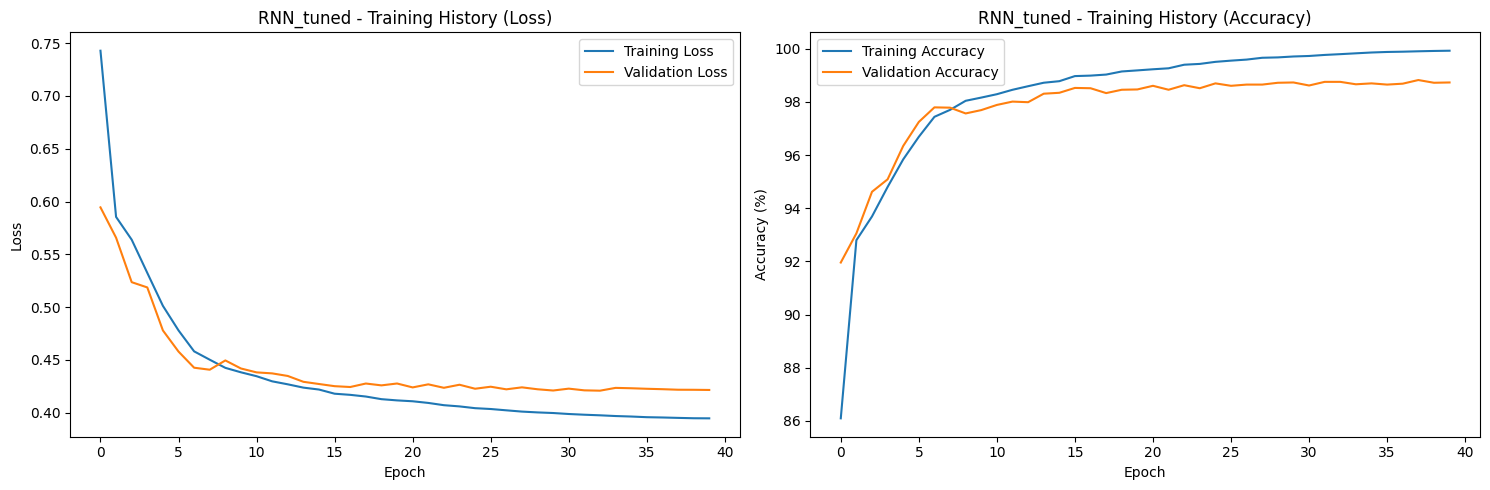

Testing: 100%|██████████| 685/685 [00:01<00:00, 390.91it/s]



Test Accuracy (RNN_tuned): 98.68%

Classification Report (RNN_tuned):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.91      0.80      0.85       556
           2       0.97      0.96      0.97      1448
           3       0.90      0.75      0.82       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.90      0.92     21892
weighted avg       0.99      0.99      0.99     21892



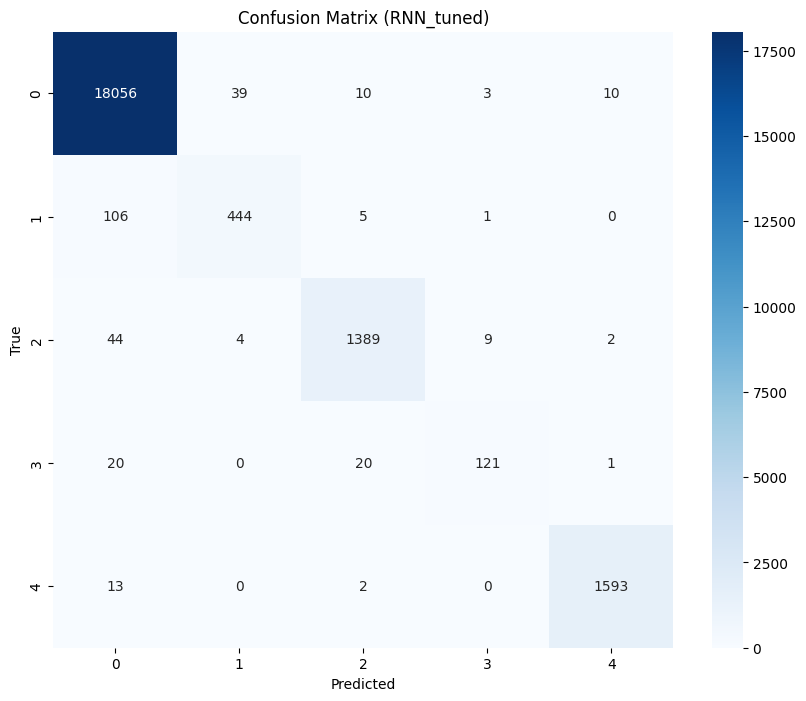

In [28]:
# RNN final retraining
tuned_rnn_trainer, tuned_rnn_test_acc = train_rnn_model(
    model_name='RNN_tuned',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    config_override=optuna_config
)

C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:49: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



Using device: cuda

Starting training for ConvBiGRU_tuned...


Training:   0%|          | 0/2463 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15540\2364616059.py:90: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.02it/s]



Epoch [1/50]
Train Loss: 0.5393, Train Acc: 94.14%
Val   Loss: 0.5058, Val   Acc: 95.05%
Learning Rate: 0.000279
New best model saved! (Val Loss: 0.5058)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.68it/s]



Epoch [2/50]
Train Loss: 0.4838, Train Acc: 96.38%
Val   Loss: 0.4637, Val   Acc: 97.12%
Learning Rate: 0.000616
New best model saved! (Val Loss: 0.4637)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.63it/s]



Epoch [3/50]
Train Loss: 0.4723, Train Acc: 96.91%
Val   Loss: 0.4773, Val   Acc: 96.62%
Learning Rate: 0.001034
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.47it/s]



Epoch [4/50]
Train Loss: 0.4640, Train Acc: 97.22%
Val   Loss: 0.4633, Val   Acc: 96.94%
Learning Rate: 0.001371
New best model saved! (Val Loss: 0.4633)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.68it/s]



Epoch [5/50]
Train Loss: 0.4572, Train Acc: 97.47%
Val   Loss: 0.4491, Val   Acc: 97.62%
Learning Rate: 0.001500
New best model saved! (Val Loss: 0.4491)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.66it/s]



Epoch [6/50]
Train Loss: 0.4491, Train Acc: 97.78%
Val   Loss: 0.4437, Val   Acc: 97.99%
Learning Rate: 0.001498
New best model saved! (Val Loss: 0.4437)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.20it/s]



Epoch [7/50]
Train Loss: 0.4420, Train Acc: 98.04%
Val   Loss: 0.4433, Val   Acc: 97.78%
Learning Rate: 0.001493
New best model saved! (Val Loss: 0.4433)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.25it/s]



Epoch [8/50]
Train Loss: 0.4403, Train Acc: 98.08%
Val   Loss: 0.4478, Val   Acc: 97.69%
Learning Rate: 0.001484
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.93it/s]



Epoch [9/50]
Train Loss: 0.4351, Train Acc: 98.30%
Val   Loss: 0.4342, Val   Acc: 98.25%
Learning Rate: 0.001471
New best model saved! (Val Loss: 0.4342)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.49it/s]



Epoch [10/50]
Train Loss: 0.4319, Train Acc: 98.37%
Val   Loss: 0.4345, Val   Acc: 98.14%
Learning Rate: 0.001455
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.61it/s]



Epoch [11/50]
Train Loss: 0.4295, Train Acc: 98.45%
Val   Loss: 0.4397, Val   Acc: 97.85%
Learning Rate: 0.001435
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.44it/s]



Epoch [12/50]
Train Loss: 0.4304, Train Acc: 98.41%
Val   Loss: 0.4323, Val   Acc: 98.34%
Learning Rate: 0.001412
New best model saved! (Val Loss: 0.4323)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.26it/s]



Epoch [13/50]
Train Loss: 0.4279, Train Acc: 98.50%
Val   Loss: 0.4390, Val   Acc: 98.18%
Learning Rate: 0.001386
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.80it/s]



Epoch [14/50]
Train Loss: 0.4264, Train Acc: 98.56%
Val   Loss: 0.4336, Val   Acc: 98.16%
Learning Rate: 0.001357
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.04it/s]



Epoch [15/50]
Train Loss: 0.4267, Train Acc: 98.52%
Val   Loss: 0.4349, Val   Acc: 98.14%
Learning Rate: 0.001325
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 175.97it/s]



Epoch [16/50]
Train Loss: 0.4233, Train Acc: 98.68%
Val   Loss: 0.4342, Val   Acc: 98.30%
Learning Rate: 0.001290
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.70it/s]



Epoch [17/50]
Train Loss: 0.4221, Train Acc: 98.72%
Val   Loss: 0.4304, Val   Acc: 98.33%
Learning Rate: 0.001252
New best model saved! (Val Loss: 0.4304)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.06it/s]



Epoch [18/50]
Train Loss: 0.4231, Train Acc: 98.70%
Val   Loss: 0.4275, Val   Acc: 98.28%
Learning Rate: 0.001212
New best model saved! (Val Loss: 0.4275)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.98it/s]



Epoch [19/50]
Train Loss: 0.4212, Train Acc: 98.75%
Val   Loss: 0.4279, Val   Acc: 98.45%
Learning Rate: 0.001170
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.63it/s]



Epoch [20/50]
Train Loss: 0.4197, Train Acc: 98.76%
Val   Loss: 0.4264, Val   Acc: 98.57%
Learning Rate: 0.001125
New best model saved! (Val Loss: 0.4264)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.10it/s]



Epoch [21/50]
Train Loss: 0.4200, Train Acc: 98.79%
Val   Loss: 0.4259, Val   Acc: 98.54%
Learning Rate: 0.001079
New best model saved! (Val Loss: 0.4259)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.93it/s]



Epoch [22/50]
Train Loss: 0.4193, Train Acc: 98.82%
Val   Loss: 0.4282, Val   Acc: 98.44%
Learning Rate: 0.001031
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.91it/s]



Epoch [23/50]
Train Loss: 0.4182, Train Acc: 98.87%
Val   Loss: 0.4279, Val   Acc: 98.46%
Learning Rate: 0.000982
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.77it/s]



Epoch [24/50]
Train Loss: 0.4159, Train Acc: 98.95%
Val   Loss: 0.4258, Val   Acc: 98.58%
Learning Rate: 0.000932
New best model saved! (Val Loss: 0.4258)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.86it/s]



Epoch [25/50]
Train Loss: 0.4151, Train Acc: 99.00%
Val   Loss: 0.4235, Val   Acc: 98.57%
Learning Rate: 0.000881
New best model saved! (Val Loss: 0.4235)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.71it/s]



Epoch [26/50]
Train Loss: 0.4141, Train Acc: 98.98%
Val   Loss: 0.4272, Val   Acc: 98.44%
Learning Rate: 0.000829
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.43it/s]



Epoch [27/50]
Train Loss: 0.4132, Train Acc: 99.04%
Val   Loss: 0.4224, Val   Acc: 98.55%
Learning Rate: 0.000777
New best model saved! (Val Loss: 0.4224)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.16it/s]



Epoch [28/50]
Train Loss: 0.4121, Train Acc: 99.12%
Val   Loss: 0.4219, Val   Acc: 98.73%
Learning Rate: 0.000725
New best model saved! (Val Loss: 0.4219)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.68it/s]



Epoch [29/50]
Train Loss: 0.4125, Train Acc: 99.06%
Val   Loss: 0.4221, Val   Acc: 98.63%
Learning Rate: 0.000672
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.70it/s]



Epoch [30/50]
Train Loss: 0.4087, Train Acc: 99.24%
Val   Loss: 0.4230, Val   Acc: 98.55%
Learning Rate: 0.000621
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.59it/s]



Epoch [31/50]
Train Loss: 0.4078, Train Acc: 99.29%
Val   Loss: 0.4217, Val   Acc: 98.64%
Learning Rate: 0.000569
New best model saved! (Val Loss: 0.4217)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.67it/s]



Epoch [32/50]
Train Loss: 0.4069, Train Acc: 99.32%
Val   Loss: 0.4225, Val   Acc: 98.70%
Learning Rate: 0.000519
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.38it/s]



Epoch [33/50]
Train Loss: 0.4054, Train Acc: 99.38%
Val   Loss: 0.4230, Val   Acc: 98.71%
Learning Rate: 0.000470
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.13it/s]



Epoch [34/50]
Train Loss: 0.4035, Train Acc: 99.46%
Val   Loss: 0.4209, Val   Acc: 98.76%
Learning Rate: 0.000422
New best model saved! (Val Loss: 0.4209)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.55it/s]



Epoch [35/50]
Train Loss: 0.4030, Train Acc: 99.52%
Val   Loss: 0.4256, Val   Acc: 98.65%
Learning Rate: 0.000376
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.91it/s]



Epoch [36/50]
Train Loss: 0.4020, Train Acc: 99.54%
Val   Loss: 0.4219, Val   Acc: 98.62%
Learning Rate: 0.000332
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.00it/s]



Epoch [37/50]
Train Loss: 0.4008, Train Acc: 99.58%
Val   Loss: 0.4188, Val   Acc: 98.77%
Learning Rate: 0.000289
New best model saved! (Val Loss: 0.4188)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.05it/s]



Epoch [38/50]
Train Loss: 0.3992, Train Acc: 99.69%
Val   Loss: 0.4211, Val   Acc: 98.79%
Learning Rate: 0.000249
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.92it/s]



Epoch [39/50]
Train Loss: 0.3980, Train Acc: 99.72%
Val   Loss: 0.4214, Val   Acc: 98.72%
Learning Rate: 0.000212
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.11it/s]



Epoch [40/50]
Train Loss: 0.3966, Train Acc: 99.79%
Val   Loss: 0.4210, Val   Acc: 98.78%
Learning Rate: 0.000177
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.83it/s]



Epoch [41/50]
Train Loss: 0.3961, Train Acc: 99.81%
Val   Loss: 0.4195, Val   Acc: 98.86%
Learning Rate: 0.000145
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.80it/s]



Epoch [42/50]
Train Loss: 0.3952, Train Acc: 99.85%
Val   Loss: 0.4192, Val   Acc: 98.85%
Learning Rate: 0.000115
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.75it/s]



Epoch [43/50]
Train Loss: 0.3943, Train Acc: 99.88%
Val   Loss: 0.4202, Val   Acc: 98.84%
Learning Rate: 0.000089
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.80it/s]



Epoch [44/50]
Train Loss: 0.3939, Train Acc: 99.91%
Val   Loss: 0.4200, Val   Acc: 98.80%
Learning Rate: 0.000066
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.88it/s]



Epoch [45/50]
Train Loss: 0.3936, Train Acc: 99.93%
Val   Loss: 0.4207, Val   Acc: 98.79%
Learning Rate: 0.000047
No improvement: 8/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.66it/s]



Epoch [46/50]
Train Loss: 0.3932, Train Acc: 99.94%
Val   Loss: 0.4207, Val   Acc: 98.79%
Learning Rate: 0.000031
No improvement: 9/10


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.92it/s]



Epoch [47/50]
Train Loss: 0.3930, Train Acc: 99.94%
Val   Loss: 0.4207, Val   Acc: 98.80%
Learning Rate: 0.000018
No improvement: 10/10
Early stopping triggered at epoch 47. Best val loss: 0.4188
Restored best model weights.


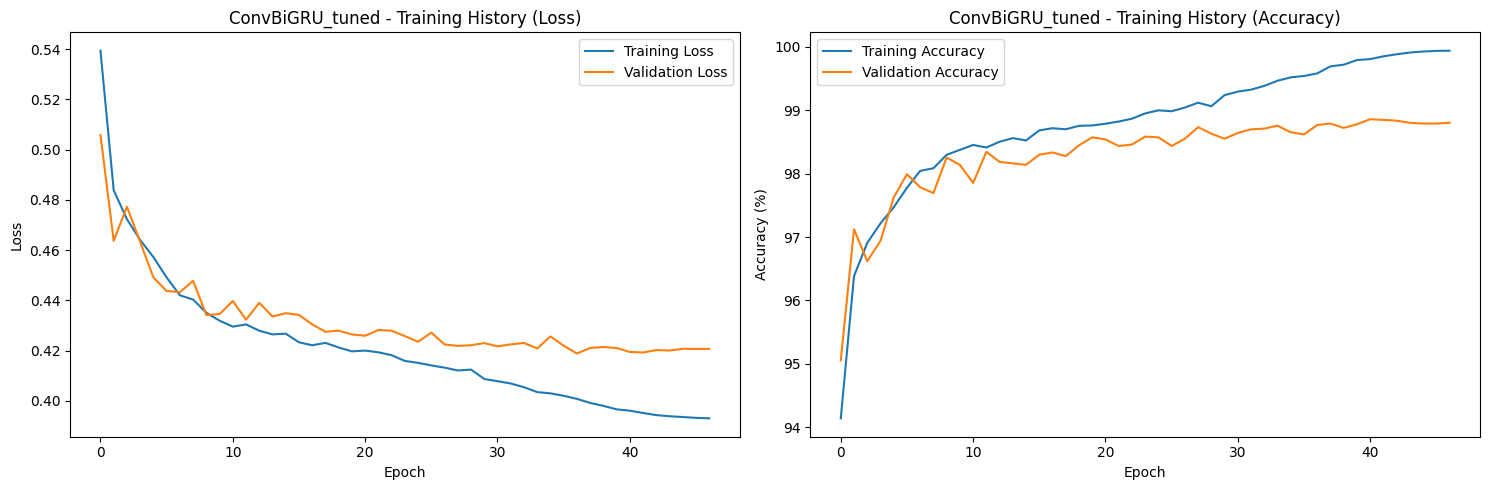

Testing: 100%|██████████| 685/685 [00:01<00:00, 497.58it/s]



Test Accuracy (ConvBiGRU_tuned): 98.81%

Classification Report (ConvBiGRU_tuned):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.94      0.81      0.87       556
           2       0.96      0.97      0.97      1448
           3       0.90      0.77      0.83       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.96      0.91      0.93     21892
weighted avg       0.99      0.99      0.99     21892



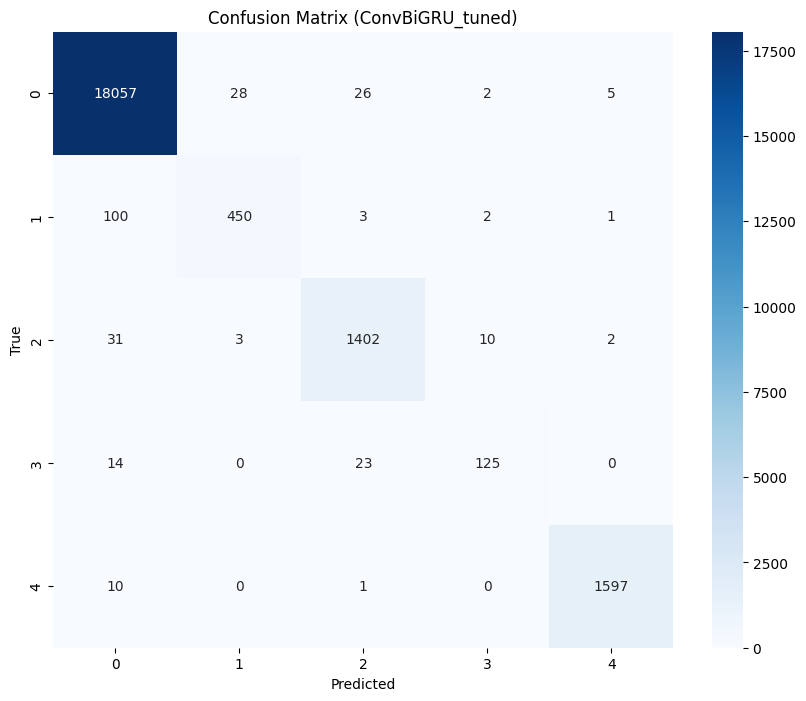

In [29]:
# ConvBiGRU final retraining
tuned_convbigru_trainer, tuned_cbigru_test_acc = train_conv_bigru_model(
    model_name='ConvBiGRU_tuned',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    config_override=optuna_config
)

In [64]:
rnn_gain = tuned_rnn_test_acc - rnn_accuracy
cbigru_gain = tuned_cbigru_test_acc - convbigru_accuracy

print(f"RNN Test Accuracy: {tuned_rnn_test_acc*100:.2f}% ({rnn_gain*100:+.2f}%)")
print(f"ConvBiGRU Test Accuracy: {tuned_cbigru_test_acc*100:.2f}% ({cbigru_gain*100:+.2f}%)\n")

print(f"Baseline RNN Test Accuracy: {rnn_accuracy*100:.2f}%")
print(f"Baseline ConvBiGRU Test Accuracy: {convbigru_accuracy*100:.2f}%")


RNN Test Accuracy: 98.68% (+0.48%)
ConvBiGRU Test Accuracy: 98.81% (+0.16%)

Baseline RNN Test Accuracy: 98.20%
Baseline ConvBiGRU Test Accuracy: 98.65%
